In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pickle
from tqdm import tqdm  # Progress bar

In [ ]:
pip install tqdm

#LOAD DATA

In [ ]:
in_sample_structured = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/data/in_sample_structured.csv', parse_dates=['start_date', 'end_date'])
out_sample_structured = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/data/in_sample_structured.csv', parse_dates=['start_date', 'end_date'])

In [ ]:
# Label encoding for 'direction' column
in_sample_structured['label'] = in_sample_structured['direction'].apply(lambda x: 1 if x == 'Up' else 0)
out_sample_structured['label'] = out_sample_structured['direction'].apply(lambda x: 1 if x == 'Up' else 0)

In [ ]:
# Create a mapping of permco to ticker
permco_to_ticker = in_sample_structured.groupby('permco')['ticker'].first().reset_index()

In [ ]:
out_sample_structured

permco ticker start_date   end_date announcedate  weekly_ret  adj_prc  \
0          90   AEXP 2016-01-04 2016-01-08          NaN   -8.099980    63.63   
1          90   AEXP 2016-01-11 2016-01-15   2016-01-05   -1.131492    62.91   
2          90   AEXP 2016-01-11 2016-01-15   2016-01-05   -1.131492    62.91   
3          90   AEXP 2016-01-11 2016-01-15   2016-01-07   -1.131492    62.91   
4          90   AEXP 2016-01-18 2016-01-22   2016-01-13  -12.478209    55.06   
...       ...    ...        ...        ...          ...         ...      ...   
46779   55100    UBS 2023-12-25 2023-12-29   2023-12-17    0.032307    30.90   
46780   55100    UBS 2023-12-25 2023-12-29   2023-12-17    0.032307    30.90   
46781   55100    UBS 2023-12-25 2023-12-29   2023-12-18    0.032307    30.90   
46782   55100    UBS 2023-12-25 2023-12-29   2023-12-19    0.032307    30.90   
46783   55100    UBS 2023-12-25 2023-12-29   2023-12-20    0.032307    30.90   

                                                headline direction  label  
0                                           No_Headlines        Up      1  
1      American Express Company, Q4 2015 Earnings Cal...      Down      0  
2      American Express Company to Report Q4, 2015 Re...      Down      0  
3      Keefe, Bruyette, & Woods, Inc., Keefe, Bruyett...      Down      0  
4      William Blair & Company, L.L.C., the William B...      Down      0  
...                                                  ...       ...    ...  
46779  CRH plc (NYSE:CRH) agreed to acquire 57% stake...        Up      1  
46780  CRH plc (NYSE:CRH) agreed to acquire 57.3% sta...        Up      1  
46781  Ledman Optoelectronic Co., Ltd. announced that...        Up      1  
46782  UBS Reportedly Wants to Sell Loans That Credit...        Up      1  
46783  Changchun Engley Automobile Industry Co.,Ltd. ...        Up      1  

[46784 rows x 10 columns]

Calculating Embeddings and applying Rolling Window Analysis to find predicted direction for each model.

#EMBEDDING + MODELLING


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class for handling batches of texts
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encodings = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {key: val.squeeze() for key, val in encodings.items()}

# Function to load the model and tokenizer
def load_model_and_tokenizer(model_name):
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer

# Function to prepare data
def prepare_data(texts, tokenizer, max_length=512):
    dataset = TextDataset(texts, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    return dataloader

# Function to get embeddings
def get_embeddings(dataloader, model):
    model.eval()
    embeddings_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing batches"):
            batch = {k: v.to(device) for k, v in batch.items()}

            # Using mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(**batch)

            embeddings = outputs.last_hidden_state.mean(dim=1).cpu()
            embeddings_list.append(embeddings)

    embeddings = torch.cat(embeddings_list, dim=0)
    return embeddings.numpy()

# Function to save results to a checkpoint file
def save_results(results, checkpoint_filename):
    with open(checkpoint_filename, 'wb') as f:
        pickle.dump(results, f)

# Function to load results from a checkpoint file
def load_results(checkpoint_filename):
    try:
        with open(checkpoint_filename, 'rb') as f:
            results = pickle.load(f)
    except FileNotFoundError:
        results = {}
    return results

# Function to add embeddings to the original dataset
def add_embeddings_to_dataset(df, model_name, text_column='headline'):
    model, tokenizer = load_model_and_tokenizer(model_name)
    model.to(device)
    dataloader = prepare_data(df[text_column].tolist(), tokenizer)
    embeddings = get_embeddings(dataloader, model)
    df[f'embeddings_{model_name}'] = list(embeddings)  # Corrected string formatting here
    return df

# Example usage:
# df_with_embeddings = add_embeddings_to_dataset(original_dataset, 'bert-base-uncased')


In [ ]:
# Function to perform rolling window forecast for individual permcos
def rolling_window_forecast_with_embeddings(in_sample_data, out_sample_data, model_name, checkpoint_filename):
    permcos = in_sample_data['permco'].unique()
    all_results = load_results(checkpoint_filename)

    # Ensure 'predicted_direction' column exists
    in_sample_data[f'predicted_direction_{model_name}'] = np.nan
    out_sample_data[f'predicted_direction_{model_name}'] = np.nan

    for permco in tqdm(permcos, desc="Processing permcos"):
        if permco in all_results:
            print(f"Skipping permco {permco} as it is already processed.")
            continue

        permco_results = []
        print(f"Processing permco: {permco}")

        permco_in_sample = in_sample_data[in_sample_data['permco'] == permco]
        permco_out_sample = out_sample_data[out_sample_data['permco'] == permco]

        for year in range(2016, 2024):
            train_data = permco_in_sample[(permco_in_sample['start_date'].dt.year >= (year - 11)) & (permco_in_sample['start_date'].dt.year < (year - 1))]
            eval_data = permco_out_sample[permco_out_sample['start_date'].dt.year == year]

            if train_data.empty or eval_data.empty:
                continue

            if train_data['direction'].nunique() < 2:
                print(f"Skipping permco {permco} for year {year} due to insufficient class variability.")
                continue

            try:
                X_train = np.vstack(train_data[f'embeddings_{model_name}'].values)
                X_eval = np.vstack(eval_data[f'embeddings_{model_name}'].values)

                y_train = train_data['direction'].apply(lambda x: 1 if x == 'Up' else 0).values
                y_eval = eval_data['direction'].apply(lambda x: 1 if x == 'Up' else 0).values

                classifier = LogisticRegression(max_iter=1000)
                classifier.fit(X_train, y_train)

                y_pred = classifier.predict(X_eval)

                # Collect y_pred and update the original DataFrame after loop
                out_sample_data.loc[eval_data.index, f'predicted_direction_{model_name}'] = y_pred

                accuracy = accuracy_score(y_eval, y_pred)
                precision, recall, f1, _ = precision_recall_fscore_support(y_eval, y_pred, average='binary')

                permco_results.append({
                    'permco': permco,
                    'year': year,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                })
            except Exception as e:
                print(f"Error processing permco {permco} for year {year}: {e}")

        all_results[permco] = permco_results
        save_results(all_results, checkpoint_filename)

    results_df = pd.DataFrame([result for permco_results in all_results.values() for result in permco_results])
    return results_df, in_sample_data, out_sample_data

##BERT

In [ ]:
# Load your original datasets
in_sample_data = in_sample_structured
out_sample_data = out_sample_structured

# Ensure date columns are in datetime format
in_sample_data['start_date'] = pd.to_datetime(in_sample_data['start_date'])
out_sample_data['start_date'] = pd.to_datetime(out_sample_data['start_date'])

# Add embeddings to the datasets
in_sample_data_with_embeddings = add_embeddings_to_dataset(in_sample_data, 'bert-base-uncased')
out_sample_data_with_embeddings = add_embeddings_to_dataset(out_sample_data, 'bert-base-uncased')

# Perform rolling window forecast and capture results
results_df, updated_in_sample_data, updated_out_sample_data = rolling_window_forecast_with_embeddings(in_sample_data_with_embeddings, out_sample_data_with_embeddings, 'bert-base-uncased', 'checkpoint.pkl')

# # Save the updated datasets with predicted directions
# updated_in_sample_data.to_csv('updated_in_sample_data.csv', index=False)
# updated_out_sample_data.to_csv('updated_out_sample_data.csv', index=False)

# Save the results dataframe
results_df.to_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_df_BERT.csv', index=False)

# Print the results
results_df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Processing permcos:   0%|          | 0/29 [00:00<?, ?it/s]

Processing permco: 90


Processing permcos:   3%|▎         | 1/29 [00:01<00:42,  1.51s/it]

Processing permco: 137


Processing permcos:   7%|▋         | 2/29 [00:03<00:46,  1.73s/it]

Processing permco: 540


Processing permcos:  10%|█         | 3/29 [00:04<00:32,  1.26s/it]

Processing permco: 1645


Processing permcos:  14%|█▍        | 4/29 [00:05<00:31,  1.27s/it]

Processing permco: 1869
Processing permco: 3151


Processing permcos:  21%|██        | 6/29 [00:15<01:13,  3.18s/it]

Processing permco: 7267


Processing permcos:  24%|██▍       | 7/29 [00:16<00:56,  2.57s/it]

Processing permco: 20265


Processing permcos:  28%|██▊       | 8/29 [00:17<00:46,  2.23s/it]

Processing permco: 20436


Processing permcos:  31%|███       | 9/29 [00:36<02:21,  7.06s/it]

Processing permco: 20483


Processing permcos:  34%|███▍      | 10/29 [00:49<02:46,  8.75s/it]

Processing permco: 20557


Processing permcos:  38%|███▊      | 11/29 [00:50<01:56,  6.48s/it]

Processing permco: 20695
Processing permco: 21190
Processing permco: 21224
Skipping permco 21224 for year 2016 due to insufficient class variability.
Processing permco: 21305


Processing permcos:  52%|█████▏    | 15/29 [00:56<00:47,  3.38s/it]

Processing permco: 29146


Processing permcos:  55%|█████▌    | 16/29 [01:00<00:46,  3.58s/it]

Processing permco: 29151


Processing permcos:  59%|█████▊    | 17/29 [01:11<01:00,  5.02s/it]

Processing permco: 29152


Processing permcos:  62%|██████▏   | 18/29 [01:13<00:47,  4.31s/it]

Processing permco: 35048


Processing permcos:  66%|██████▌   | 19/29 [01:27<01:06,  6.66s/it]

Processing permco: 35276


Processing permcos:  69%|██████▉   | 20/29 [01:28<00:46,  5.21s/it]

Processing permco: 37138


Processing permcos:  72%|███████▏  | 21/29 [01:29<00:32,  4.12s/it]

Processing permco: 37504
Processing permco: 42273


Processing permcos:  79%|███████▉  | 23/29 [01:30<00:15,  2.58s/it]

Processing permco: 42291


Processing permcos:  83%|████████▎ | 24/29 [01:38<00:19,  3.81s/it]

Processing permco: 42524


Processing permcos:  86%|████████▌ | 25/29 [01:40<00:13,  3.32s/it]

Processing permco: 43264


Processing permcos:  90%|████████▉ | 26/29 [01:42<00:09,  3.13s/it]

Processing permco: 50700


Processing permcos:  93%|█████████▎| 27/29 [01:44<00:05,  2.61s/it]

Processing permco: 52983


Processing permcos:  97%|█████████▋| 28/29 [01:45<00:02,  2.25s/it]

Processing permco: 55100


Processing permcos: 100%|██████████| 29/29 [01:46<00:00,  3.66s/it]


permco  year  accuracy  precision    recall        f1
0        90  2016  0.666667   0.609756  0.694444  0.649351
1        90  2017  0.398148   0.750000  0.265823  0.392523
2        90  2018  0.458333   0.575000  0.273810  0.370968
3        90  2019  0.507937   0.580000  0.414286  0.483333
4        90  2020  0.478261   0.444444  0.571429  0.500000
..      ...   ...       ...        ...       ...       ...
187   55100  2019  0.536000   0.539474  0.640625  0.585714
188   55100  2020  0.491525   0.504673  0.593407  0.545455
189   55100  2021  0.539823   0.587302  0.587302  0.587302
190   55100  2022  0.433594   0.413580  0.572650  0.480287
191   55100  2023  0.601010   0.718182  0.622047  0.666667

[192 rows x 6 columns]

##RoBERTa

In [ ]:
# Load your original datasets
in_sample_data = in_sample_structured
out_sample_data = out_sample_structured

# Ensure date columns are in datetime format
in_sample_data['start_date'] = pd.to_datetime(in_sample_data['start_date'])
out_sample_data['start_date'] = pd.to_datetime(out_sample_data['start_date'])

# Add embeddings to the datasets
in_sample_data_with_embeddings = add_embeddings_to_dataset(in_sample_data, 'roberta-base')
out_sample_data_with_embeddings = add_embeddings_to_dataset(out_sample_data, 'roberta-base')

# Perform rolling window forecast and capture results
results_df, updated_in_sample_data, updated_out_sample_data = rolling_window_forecast_with_embeddings(in_sample_data_with_embeddings, out_sample_data_with_embeddings, 'roberta-base', 'checkpoint_roberta.pkl')

# # Save the updated datasets with predicted directions
# updated_in_sample_data.to_csv('updated_in_sample_data.csv', index=False)
# updated_out_sample_data.to_csv('updated_out_sample_data.csv', index=False)

# Save the results dataframe
results_df.to_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_df_RoBERTa.csv', index=False)

# Print the results
results_df

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Processing batches: 100%|██████████| 2439/2439 [02:59<00:00, 13.62it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing permcos:   0%|          | 0/29 [00:00<?, ?it/s]

Processing permco: 90


Processing permcos:   3%|▎         | 1/29 [00:02<00:58,  2.09s/it]

Processing permco: 137


Processing permcos:   7%|▋         | 2/29 [00:05<01:10,  2.60s/it]

Processing permco: 540


Processing permcos:  10%|█         | 3/29 [00:06<00:52,  2.00s/it]

Processing permco: 1645


Processing permcos:  14%|█▍        | 4/29 [00:08<00:48,  1.92s/it]

Processing permco: 1869
Processing permco: 3151


Processing permcos:  21%|██        | 6/29 [00:16<01:14,  3.24s/it]

Processing permco: 7267


Processing permcos:  24%|██▍       | 7/29 [00:18<01:01,  2.80s/it]

Processing permco: 20265


Processing permcos:  28%|██▊       | 8/29 [00:21<00:59,  2.84s/it]

Processing permco: 20436


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Processing permco: 20483


Processing permcos:  34%|███▍      | 10/29 [01:04<03:33, 11.23s/it]

Processing permco: 20557


Processing permcos:  38%|███▊      | 11/29 [01:05<02:30,  8.35s/it]

Processing permco: 20695
Processing permco: 21190
Processing permco: 21224
Skipping permco 21224 for year 2016 due to insufficient class variability.
Processing permco: 21305


Processing permcos:  52%|█████▏    | 15/29 [01:09<00:52,  3.74s/it]

Processing permco: 29146


Processing permcos:  55%|█████▌    | 16/29 [01:14<00:50,  3.85s/it]

Processing permco: 29151


Processing permcos:  59%|█████▊    | 17/29 [01:39<01:38,  8.24s/it]

Processing permco: 29152


Processing permcos:  62%|██████▏   | 18/29 [01:42<01:18,  7.10s/it]

Processing permco: 35048


Processing permcos:  66%|██████▌   | 19/29 [02:03<01:44, 10.41s/it]

Processing permco: 35276


Processing permcos:  69%|██████▉   | 20/29 [02:04<01:13,  8.12s/it]

Processing permco: 37138


Processing permcos:  72%|███████▏  | 21/29 [02:06<00:51,  6.46s/it]

Processing permco: 37504
Processing permco: 42273


Processing permcos:  79%|███████▉  | 23/29 [02:08<00:23,  3.95s/it]

Processing permco: 42291


Processing permcos:  83%|████████▎ | 24/29 [02:14<00:23,  4.62s/it]

Processing permco: 42524


Processing permcos:  86%|████████▌ | 25/29 [02:17<00:16,  4.08s/it]

Processing permco: 43264


Processing permcos:  90%|████████▉ | 26/29 [02:20<00:11,  3.85s/it]

Processing permco: 50700


Processing permcos:  93%|█████████▎| 27/29 [02:22<00:06,  3.28s/it]

Processing permco: 52983


Processing permcos:  97%|█████████▋| 28/29 [02:24<00:03,  3.06s/it]

Processing permco: 55100


Processing permcos: 100%|██████████| 29/29 [02:25<00:00,  5.02s/it]


permco  year  accuracy  precision    recall        f1
0        90  2016  0.530864   0.483333  0.805556  0.604167
1        90  2017  0.518519   0.707692  0.582278  0.638889
2        90  2018  0.590278   0.623762  0.750000  0.681081
3        90  2019  0.571429   0.590909  0.742857  0.658228
4        90  2020  0.532609   0.492754  0.809524  0.612613
..      ...   ...       ...        ...       ...       ...
187   55100  2019  0.448000   0.448980  0.343750  0.389381
188   55100  2020  0.457627   0.467532  0.395604  0.428571
189   55100  2021  0.438053   0.494845  0.380952  0.430493
190   55100  2022  0.480469   0.437500  0.478632  0.457143
191   55100  2023  0.489899   0.666667  0.409449  0.507317

[192 rows x 6 columns]

##DistilBERT

In [ ]:
# Load your original datasets
in_sample_data = in_sample_structured
out_sample_data = out_sample_structured

# Ensure date columns are in datetime format
in_sample_data['start_date'] = pd.to_datetime(in_sample_data['start_date'])
out_sample_data['start_date'] = pd.to_datetime(out_sample_data['start_date'])

# # Add embeddings to the datasets
# in_sample_data_with_embeddings = add_embeddings_to_dataset(in_sample_data, 'distilbert-base-uncased')
# out_sample_data_with_embeddings = add_embeddings_to_dataset(out_sample_data, 'distilbert-base-uncased')

# Perform rolling window forecast and capture results
results_DB, updated_in_sample_data_DB, updated_out_sample_data_DB = rolling_window_forecast_with_embeddings(in_sample_data_with_embeddings, out_sample_data_with_embeddings, 'distilbert-base-uncased', 'checkpoint_DB.pkl')

# # Save the updated datasets with predicted directions
# updated_in_sample_data.to_csv('updated_in_sample_data.csv', index=False)
# updated_out_sample_data.to_csv('updated_out_sample_data.csv', index=False)

# Save the results dataframe
results_DB.to_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_DB.csv', index=False)

# Print the results
results_DB

Processing permcos:   0%|          | 0/29 [00:00<?, ?it/s]

Processing permco: 90


Processing permcos:   3%|▎         | 1/29 [00:01<00:29,  1.04s/it]

Processing permco: 137


Processing permcos:   7%|▋         | 2/29 [00:02<00:34,  1.29s/it]

Processing permco: 540


Processing permcos:  10%|█         | 3/29 [00:03<00:25,  1.04it/s]

Processing permco: 1645


Processing permcos:  14%|█▍        | 4/29 [00:03<00:23,  1.06it/s]

Processing permco: 1869
Processing permco: 3151


Processing permcos:  21%|██        | 6/29 [00:10<00:47,  2.04s/it]

Processing permco: 7267


Processing permcos:  24%|██▍       | 7/29 [00:10<00:37,  1.71s/it]

Processing permco: 20265


Processing permcos:  28%|██▊       | 8/29 [00:12<00:35,  1.70s/it]

Processing permco: 20436


Processing permcos:  31%|███       | 9/29 [00:30<02:05,  6.30s/it]

Processing permco: 20483


Processing permcos:  34%|███▍      | 10/29 [00:40<02:22,  7.50s/it]

Processing permco: 20557


Processing permcos:  38%|███▊      | 11/29 [00:41<01:40,  5.60s/it]

Processing permco: 20695
Processing permco: 21190
Processing permco: 21224
Skipping permco 21224 for year 2016 due to insufficient class variability.
Processing permco: 21305


Processing permcos:  52%|█████▏    | 15/29 [00:45<00:37,  2.71s/it]

Processing permco: 29146


Processing permcos:  55%|█████▌    | 16/29 [00:47<00:33,  2.61s/it]

Processing permco: 29151


Processing permcos:  59%|█████▊    | 17/29 [00:56<00:47,  3.92s/it]

Processing permco: 29152


Processing permcos:  62%|██████▏   | 18/29 [00:58<00:37,  3.40s/it]

Processing permco: 35048


Processing permcos:  66%|██████▌   | 19/29 [01:06<00:46,  4.68s/it]

Processing permco: 35276


Processing permcos:  69%|██████▉   | 20/29 [01:08<00:34,  3.80s/it]

Processing permco: 37138


Processing permcos:  72%|███████▏  | 21/29 [01:09<00:25,  3.13s/it]

Processing permco: 37504
Processing permco: 42273


Processing permcos:  79%|███████▉  | 23/29 [01:10<00:12,  2.04s/it]

Processing permco: 42291


Processing permcos:  83%|████████▎ | 24/29 [01:15<00:12,  2.58s/it]

Processing permco: 42524


Processing permcos:  86%|████████▌ | 25/29 [01:16<00:08,  2.22s/it]

Processing permco: 43264


Processing permcos:  90%|████████▉ | 26/29 [01:18<00:06,  2.07s/it]

Processing permco: 50700


Processing permcos:  93%|█████████▎| 27/29 [01:19<00:03,  1.80s/it]

Processing permco: 52983


Processing permcos:  97%|█████████▋| 28/29 [01:20<00:01,  1.75s/it]

Processing permco: 55100


Processing permcos: 100%|██████████| 29/29 [01:21<00:00,  2.80s/it]


permco  year  accuracy  precision    recall        f1
0        90  2016  0.580247   0.517857  0.805556  0.630435
1        90  2017  0.444444   0.743590  0.367089  0.491525
2        90  2018  0.493056   0.596491  0.404762  0.482270
3        90  2019  0.492063   0.555556  0.428571  0.483871
4        90  2020  0.467391   0.436364  0.571429  0.494845
..      ...   ...       ...        ...       ...       ...
187   55100  2019  0.592000   0.594203  0.640625  0.616541
188   55100  2020  0.497175   0.510417  0.538462  0.524064
189   55100  2021  0.561947   0.623853  0.539683  0.578723
190   55100  2022  0.542969   0.500000  0.581197  0.537549
191   55100  2023  0.515152   0.670330  0.480315  0.559633

[192 rows x 6 columns]

##DistilRoBERTa

In [ ]:
# Load your original datasets
in_sample_data = in_sample_structured
out_sample_data = out_sample_structured

# Ensure date columns are in datetime format
in_sample_data['start_date'] = pd.to_datetime(in_sample_data['start_date'])
out_sample_data['start_date'] = pd.to_datetime(out_sample_data['start_date'])

# Add embeddings to the datasets
in_sample_data_with_embeddings = add_embeddings_to_dataset(in_sample_data, 'distilroberta-base')
out_sample_data_with_embeddings = add_embeddings_to_dataset(out_sample_data, 'distilroberta-base')

# Perform rolling window forecast and capture results
results_DRB, updated_in_sample_data_DB, updated_out_sample_data_DB = rolling_window_forecast_with_embeddings(in_sample_data_with_embeddings, out_sample_data_with_embeddings, 'distilroberta-base', 'checkpoint_distilroberta.pkl')

# # Save the updated datasets with predicted directions
# updated_in_sample_data.to_csv('updated_in_sample_data.csv', index=False)
# updated_out_sample_data.to_csv('updated_out_sample_data.csv', index=False)

# Save the results dataframe
results_DRB.to_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_DRB.csv', index=False)

# Print the results
results_DRB

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Processing permcos:   0%|          | 0/29 [00:00<?, ?it/s]

Processing permco: 90


Processing permcos:   3%|▎         | 1/29 [00:01<00:29,  1.06s/it]

Processing permco: 137


Processing permcos:   7%|▋         | 2/29 [00:02<00:30,  1.13s/it]

Processing permco: 540


Processing permcos:  10%|█         | 3/29 [00:02<00:21,  1.19it/s]

Processing permco: 1645


Processing permcos:  14%|█▍        | 4/29 [00:03<00:21,  1.17it/s]

Processing permco: 1869
Processing permco: 3151


Processing permcos:  21%|██        | 6/29 [00:07<00:33,  1.44s/it]

Processing permco: 7267


Processing permcos:  24%|██▍       | 7/29 [00:08<00:27,  1.26s/it]

Processing permco: 20265


Processing permcos:  28%|██▊       | 8/29 [00:10<00:30,  1.46s/it]

Processing permco: 20436


Processing permcos:  31%|███       | 9/29 [00:19<01:14,  3.74s/it]

Processing permco: 20483


Processing permcos:  34%|███▍      | 10/29 [00:24<01:17,  4.10s/it]

Processing permco: 20557


Processing permcos:  38%|███▊      | 11/29 [00:25<00:54,  3.05s/it]

Processing permco: 20695
Processing permco: 21190
Processing permco: 21224
Skipping permco 21224 for year 2016 due to insufficient class variability.
Processing permco: 21305


Processing permcos:  52%|█████▏    | 15/29 [00:27<00:21,  1.52s/it]

Processing permco: 29146


Processing permcos:  55%|█████▌    | 16/29 [00:29<00:19,  1.50s/it]

Processing permco: 29151


Processing permcos:  59%|█████▊    | 17/29 [00:32<00:22,  1.89s/it]

Processing permco: 29152


Processing permcos:  62%|██████▏   | 18/29 [00:33<00:18,  1.66s/it]

Processing permco: 35048


Processing permcos:  66%|██████▌   | 19/29 [00:38<00:26,  2.64s/it]

Processing permco: 35276


Processing permcos:  69%|██████▉   | 20/29 [00:39<00:18,  2.09s/it]

Processing permco: 37138


Processing permcos:  72%|███████▏  | 21/29 [00:40<00:15,  1.91s/it]

Processing permco: 37504
Processing permco: 42273


Processing permcos:  79%|███████▉  | 23/29 [00:42<00:08,  1.35s/it]

Processing permco: 42291


Processing permcos:  83%|████████▎ | 24/29 [00:47<00:11,  2.21s/it]

Processing permco: 42524


Processing permcos:  86%|████████▌ | 25/29 [00:48<00:07,  1.88s/it]

Processing permco: 43264


Processing permcos:  90%|████████▉ | 26/29 [00:48<00:04,  1.55s/it]

Processing permco: 50700


Processing permcos:  93%|█████████▎| 27/29 [00:49<00:02,  1.42s/it]

Processing permco: 52983


Processing permcos:  97%|█████████▋| 28/29 [00:50<00:01,  1.23s/it]

Processing permco: 55100


Processing permcos: 100%|██████████| 29/29 [00:50<00:00,  1.76s/it]


permco  year  accuracy  precision    recall        f1
0        90  2016  0.419753   0.422535  0.833333  0.560748
1        90  2017  0.620370   0.743590  0.734177  0.738854
2        90  2018  0.590278   0.601626  0.880952  0.714976
3        90  2019  0.492063   0.536585  0.628571  0.578947
4        90  2020  0.445652   0.426230  0.619048  0.504854
..      ...   ...       ...        ...       ...       ...
187   55100  2019  0.544000   0.553846  0.562500  0.558140
188   55100  2020  0.491525   0.504950  0.560440  0.531250
189   55100  2021  0.451327   0.507576  0.531746  0.519380
190   55100  2022  0.457031   0.432099  0.598291  0.501792
191   55100  2023  0.616162   0.738318  0.622047  0.675214

[192 rows x 6 columns]

##FinBERT

In [ ]:
# Load your original datasets
in_sample_data = in_sample_structured
out_sample_data = out_sample_structured

# Ensure date columns are in datetime format
in_sample_data['start_date'] = pd.to_datetime(in_sample_data['start_date'])
out_sample_data['start_date'] = pd.to_datetime(out_sample_data['start_date'])

# Add embeddings to the datasets
in_sample_data_with_embeddings = add_embeddings_to_dataset(in_sample_data, 'yiyanghkust/finbert-tone')
out_sample_data_with_embeddings = add_embeddings_to_dataset(out_sample_data, 'yiyanghkust/finbert-tone')

# Perform rolling window forecast and capture results
results_Fin, updated_in_sample_data_DB, updated_out_sample_data_DB = rolling_window_forecast_with_embeddings(in_sample_data_with_embeddings, out_sample_data_with_embeddings, 'yiyanghkust/finbert-tone', 'checkpoint_finbert.pkl')

# # Save the updated datasets with predicted directions
# updated_in_sample_data.to_csv('updated_in_sample_data.csv', index=False)

updated_out_sample_data.to_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/updated_out_sample_data.csv', index=False)

# Save the results dataframe
results_Fin.to_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_Fin.csv', index=False)

# Print the results
results_Fin

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Processing permcos:   0%|          | 0/29 [00:00<?, ?it/s]

Processing permco: 90


Processing permcos:   3%|▎         | 1/29 [00:02<01:19,  2.85s/it]

Processing permco: 137


Processing permcos:   7%|▋         | 2/29 [00:06<01:27,  3.24s/it]

Processing permco: 540


Processing permcos:  10%|█         | 3/29 [00:07<00:59,  2.30s/it]

Processing permco: 1645


Processing permcos:  14%|█▍        | 4/29 [00:09<00:58,  2.32s/it]

Processing permco: 1869
Processing permco: 3151


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Processing permco: 7267


Processing permcos:  24%|██▍       | 7/29 [00:25<01:27,  3.96s/it]

Processing permco: 20265


Processing permcos:  28%|██▊       | 8/29 [00:29<01:20,  3.83s/it]

Processing permco: 20436


Processing permcos:  31%|███       | 9/29 [00:55<03:25, 10.26s/it]

Processing permco: 20483


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Processing permco: 20557


Processing permcos:  38%|███▊      | 11/29 [01:12<02:38,  8.78s/it]

Processing permco: 20695
Processing permco: 21190
Processing permco: 21224
Skipping permco 21224 for year 2016 due to insufficient class variability.
Processing permco: 21305


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Processing permco: 29146


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Processing permco: 29151


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Processing permco: 29152


Processing permcos:  62%|██████▏   | 18/29 [01:56<01:24,  7.69s/it]

Processing permco: 35048


Processing permcos:  66%|██████▌   | 19/29 [02:14<01:44, 10.42s/it]

Processing permco: 35276


Processing permcos:  69%|██████▉   | 20/29 [02:17<01:15,  8.34s/it]

Processing permco: 37138


Processing permcos:  72%|███████▏  | 21/29 [02:19<00:54,  6.79s/it]

Processing permco: 37504
Processing permco: 42273


Processing permcos:  79%|███████▉  | 23/29 [02:22<00:25,  4.29s/it]

Processing permco: 42291


Processing permcos:  83%|████████▎ | 24/29 [02:30<00:26,  5.24s/it]

Processing permco: 42524


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Processing permcos:  86%|████████▌ | 25/29 [02:33<00:18,  4.66s/it]

Processing permco: 43264


Processing permcos:  90%|████████▉ | 26/29 [02:37<00:13,  4.49s/it]

Processing permco: 50700


Processing permcos:  93%|█████████▎| 27/29 [02:39<00:07,  3.88s/it]

Processing permco: 52983


Processing permcos:  97%|█████████▋| 28/29 [02:42<00:03,  3.54s/it]

Processing permco: 55100


Processing permcos: 100%|██████████| 29/29 [02:42<00:00,  5.62s/it]


permco  year  accuracy  precision    recall        f1
0        90  2016  0.530864   0.475000  0.527778  0.500000
1        90  2017  0.537037   0.754386  0.544304  0.632353
2        90  2018  0.506944   0.597015  0.476190  0.529801
3        90  2019  0.634921   0.722222  0.557143  0.629032
4        90  2020  0.500000   0.437500  0.333333  0.378378
..      ...   ...       ...        ...       ...       ...
187   55100  2019  0.528000   0.560976  0.359375  0.438095
188   55100  2020  0.485876   0.500000  0.351648  0.412903
189   55100  2021  0.455752   0.514286  0.428571  0.467532
190   55100  2022  0.472656   0.434783  0.512821  0.470588
191   55100  2023  0.550505   0.702128  0.519685  0.597285

[192 rows x 6 columns]

#RESULT ANALYSIS

In [2]:
import pandas as pd

In [3]:
updated_out_sample_data = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/updated_out_sample_data.csv')

In [4]:
updated_out_sample_data.head()

permco ticker  start_date    end_date announcedate  weekly_ret  adj_prc  \
0      90   AEXP  2016-01-04  2016-01-08          NaN   -8.099980    63.63   
1      90   AEXP  2016-01-11  2016-01-15   2016-01-05   -1.131492    62.91   
2      90   AEXP  2016-01-11  2016-01-15   2016-01-05   -1.131492    62.91   
3      90   AEXP  2016-01-11  2016-01-15   2016-01-07   -1.131492    62.91   
4      90   AEXP  2016-01-18  2016-01-22   2016-01-13  -12.478209    55.06   

                                            headline direction  label  \
0                                       No_Headlines        Up      1   
1  American Express Company, Q4 2015 Earnings Cal...      Down      0   
2  American Express Company to Report Q4, 2015 Re...      Down      0   
3  Keefe, Bruyette, & Woods, Inc., Keefe, Bruyett...      Down      0   
4  William Blair & Company, L.L.C., the William B...      Down      0   

                        embeddings_bert-base-uncased  \
0  [-9.82060879e-02 -8.96423534e-02  3.14932615e-...   
1  [-2.73852646e-01 -3.17556679e-01  1.86395407e-...   
2  [-2.77936786e-01 -2.50797927e-01  5.10013461e-...   
3  [-2.88774788e-01 -1.06754221e-01  4.55723196e-...   
4  [-5.32218218e-01 -2.83114433e-01  2.27171972e-...   

   predicted_direction_bert-base-uncased  \
0                                    1.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

                             embeddings_roberta-base  \
0  [-7.19479322e-02 -1.44707367e-01 -1.17597124e-...   
1  [ 1.80668876e-01  2.71915734e-01 -6.18177466e-...   
2  [-8.21089093e-03  9.77932364e-02 -2.36350158e-...   
3  [-7.84931611e-03  1.25758961e-01  6.06743768e-...   
4  [-7.67796487e-03  5.83324283e-02  9.09621362e-...   

   predicted_direction_roberta-base  \
0                               1.0   
1                               1.0   
2                               1.0   
3                               0.0   
4                               1.0   

                  embeddings_distilbert-base-uncased  \
0  [-1.25779986e-01 -6.91891760e-02  1.31961673e-...   
1  [-3.41024339e-01 -1.99908391e-02  3.49603534e-...   
2  [-3.04641306e-01 -5.23198321e-02  4.00941253e-...   
3  [-1.34224266e-01  1.64538234e-01  4.59518969e-...   
4  [-3.33897173e-01  5.85352667e-02  3.69941682e-...   

   predicted_direction_distilbert-base-uncased  \
0                                          1.0   
1                                          0.0   
2                                          0.0   
3                                          1.0   
4                                          1.0   

                       embeddings_distilroberta-base  \
0  [-3.21644098e-02 -7.07554147e-02  6.97157308e-...   
1  [ 6.46896213e-02  4.64862287e-02  1.28087148e-...   
2  [ 2.95245498e-02  4.52245846e-02  1.21129185e-...   
3  [ 4.57062647e-02  2.70432048e-02  1.43248752e-...   
4  [ 6.31753653e-02  3.03596780e-02  1.45334378e-...   

   predicted_direction_distilroberta-base  \
0                                     1.0   
1                                     1.0   
2                                     1.0   
3                                     1.0   
4                                     1.0   

                 embeddings_yiyanghkust/finbert-tone  \
0  [ 4.24219444e-02 -2.95904994e-01 -4.27887261e-...   
1  [ 5.95921874e-01 -1.11231184e+00 -9.53542650e-...   
2  [ 6.90139830e-02 -8.54364097e-01 -1.38161659e+...   
3  [ 1.04530823e+00  3.09280083e-02 -2.72969753e-...   
4  [ 2.19634235e-01 -2.70515382e-01 -5.28132141e-...   

   predicted_direction_yiyanghkust/finbert-tone  
0                                           1.0  
1                                           1.0  
2                                           0.0  
3                                           1.0  
4                                           0.0

In [ ]:
bert = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_df_BERT.csv')
roberta = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_df_RoBERTa.csv')
distilbert = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_DB.csv')
distilroberta = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_DRB.csv')
finbert = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/results/pre-trained/results_Fin.csv')

In [ ]:
bert = bert.rename(columns={'accuracy': 'BERT'})
roberta = roberta.rename(columns={'accuracy': 'RoBERTa'})
distilbert = distilbert.rename(columns={'accuracy': 'DistilBERT'})
distilroberta = distilroberta.rename(columns={'accuracy': 'DistilRoBERTa'})
finbert = finbert.rename(columns={'accuracy': 'FinBERT'})

In [ ]:
bert_new = bert[['permco','year','BERT']]
roberta_new = roberta[['permco','year','RoBERTa']]
distilbert_new = distilbert[['permco','year','DistilBERT']]
distilroberta_new = distilroberta[['permco','year','DistilRoBERTa']]
finbert_new = finbert[['permco','year','FinBERT']]

In [ ]:
final = pd.merge(bert_new, roberta_new, on=['permco','year'])

In [ ]:
final = pd.merge(final, distilbert_new, on=['permco','year'])

In [ ]:
final = pd.merge(final, distilroberta_new, on=['permco','year'])
final = pd.merge(final, finbert_new, on=['permco','year'])

In [ ]:
# Merge the mapping with the final accuracy dataframe
finalv2 = final.merge(permco_to_ticker, on='permco', how='left')
finalv2 = finalv2[['ticker','year','BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']]

In [ ]:
finalv2

ticker  year      BERT   RoBERTa  DistilBERT  DistilRoBERTa   FinBERT
0     AEXP  2016  0.666667  0.530864    0.580247       0.419753  0.530864
1     AEXP  2017  0.398148  0.518519    0.444444       0.620370  0.537037
2     AEXP  2018  0.458333  0.590278    0.493056       0.590278  0.506944
3     AEXP  2019  0.507937  0.571429    0.492063       0.492063  0.634921
4     AEXP  2020  0.478261  0.532609    0.467391       0.445652  0.500000
..     ...   ...       ...       ...         ...            ...       ...
187    UBS  2019  0.536000  0.448000    0.592000       0.544000  0.528000
188    UBS  2020  0.491525  0.457627    0.497175       0.491525  0.485876
189    UBS  2021  0.539823  0.438053    0.561947       0.451327  0.455752
190    UBS  2022  0.433594  0.480469    0.542969       0.457031  0.472656
191    UBS  2023  0.601010  0.489899    0.515152       0.616162  0.550505

[192 rows x 7 columns]

####Ticker-wise accuracy plots

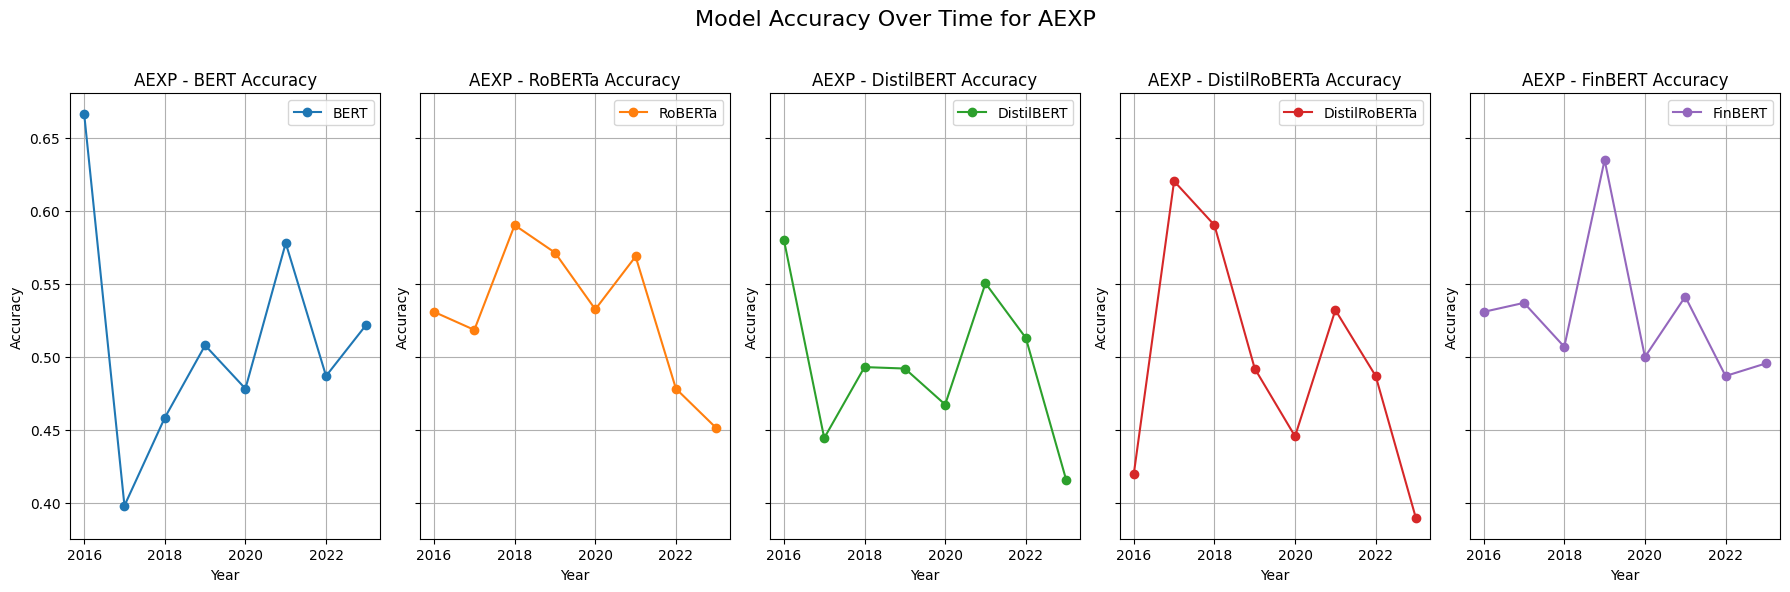

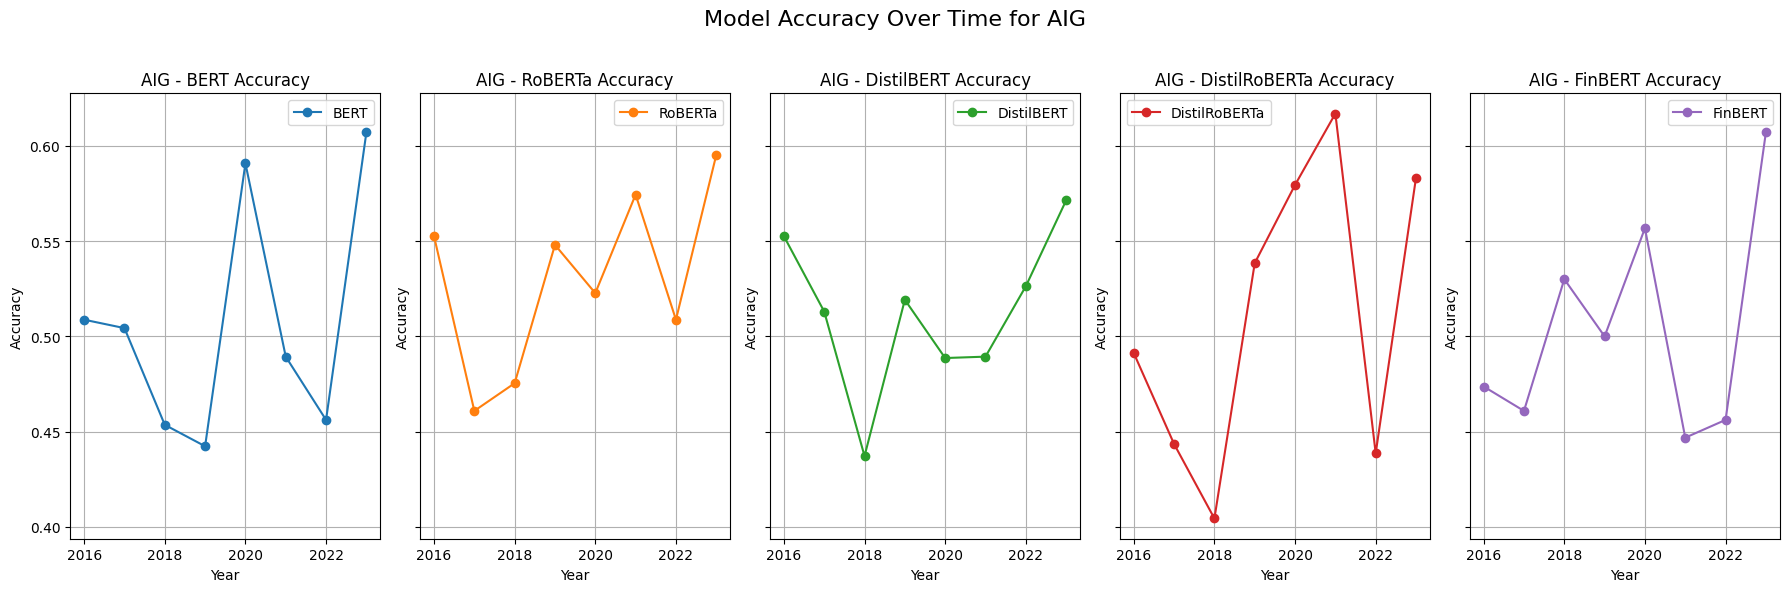

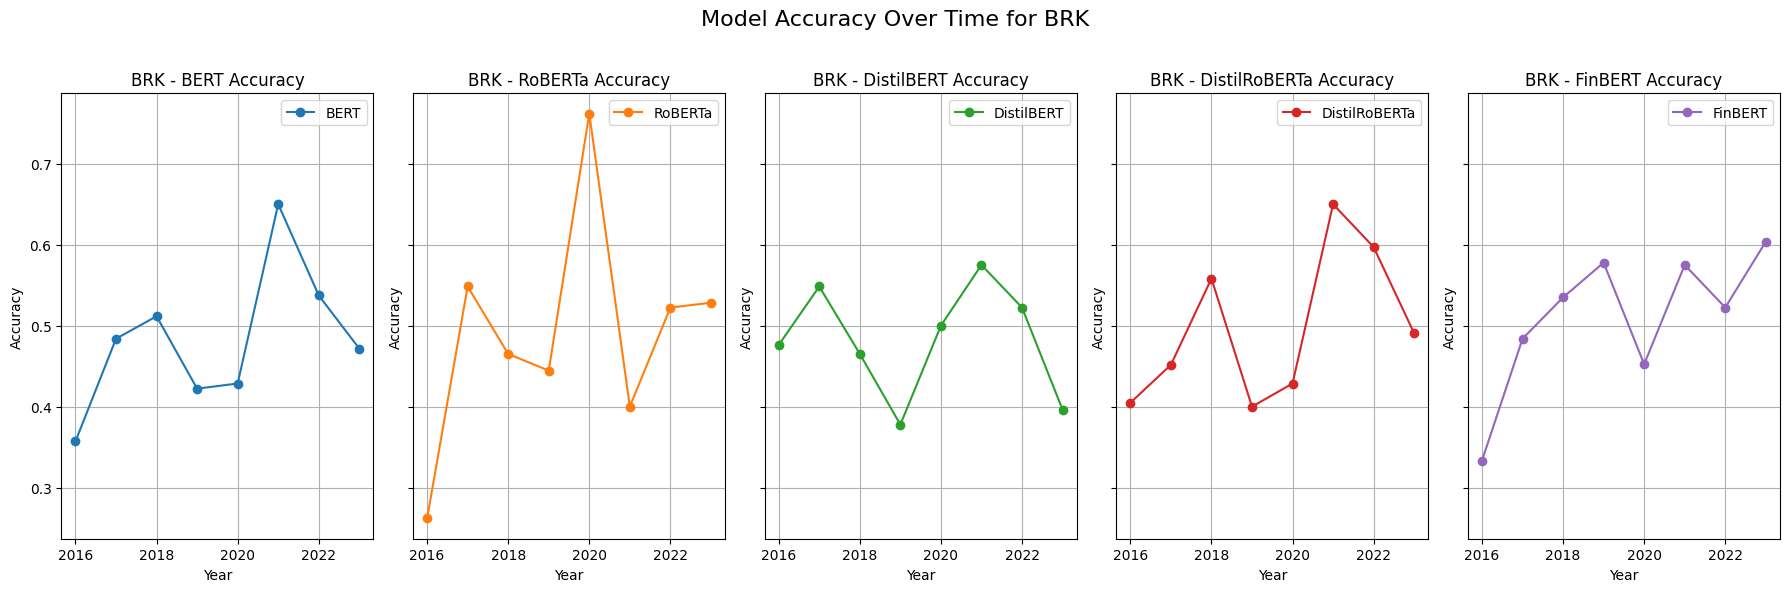

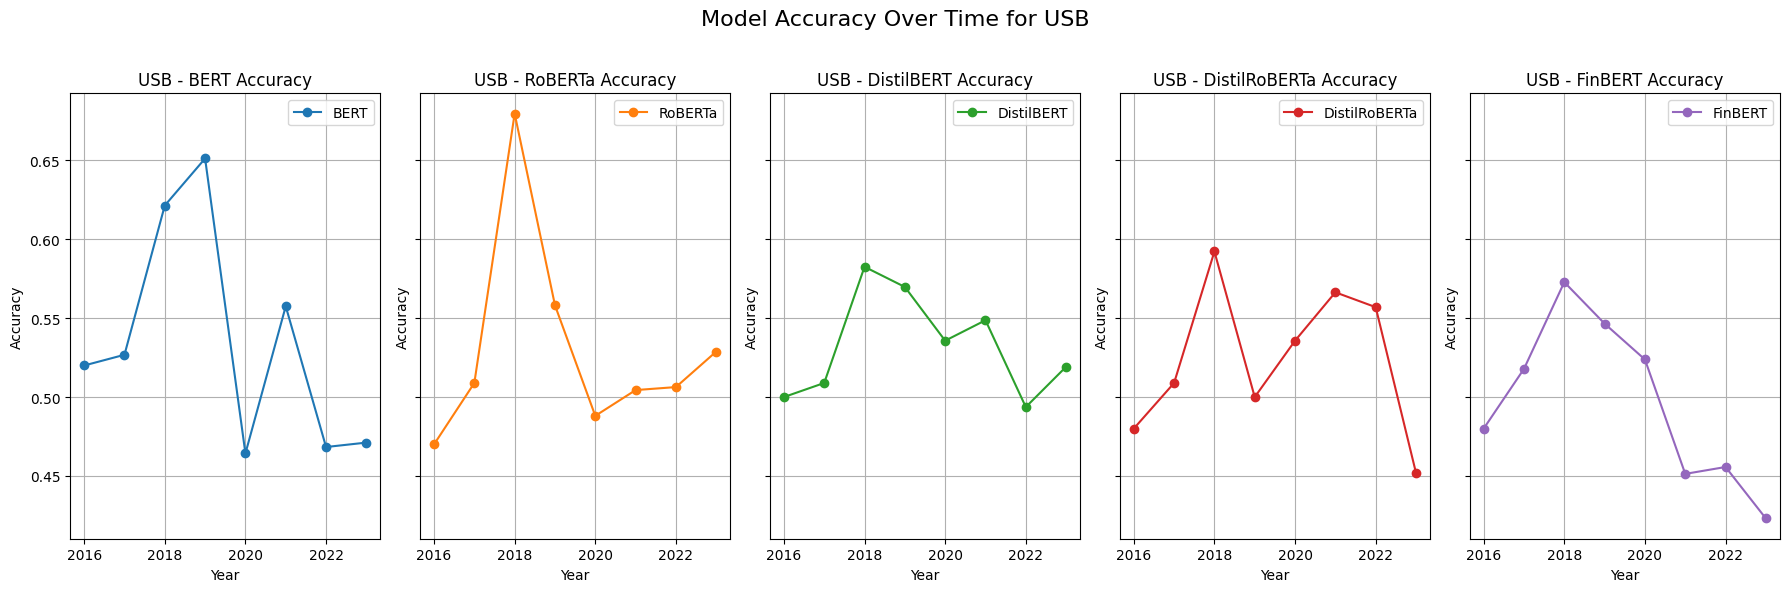

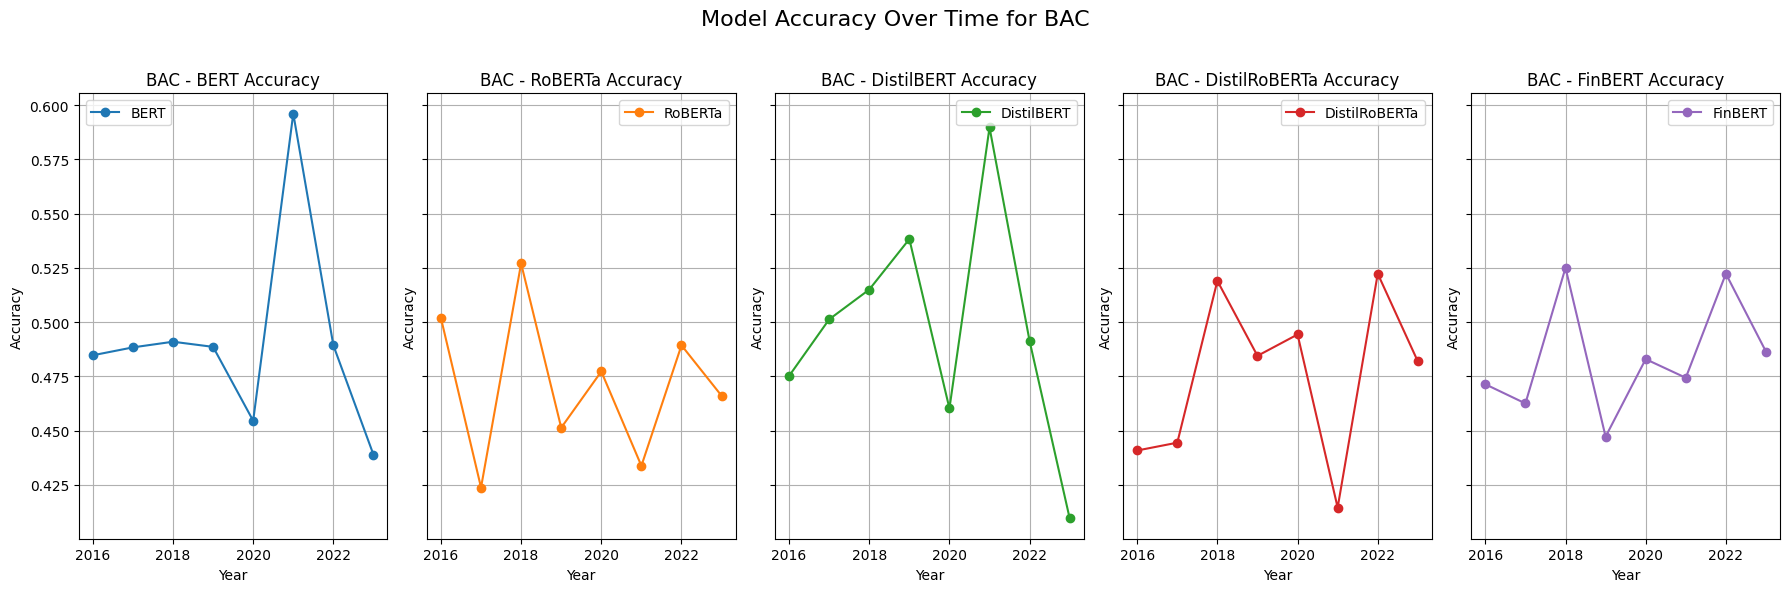

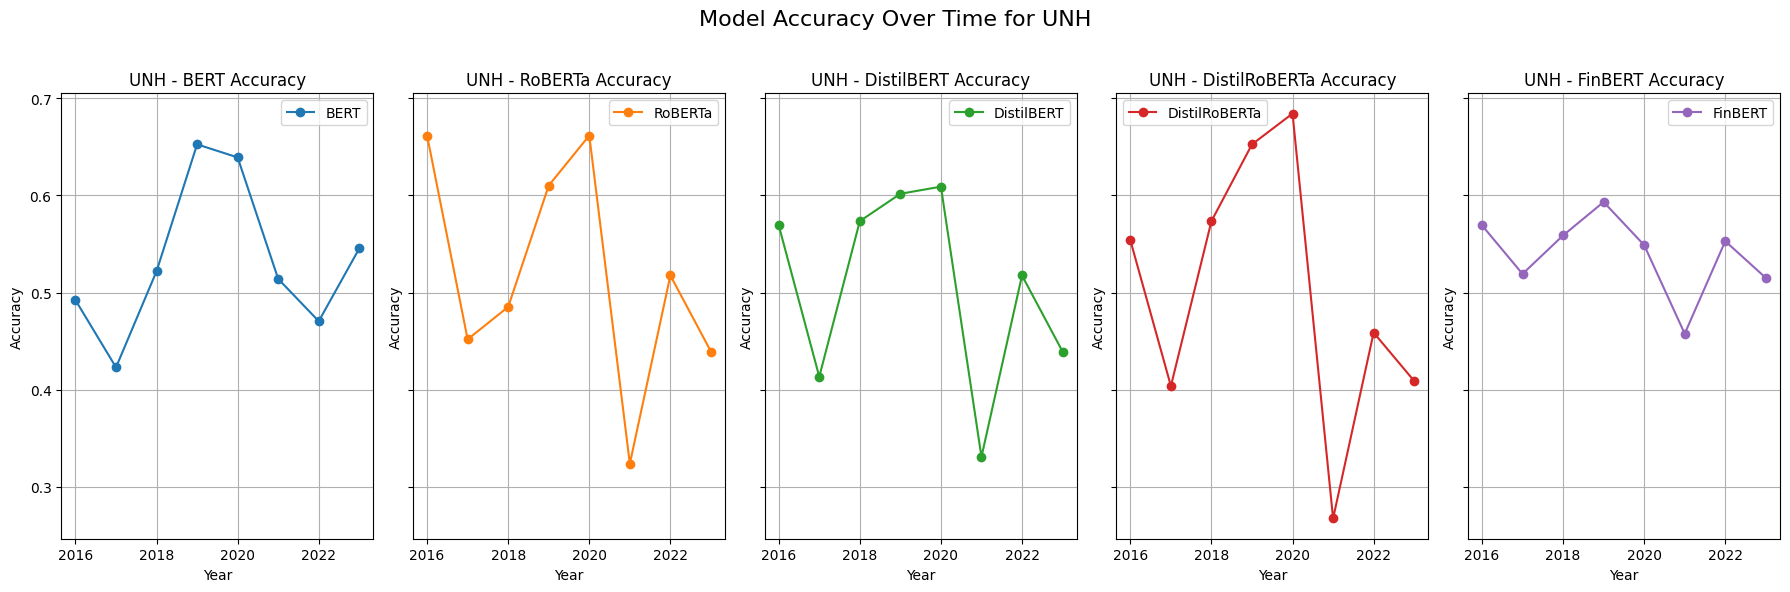

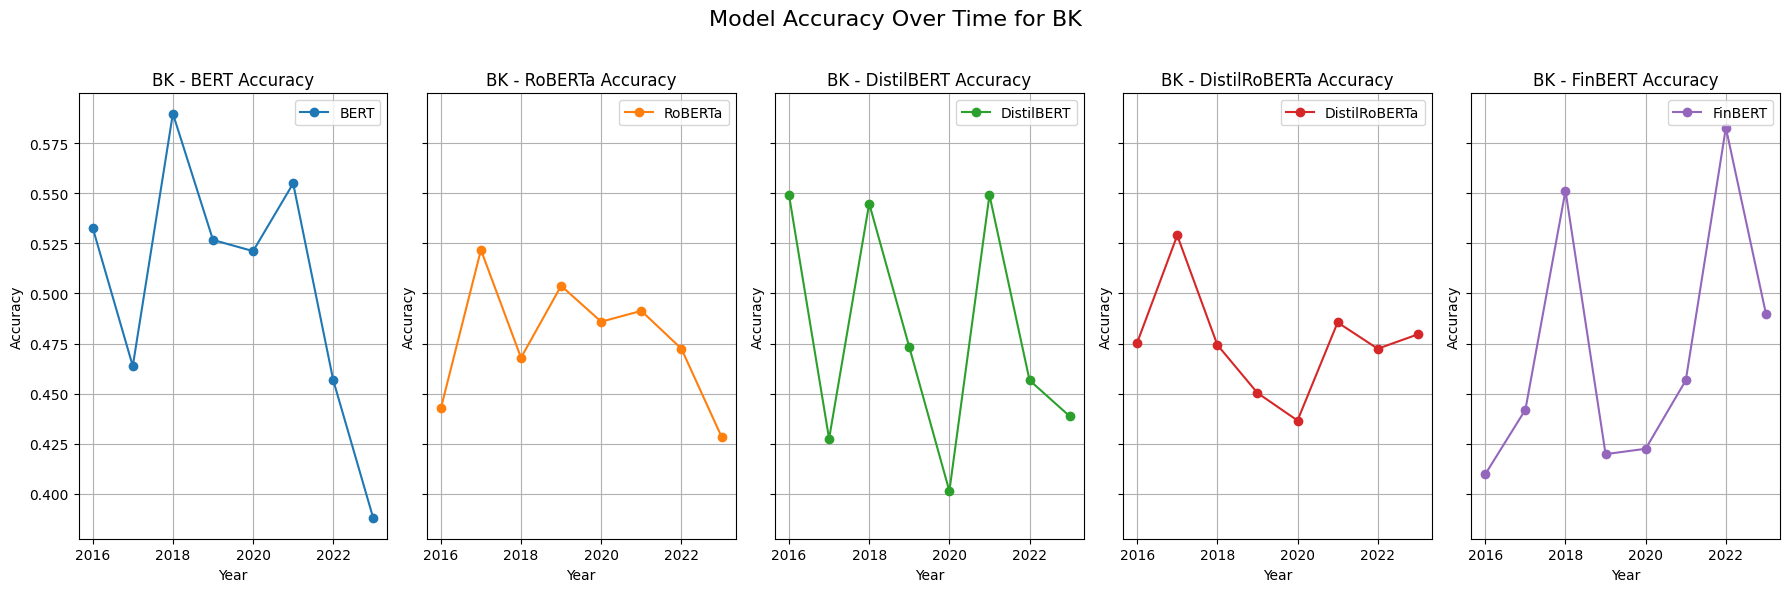

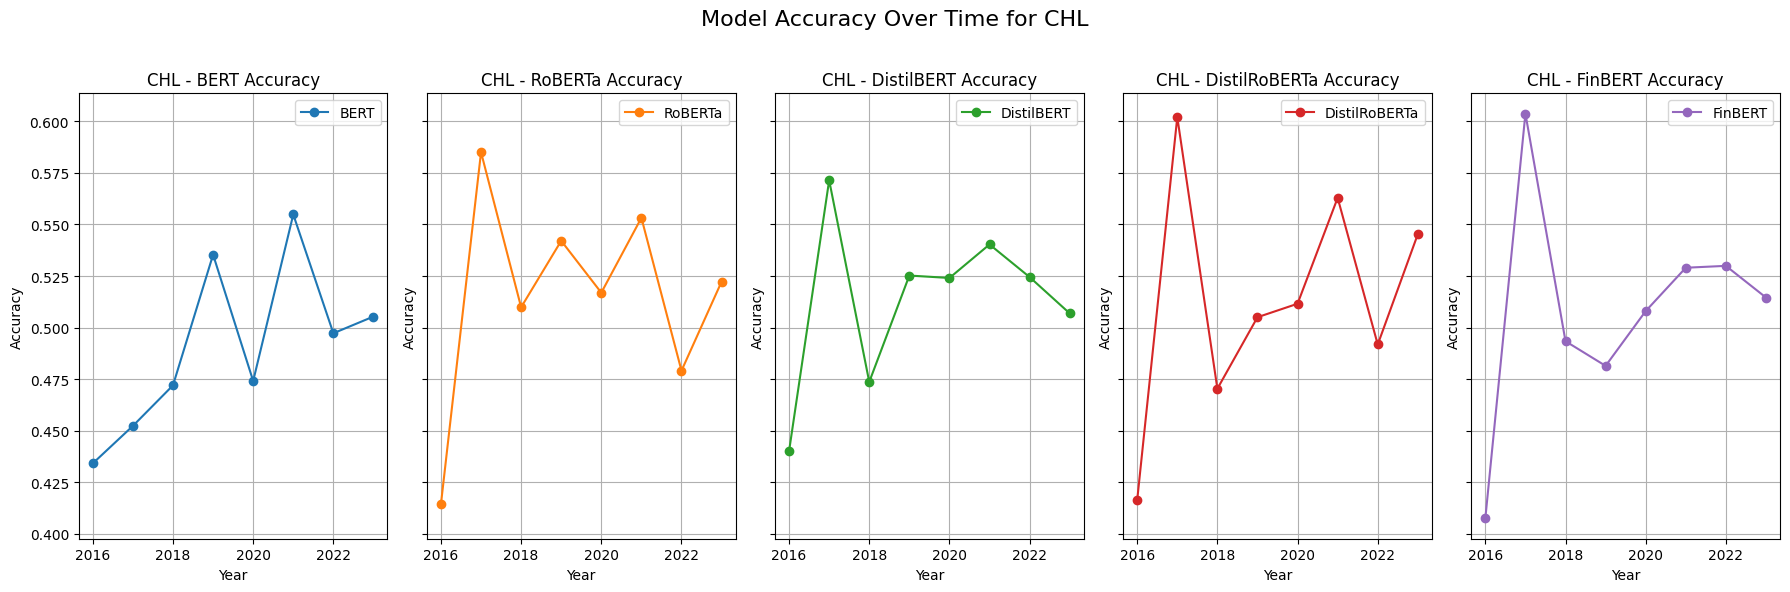

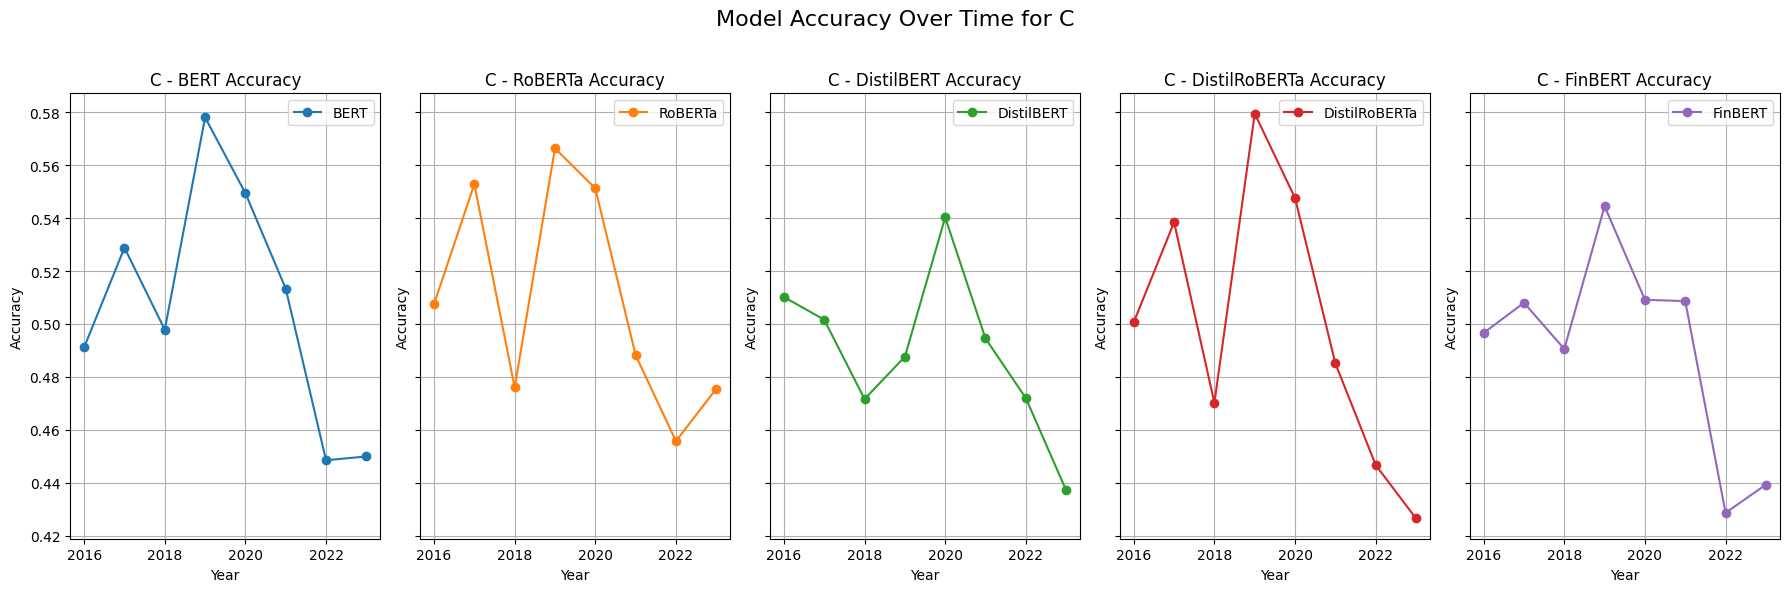

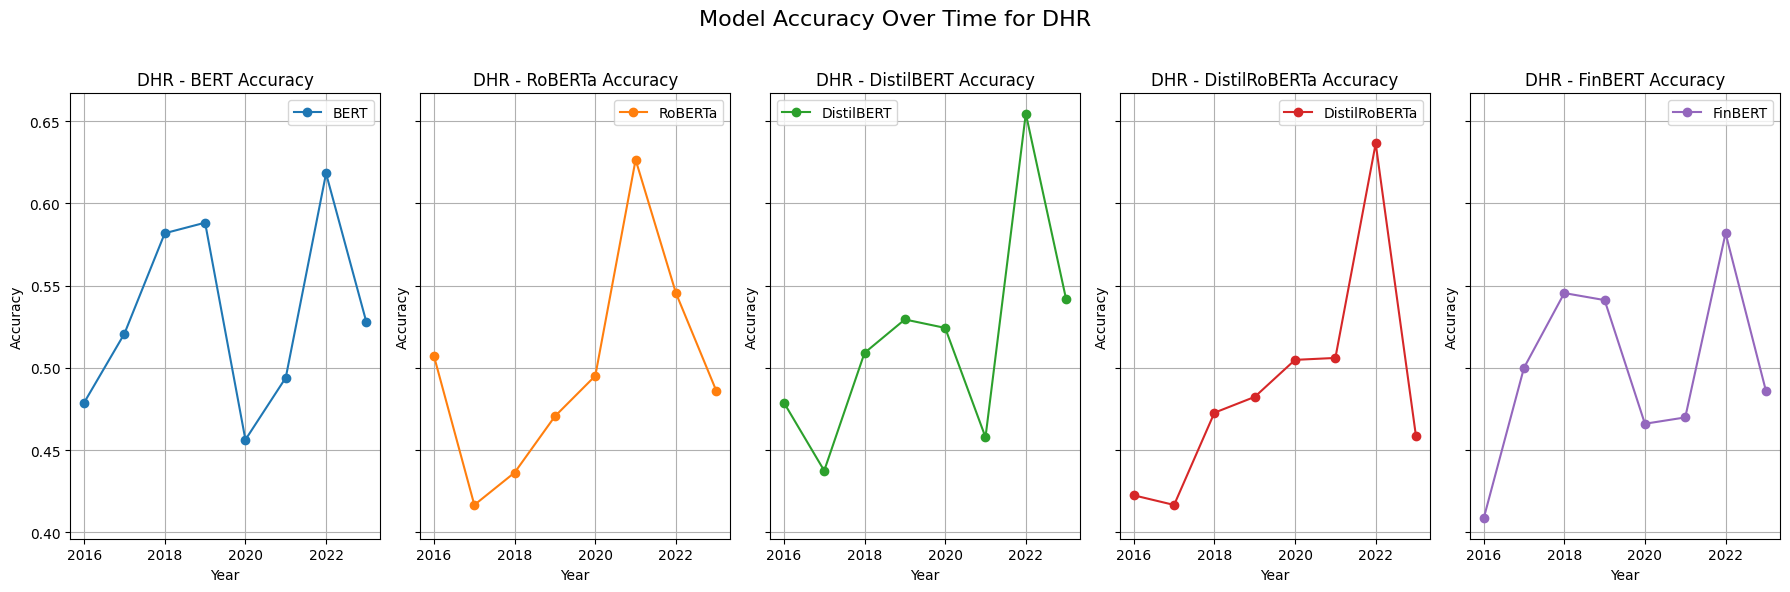

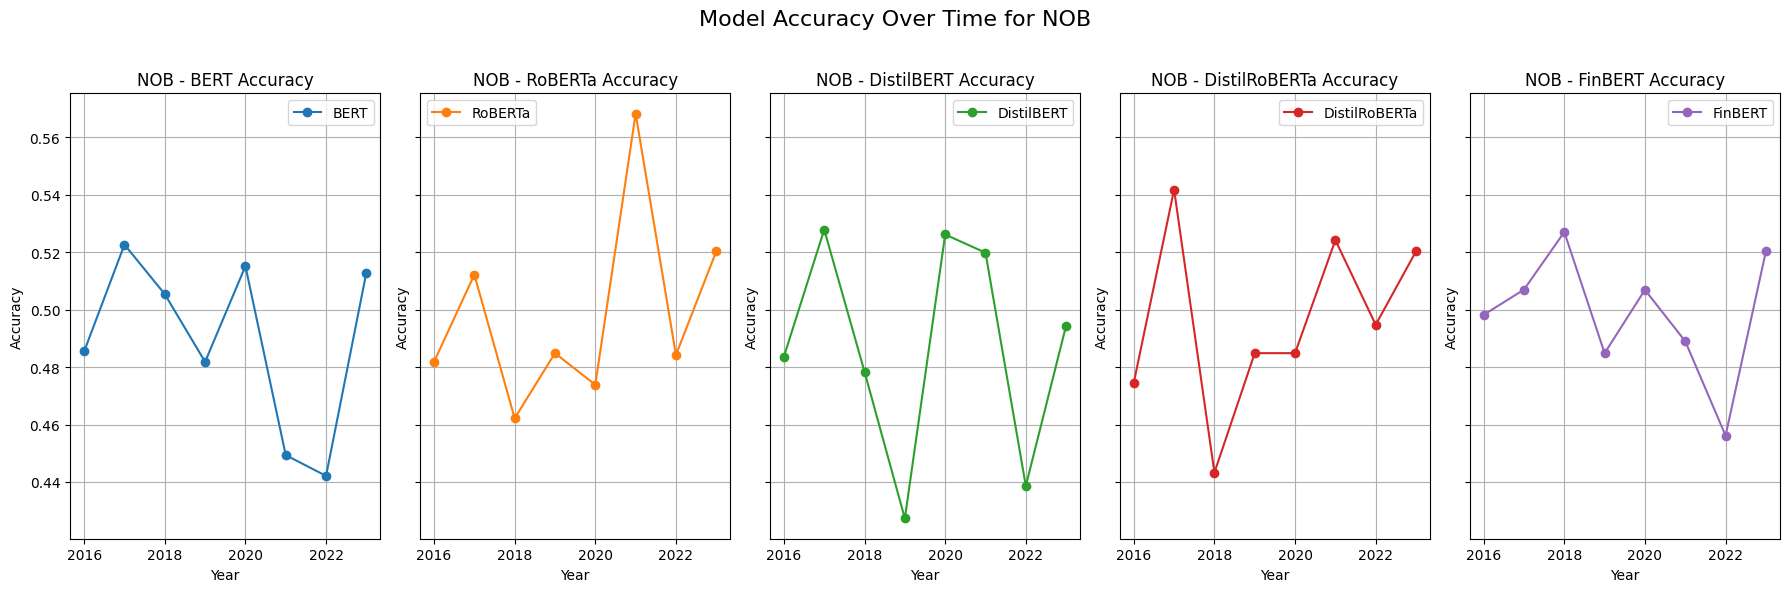

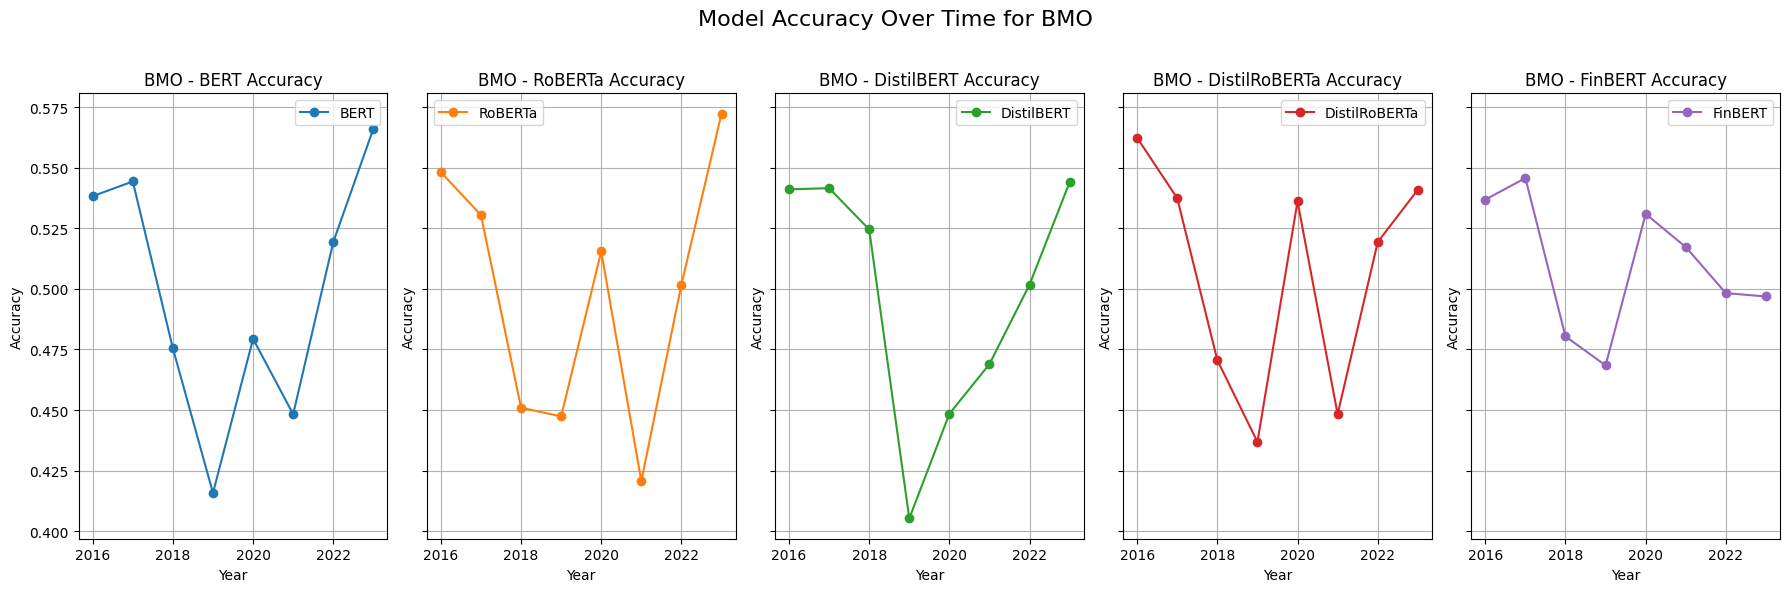

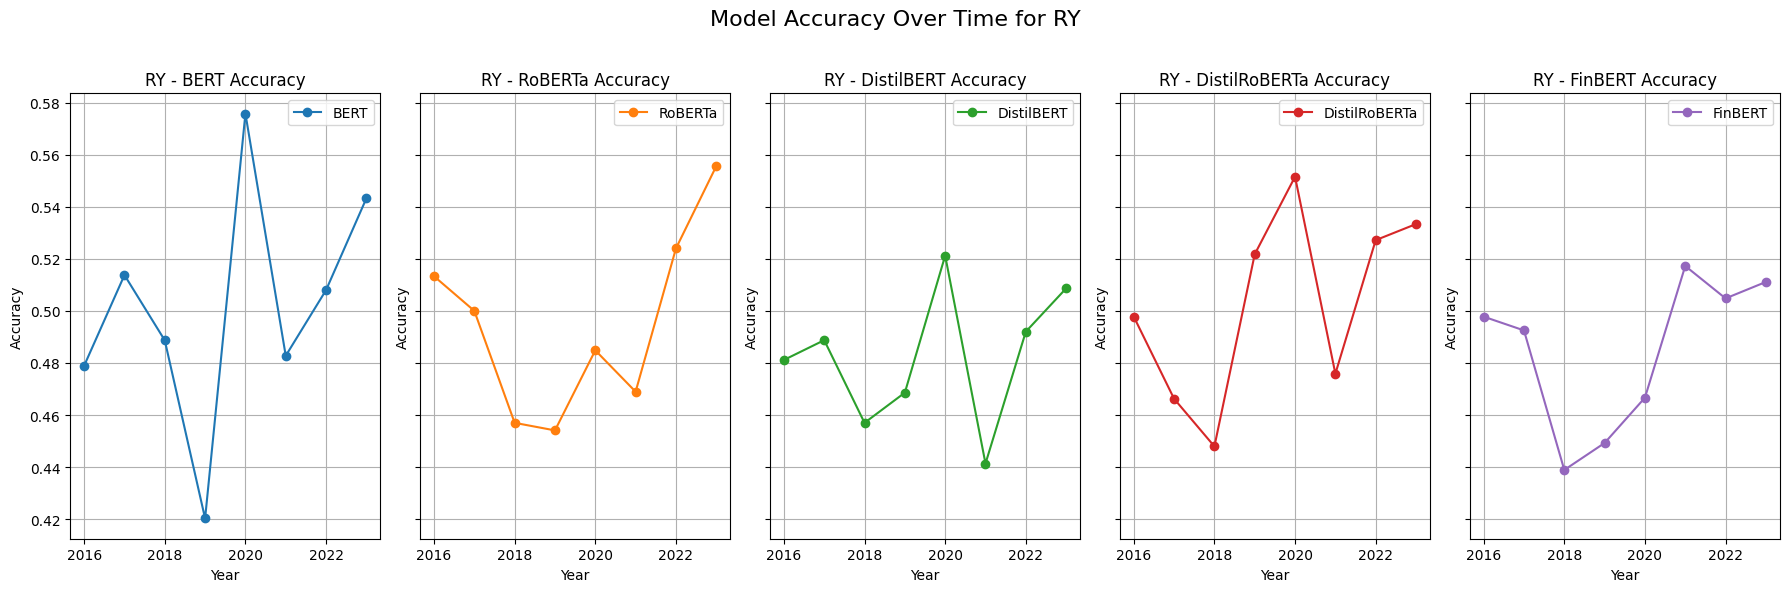

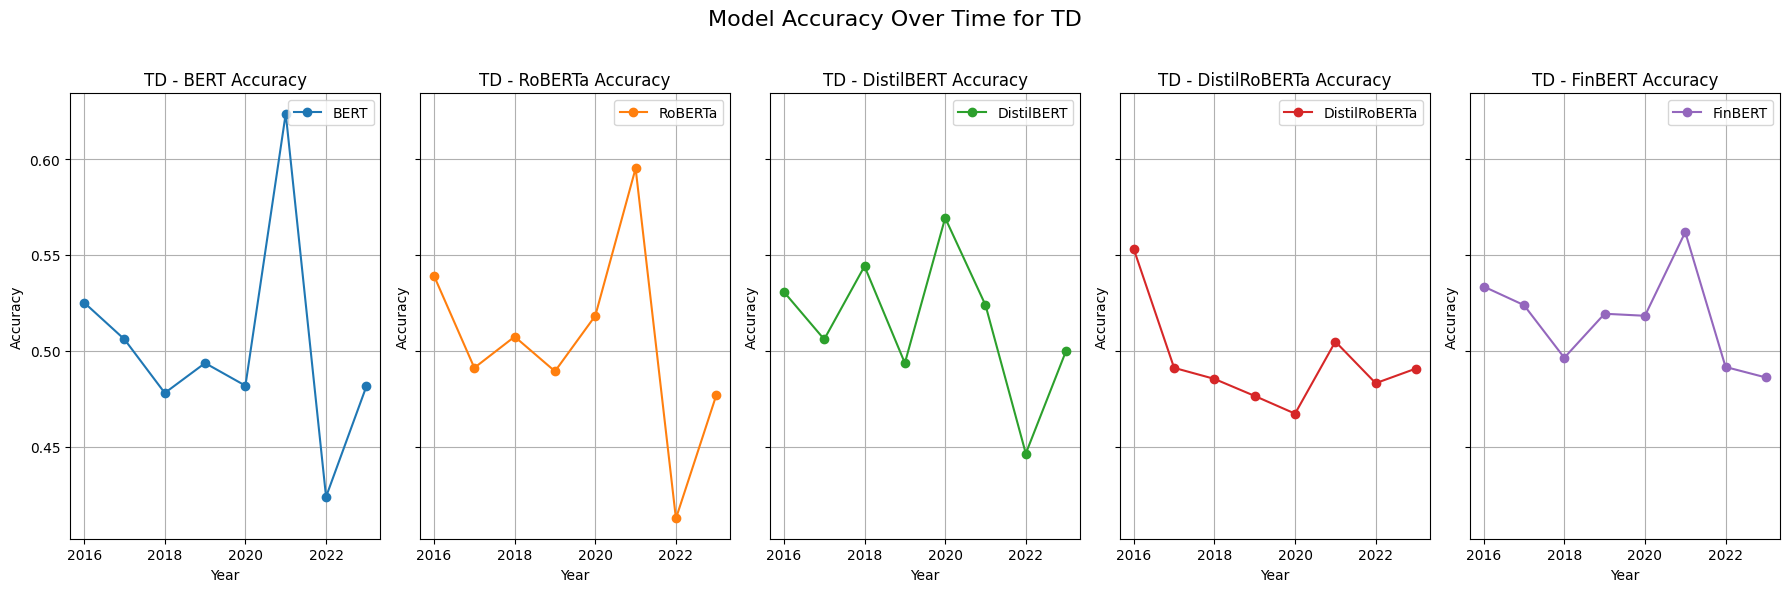

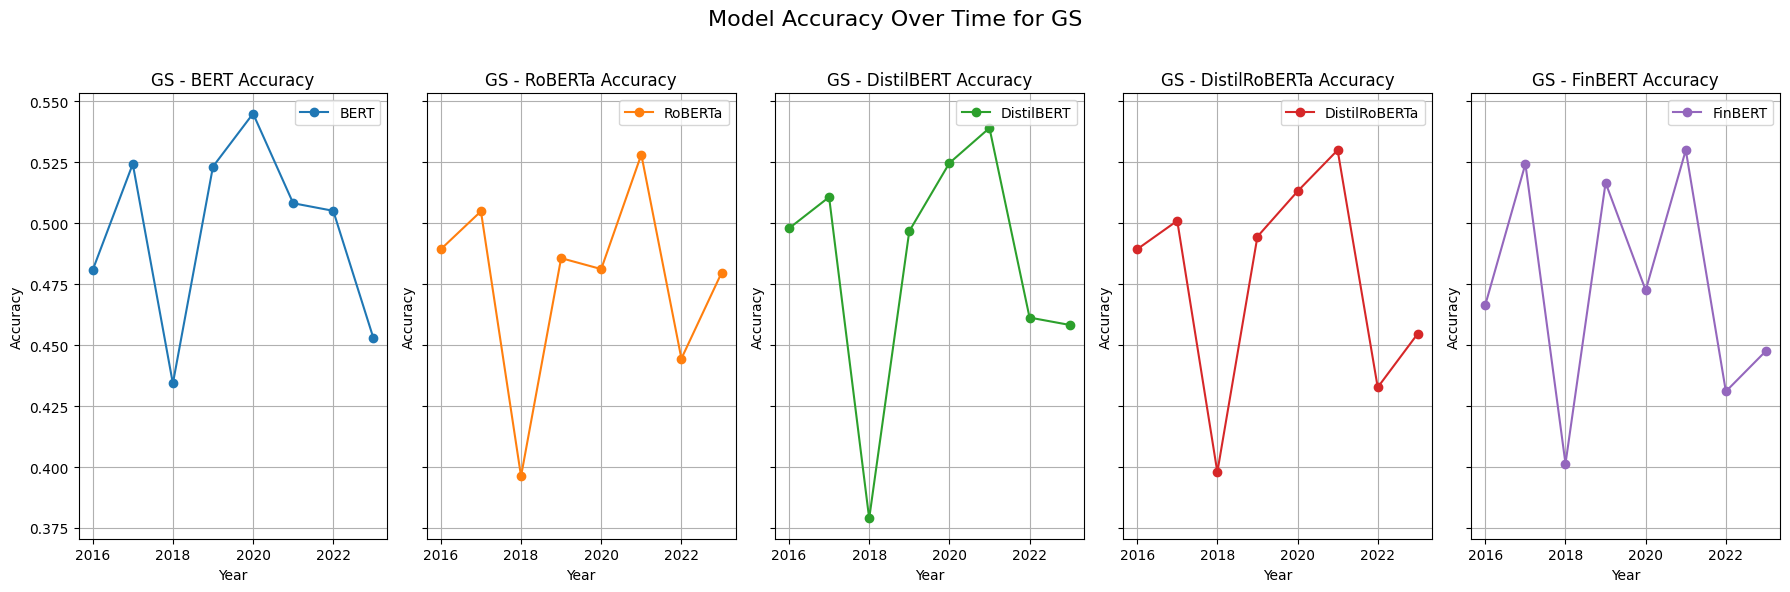

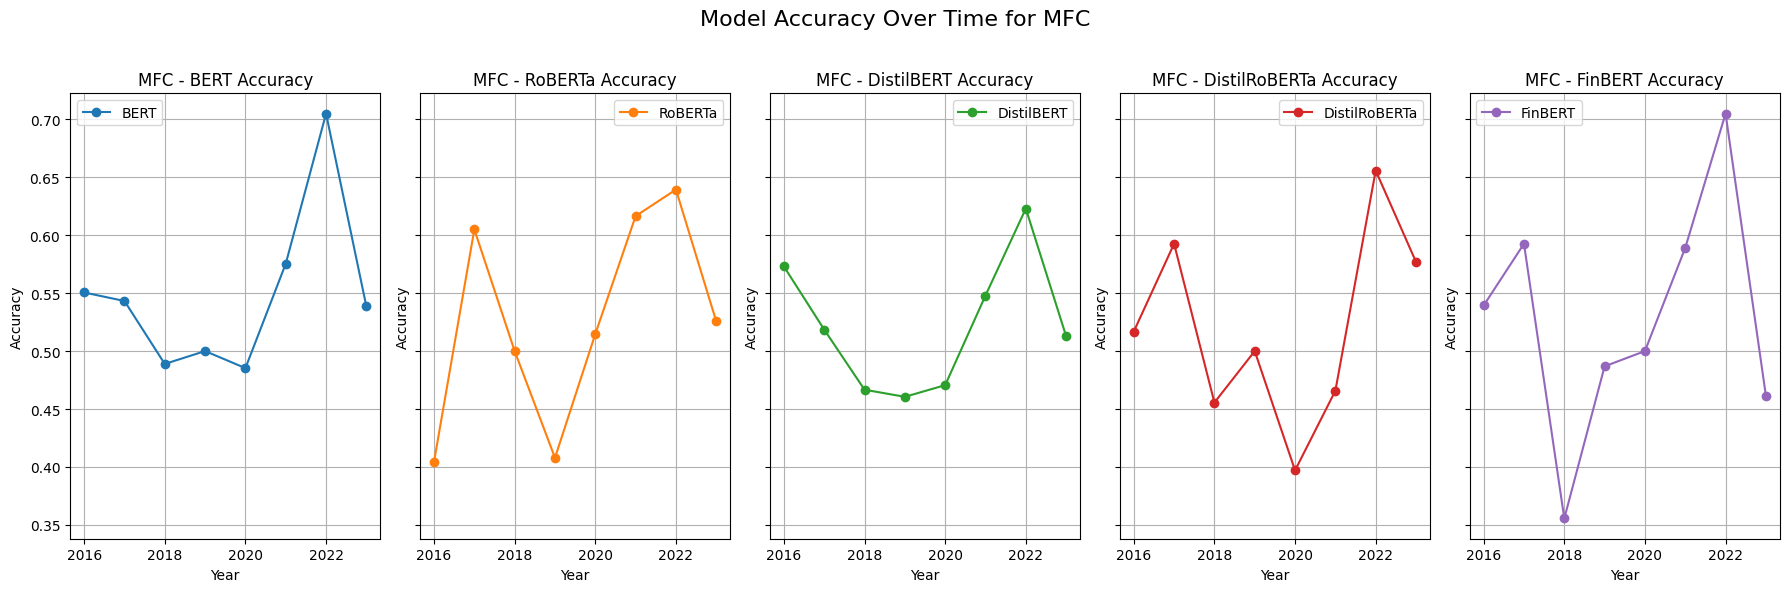

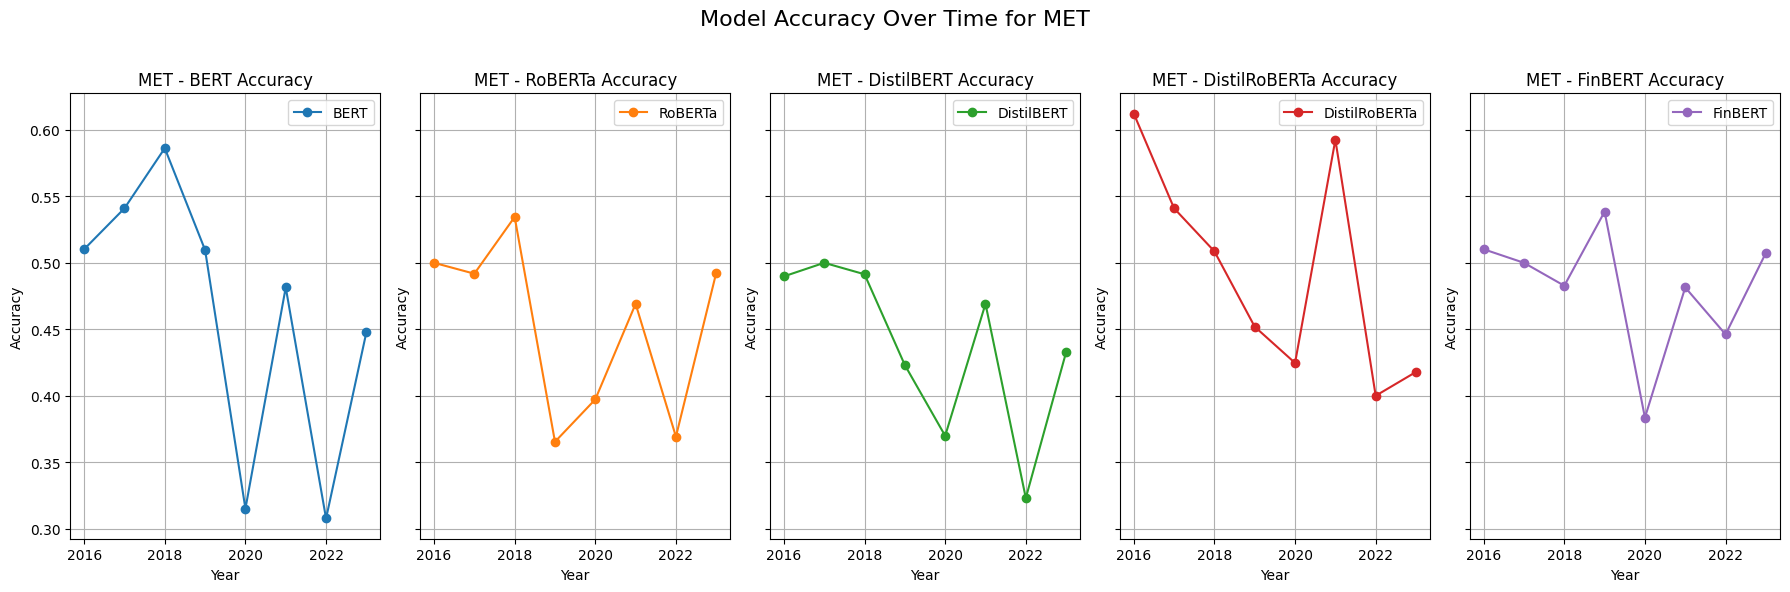

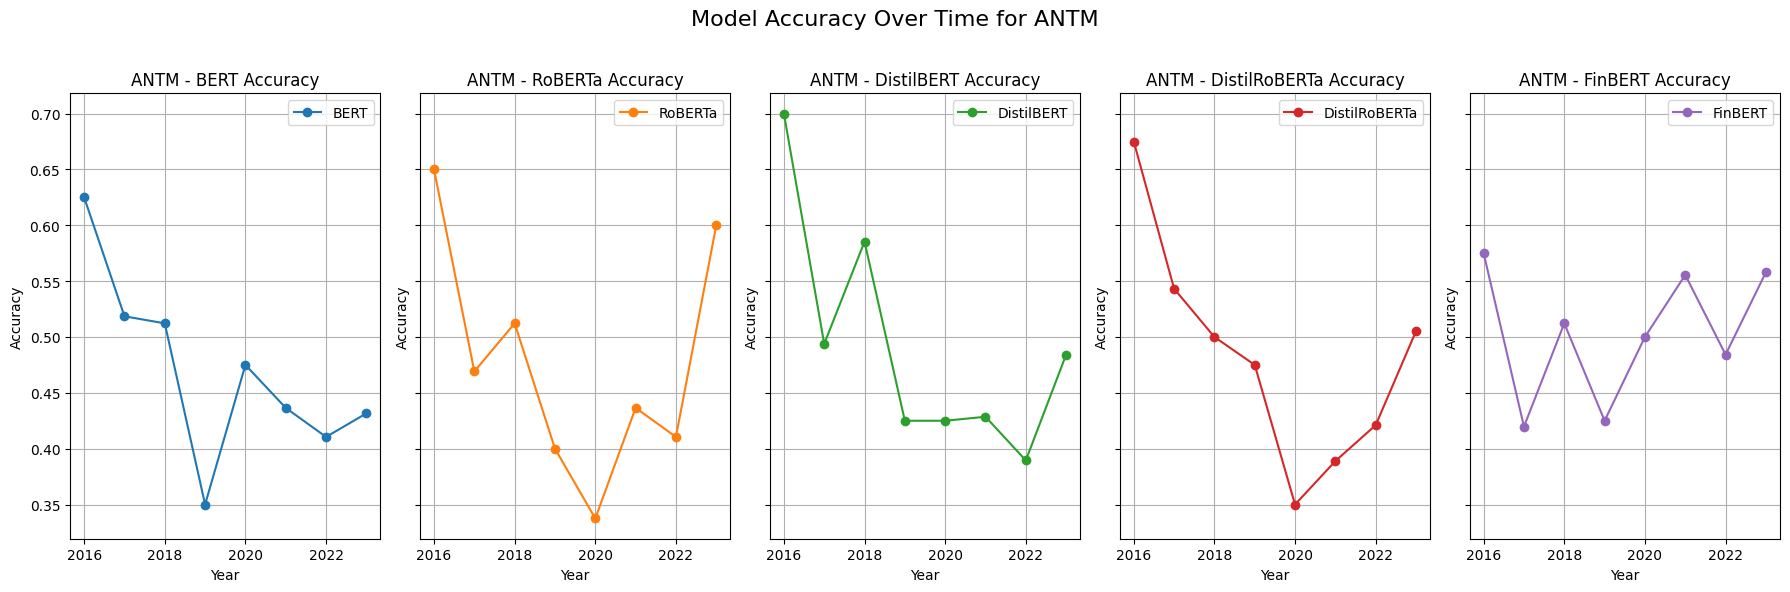

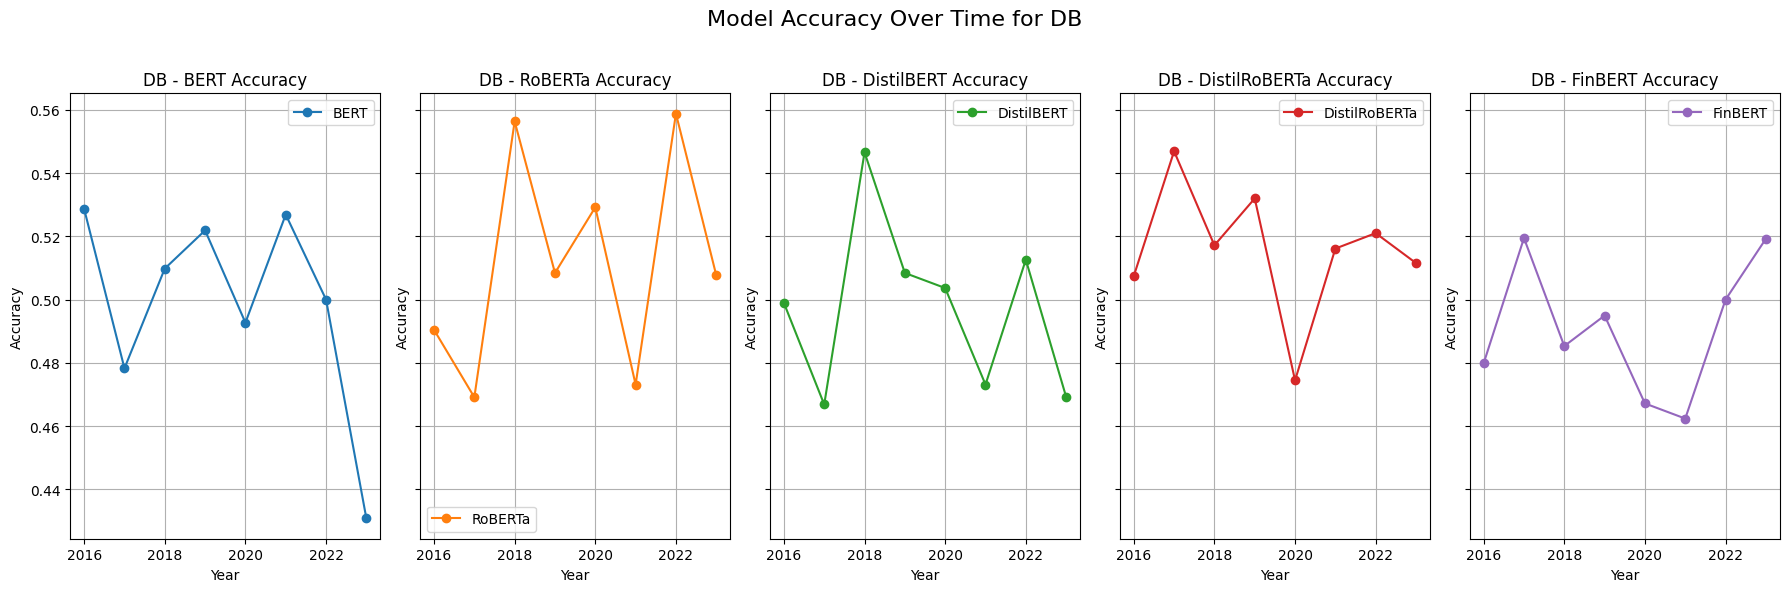

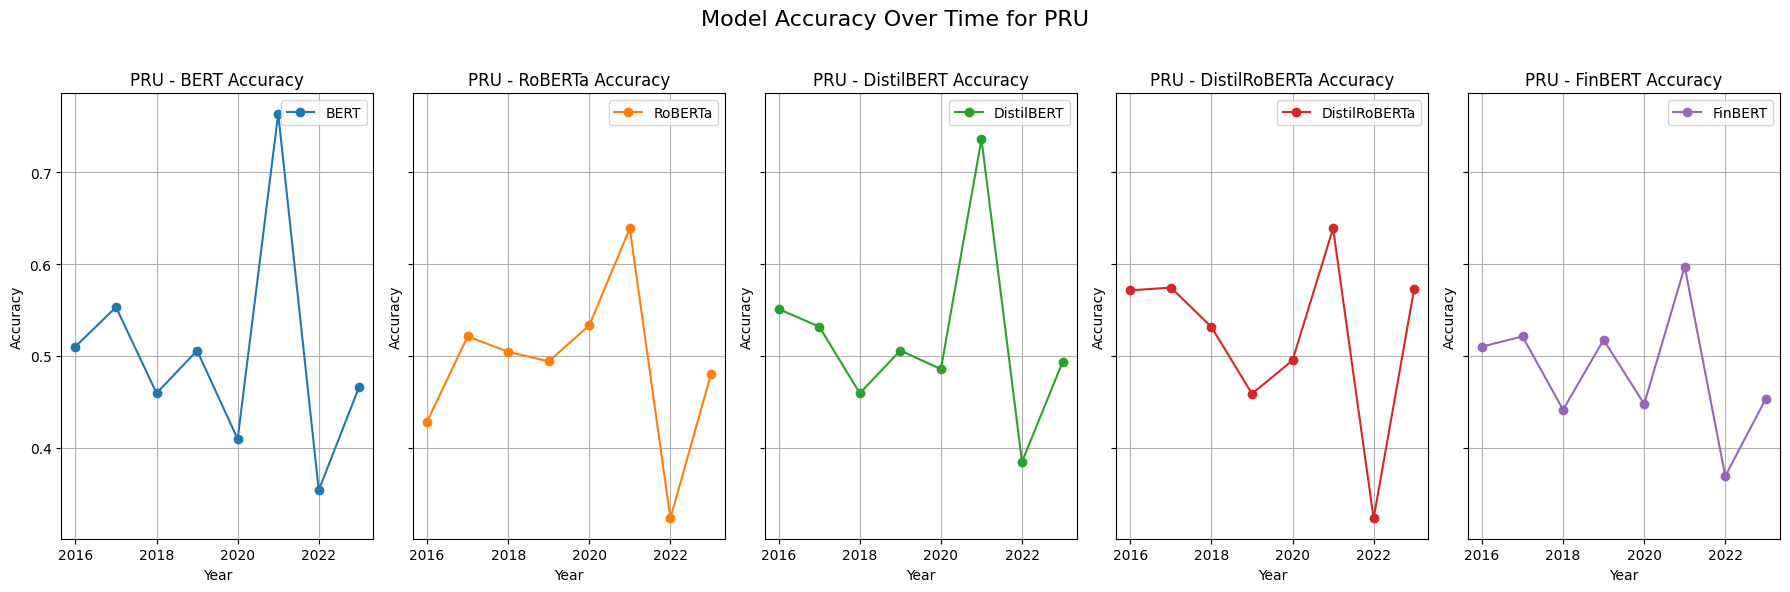

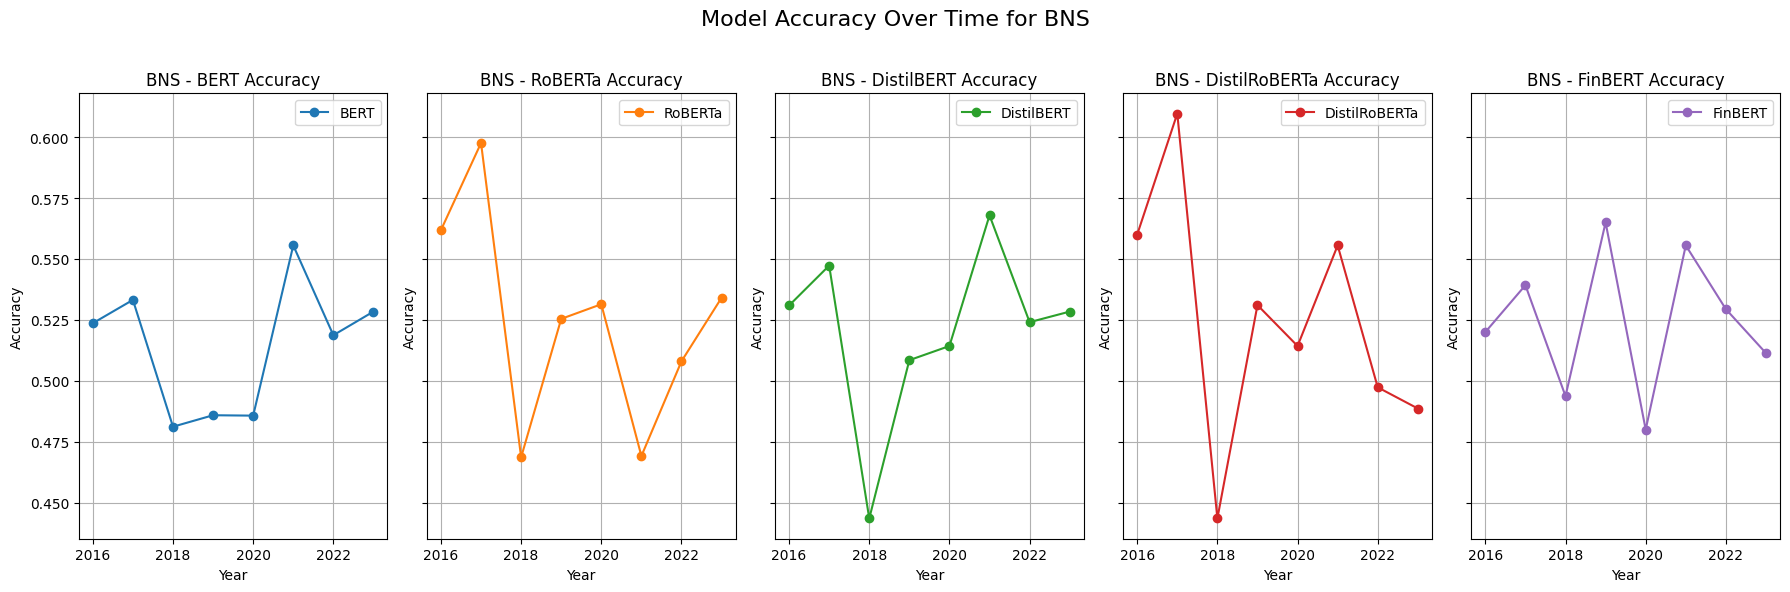

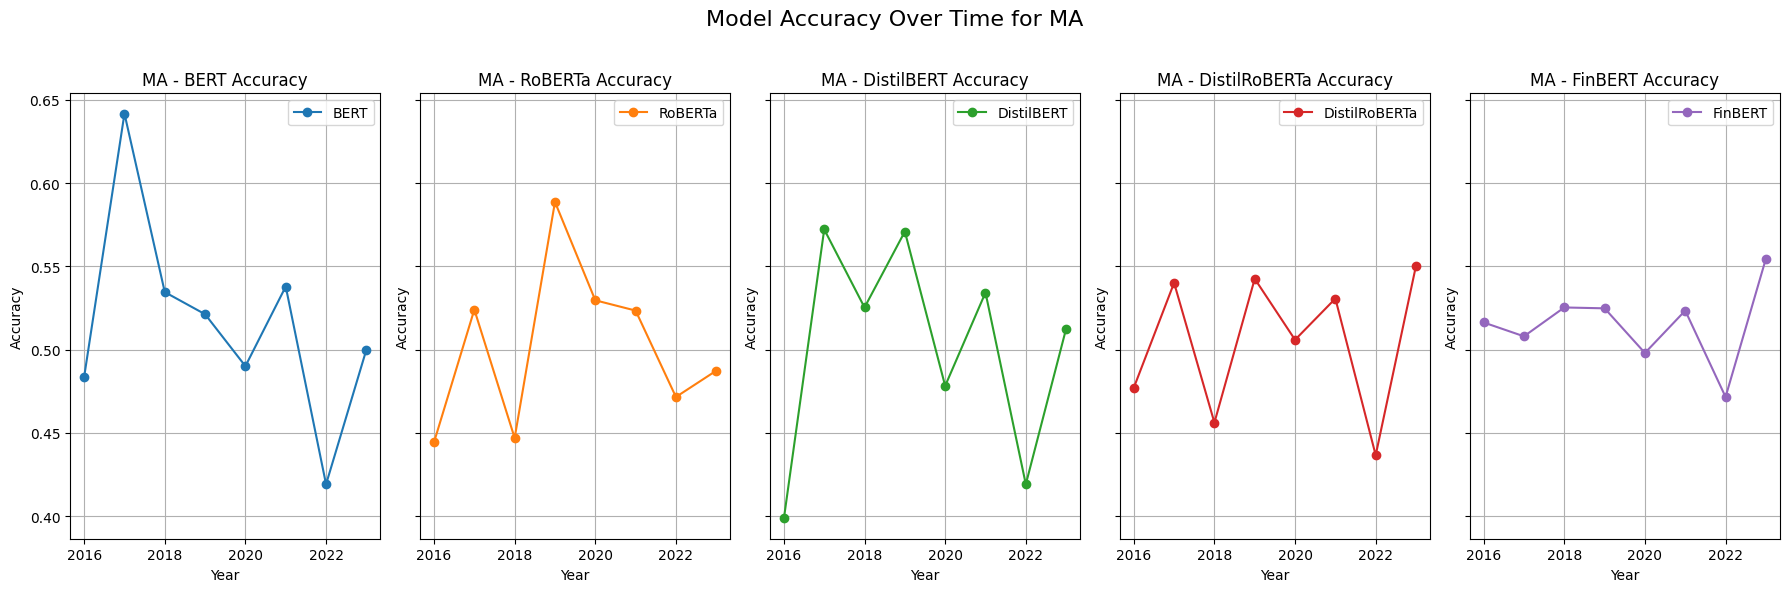

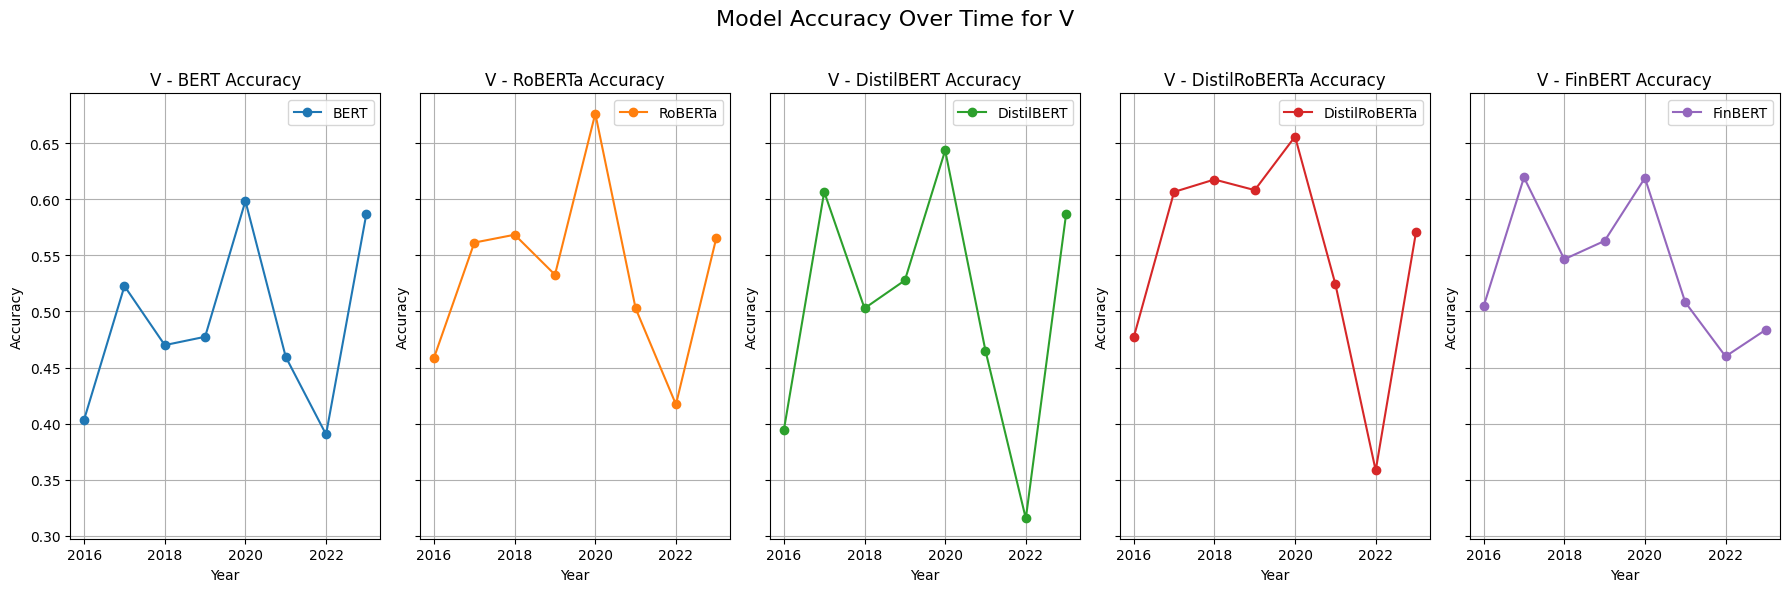

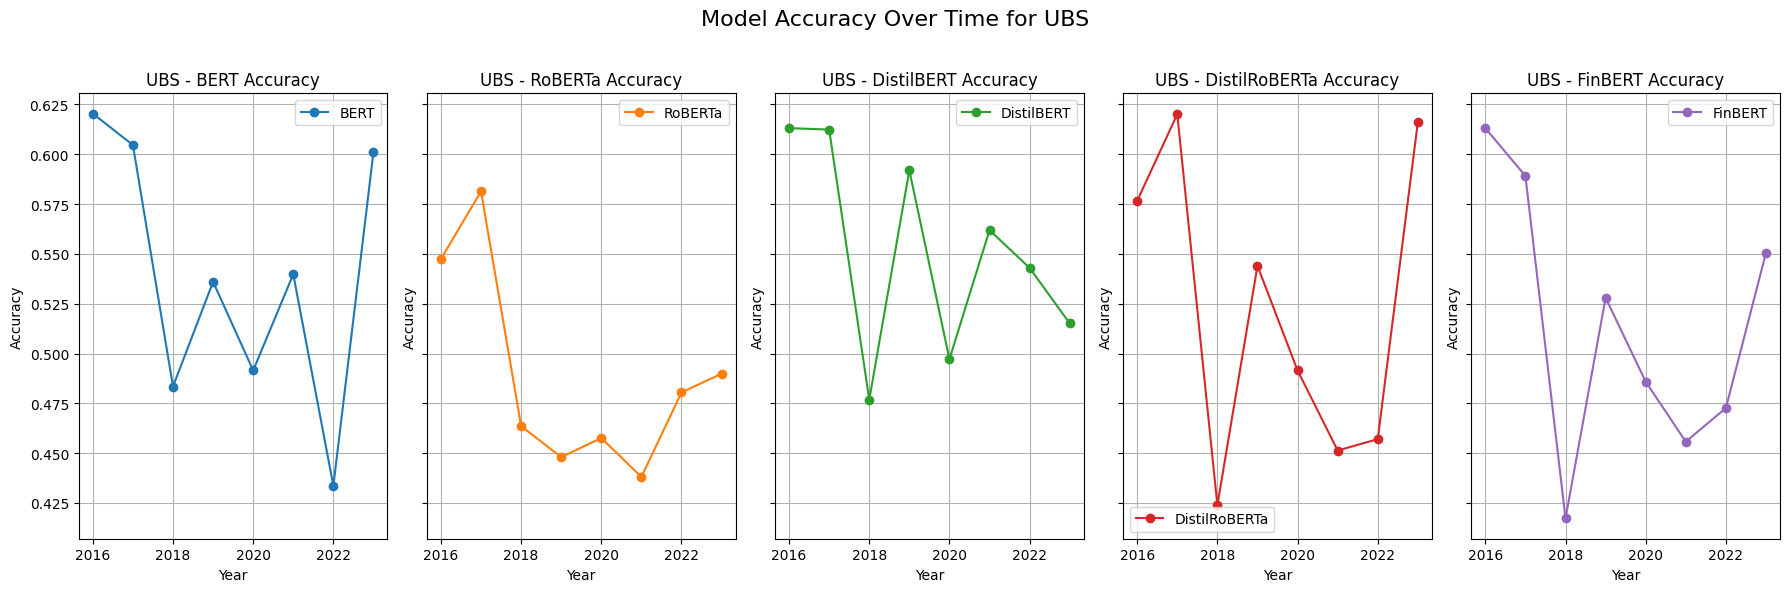

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract unique tickers from the DataFrame
tickers = finalv2['ticker'].unique()

# Extract models
models = ['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']

# Loop through each ticker
for ticker in tickers:
    # Filter DataFrame for the current ticker
    ticker_df = finalv2[finalv2['ticker'] == ticker]

    # Plotting using matplotlib
    fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(18, 6), sharey=True)

    # Iterate over each model
    for i, model in enumerate(models):
        ax = axes[i]
        model_data = ticker_df[['year', model]]
        ax.plot(model_data['year'], model_data[model], marker='o', color=f'C{i}', label=model)
        ax.set_xlabel('Year')
        ax.set_ylabel('Accuracy')
        ax.set_title(f'{ticker} - {model} Accuracy')
        ax.grid(True)
        ax.legend()

    # Adjust layout and show the plot for the current ticker
    plt.suptitle(f'Model Accuracy Over Time for {ticker}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()


####Mean Accuracies and Best model - Yearwise

In [ ]:
# Compute the mean accuracy for each year for every model
mean_accuracies = final.groupby('year').mean().reset_index()

# Find the best model for each year
mean_accuracies['Best Model'] = mean_accuracies[['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']].idxmax(axis=1)

mean_accuracies = mean_accuracies[['year','BERT','RoBERTa','DistilBERT','DistilRoBERTa','FinBERT','Best Model']]

In [ ]:
mean_accuracies

year      BERT   RoBERTa  DistilBERT  DistilRoBERTa   FinBERT  \
0  2016  0.509634  0.496169    0.517349       0.506512  0.495096   
1  2017  0.514070  0.514496    0.512160       0.527953  0.518220   
2  2018  0.504450  0.497570    0.497768       0.492674  0.496387   
3  2019  0.505656  0.495763    0.496987       0.505941  0.515358   
4  2020  0.495708  0.519751    0.501201       0.501259  0.493619   
5  2021  0.537141  0.504727    0.516788       0.509768  0.510608   
6  2022  0.473598  0.480019    0.481104       0.484795  0.497468   
7  2023  0.500641  0.508691    0.488213       0.502776  0.505101   

      Best Model  
0     DistilBERT  
1  DistilRoBERTa  
2           BERT  
3        FinBERT  
4        RoBERTa  
5           BERT  
6        FinBERT  
7        RoBERTa

#### Mean Accuracy - Year wise visualisation

In [ ]:
df_long = mean_accuracies

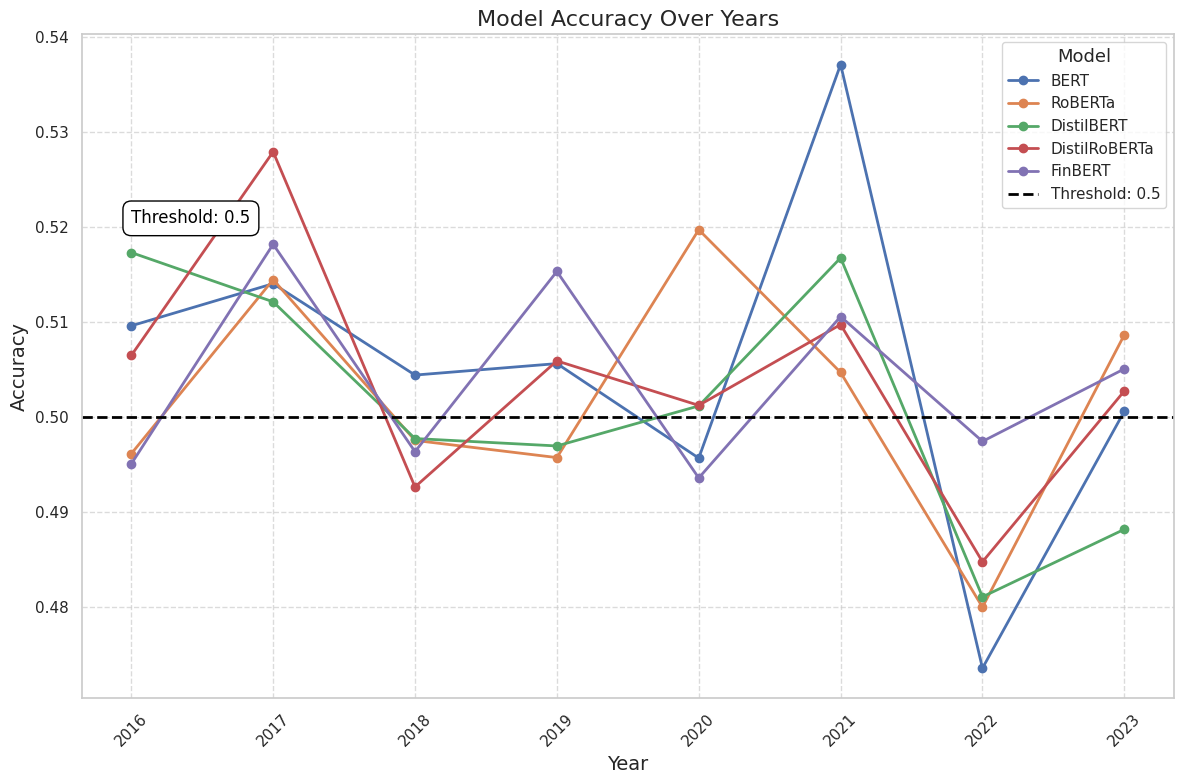

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample threshold value
threshold_value = 0.5

# Drop 'Best Model' column if it exists (uncomment if needed)
mean_accuracies_without_best = mean_accuracies.drop(columns=['Best Model'], errors='ignore')

# Melt the DataFrame to a long format
df_long = mean_accuracies_without_best.melt(id_vars='year', var_name='Model', value_name='Accuracy')

# Set up the matplotlib figure and seaborn style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot each model's accuracy over the years
for model in df_long['Model'].unique():
    model_data = df_long[df_long['Model'] == model]
    plt.plot(model_data['year'], model_data['Accuracy'], marker='o', linestyle='-', label=model, linewidth=2)

# Add a horizontal threshold line with enhanced styling
plt.axhline(y=threshold_value, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold_value}')

# Annotate the threshold line
plt.text(df_long['year'].min(), threshold_value + 0.02, f'Threshold: {threshold_value}',
         color='black', fontsize=12, ha='left', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Add title and labels
plt.title('Model Accuracy Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(title='Model', title_fontsize='13', fontsize='11')
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust x-axis ticks for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

####Overall Model Accuracies

In [ ]:
# Compute the mean accuracy for each model
mean_model_accuracies = mean_accuracies[['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']].mean().reset_index()

# Rename columns for clarity
mean_model_accuracies.columns = ['Model', 'Mean Accuracy']

mean_model_accuracies

Model  Mean Accuracy
0           BERT       0.505112
1        RoBERTa       0.502148
2     DistilBERT       0.501446
3  DistilRoBERTa       0.503960
4        FinBERT       0.503982

####Ticker-wise accuracy and best model

In [ ]:
# Group by permco and calculate the mean for each model
mean_accuracies_permco = final.groupby('permco').mean().reset_index()

# Drop the 'year' column as it's not needed for the mean calculation
mean_accuracies_permco = mean_accuracies_permco.drop(columns=['year'])


# Merge the mapping with the final accuracy dataframe
mean_accuracies_permco = mean_accuracies_permco.merge(permco_to_ticker, on='permco', how='left')
mean_accuracies_permco = mean_accuracies_permco[['ticker','BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']]

# Find the best model for each year
mean_accuracies_permco['Best Model'] = mean_accuracies_permco[['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']].idxmax(axis=1)

mean_accuracies_permco

ticker      BERT   RoBERTa  DistilBERT  DistilRoBERTa   FinBERT  \
0    AEXP  0.512051  0.530262    0.494579       0.497071  0.529198   
1     AIG  0.506567  0.529774    0.512226       0.512005  0.503940   
2     BRK  0.482806  0.491556    0.482636       0.497583  0.510426   
3     USB  0.535078  0.530547    0.532314       0.524017  0.496387   
4     BAC  0.491454  0.471312    0.497569       0.475234  0.484029   
5     UNH  0.532401  0.518945    0.506871       0.500437  0.539402   
6      BK  0.504188  0.476798    0.480110       0.475417  0.471831   
7     CHL  0.490705  0.515374    0.513290       0.513193  0.508469   
8       C  0.507134  0.509182    0.489360       0.499333  0.490659   
9     DHR  0.533251  0.497985    0.516649       0.487482  0.499864   
10    NOB  0.489355  0.498455    0.487027       0.496070  0.498667   
11    BMO  0.498355  0.498402    0.496950       0.506461  0.509327   
12     RY  0.501422  0.494719    0.482345       0.502700  0.484785   
13     TD  0.501660  0.503683    0.514230       0.493937  0.516336   
14     GS  0.496691  0.476164    0.483415       0.476629  0.473710   
15    MFC  0.548335  0.526682    0.521631       0.520059  0.528727   
16    MET  0.462377  0.452479    0.437395       0.493617  0.481260   
17   ANTM  0.469916  0.476983    0.491431       0.482302  0.503701   
18     DB  0.498621  0.511647    0.497418       0.515827  0.491034   
19    PRU  0.502833  0.490471    0.518506       0.520849  0.482247   
20    BNS  0.514035  0.524515    0.520605       0.525006  0.524283   
21     MA  0.516056  0.502036    0.501441       0.504965  0.515282   
22      V  0.488592  0.535280    0.505261       0.552256  0.537969   
23    UBS  0.538811  0.488308    0.551451       0.522586  0.514037   

       Best Model  
0         RoBERTa  
1         RoBERTa  
2         FinBERT  
3            BERT  
4      DistilBERT  
5         FinBERT  
6            BERT  
7         RoBERTa  
8         RoBERTa  
9            BERT  
10        FinBERT  
11        FinBERT  
12  DistilRoBERTa  
13        FinBERT  
14           BERT  
15           BERT  
16  DistilRoBERTa  
17        FinBERT  
18  DistilRoBERTa  
19  DistilRoBERTa  
20  DistilRoBERTa  
21           BERT  
22  DistilRoBERTa  
23     DistilBERT

####Combined Accuracies by Ticker

In [ ]:
import numpy as np

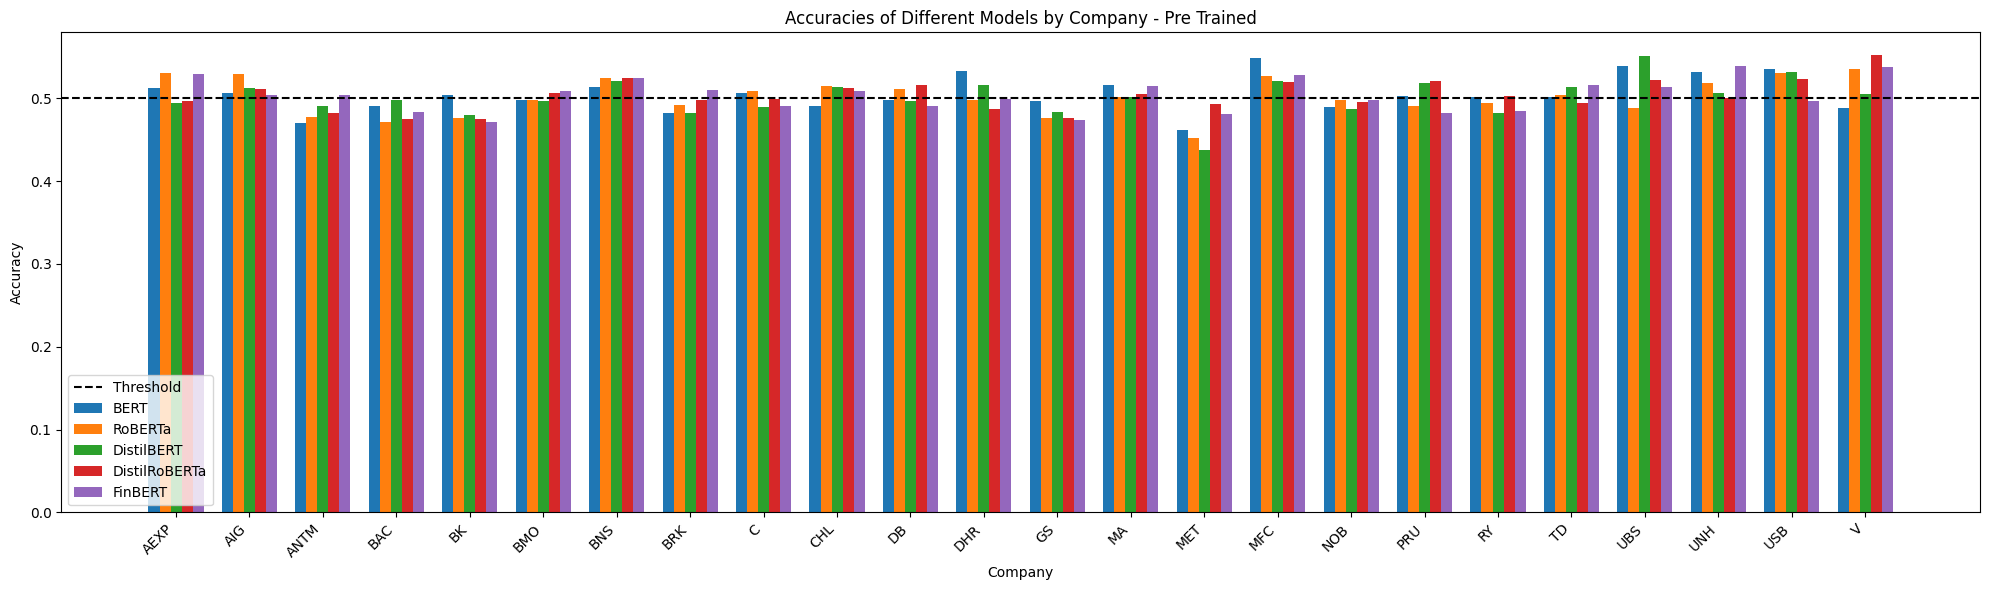

In [ ]:
# Filter out rows where all accuracies are NaN
merged_df = mean_accuracies_permco.dropna(subset=['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT'], how='all')

# Sort by 'ticker' for better visualization
merged_df = merged_df.sort_values(by='ticker')

# Prepare data for plotting
models = ['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']
x = np.arange(len(merged_df['ticker']))  # the label locations
width = 0.15  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(20, 6))

# Plot each model's bar
for i, model in enumerate(models):
    ax.bar(x + i*width, merged_df[model], width, label=model)

# Add a threshold line
threshold = 0.5
ax.axhline(y=threshold, color='black', linestyle='--', label='Threshold')

# Customize the plot
ax.set_title('Accuracies of Different Models by Company - Pre Trained')
ax.set_xlabel('Company')
ax.set_ylabel('Accuracy')
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(merged_df['ticker'], rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

####Frequency of Best Model

In [ ]:
import plotly.express as px
import pandas as pd

fig = px.histogram(
    mean_accuracies_permco,
    x='Best Model',
    title='Frequency of Best Models',
    labels={'Best Model': 'Model', 'count': 'Count'},
    color='Best Model'
)

# Adjust the size
fig.update_layout(
    width=800,
    height=600
)

# Show the count on top of each bin
fig.update_traces(texttemplate='%{y}', textposition='outside')

fig.show()

#Market Analysis

In [ ]:
market = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/data/market.csv')

In [ ]:
market

caldt    vwretx    ewretx        totval  totcnt        usdval  \
0     2016-01-04 -0.015417 -0.011994  1.833036e+10     504  1.861740e+10   
1     2016-01-05  0.002129  0.001825  1.838508e+10     504  1.833036e+10   
2     2016-01-06 -0.012912 -0.018427  1.814769e+10     504  1.838508e+10   
3     2016-01-07 -0.023461 -0.022467  1.772125e+10     504  1.814769e+10   
4     2016-01-08 -0.010901 -0.011437  1.752809e+10     504  1.772125e+10   
...          ...       ...       ...           ...     ...           ...   
2007  2023-12-22  0.001708  0.003380  4.154371e+10     503  4.147289e+10   
2008  2023-12-26  0.004203  0.005948  4.171833e+10     503  4.154371e+10   
2009  2023-12-27  0.001366  0.001170  4.177533e+10     503  4.171833e+10   
2010  2023-12-28  0.000299  0.001219  4.178781e+10     503  4.177533e+10   
2011  2023-12-29 -0.002847 -0.003685  4.166365e+10     503  4.178781e+10   

      usdcnt   spindx    sprtrn  
0        504  2012.66 -0.015304  
1        504  2016.71  0.002012  
2        504  1990.26 -0.013115  
3        504  1943.09 -0.023700  
4        504  1922.03 -0.010838  
...      ...      ...       ...  
2007     503  4754.63  0.001660  
2008     503  4774.75  0.004232  
2009     503  4781.58  0.001430  
2010     503  4783.35  0.000370  
2011     503  4769.83 -0.002826  

[2012 rows x 9 columns]

In [ ]:
import numpy as np
# Convert 'caldt' to datetime
market['caldt'] = pd.to_datetime(market['caldt'])

# Group by weekly frequency ending on Friday
weekly_market_data = market.groupby(pd.Grouper(key='caldt', freq='W-FRI')).agg({
    'vwretx': (lambda x: (np.exp(np.sum(np.log(1 + x))) - 1) * 100),  # Weekly return calculation for value-weighted returns
    'ewretx': (lambda x: (np.exp(np.sum(np.log(1 + x))) - 1) * 100)   # Weekly return calculation for equal-weighted returns
}).reset_index()

# Rename columns for clarity
weekly_market_data.rename(columns={'caldt': 'end_date', 'vwretx': 'weekly_vwret', 'ewretx': 'weekly_ewret'}, inplace=True)

# Add start_date column (beginning of the week)
weekly_market_data['start_date'] = weekly_market_data['end_date'] - pd.DateOffset(days=4)

# Display the resulting DataFrame
weekly_market_data = weekly_market_data[['start_date','end_date','weekly_ewret','weekly_vwret']]
weekly_market_data

start_date   end_date  weekly_ewret  weekly_vwret
0   2016-01-04 2016-01-08     -6.112056     -5.927824
1   2016-01-11 2016-01-15     -3.050724     -2.194547
2   2016-01-18 2016-01-22      1.547831      1.433335
3   2016-01-25 2016-01-29      1.998039      1.762255
4   2016-02-01 2016-02-05     -2.430050     -3.136766
..         ...        ...           ...           ...
412 2023-11-27 2023-12-01      2.380663      0.770844
413 2023-12-04 2023-12-08     -0.035692      0.213273
414 2023-12-11 2023-12-15      3.905680      2.431286
415 2023-12-18 2023-12-22      0.780669      0.776291
416 2023-12-25 2023-12-29      0.463686      0.301168

[417 rows x 4 columns]

In [ ]:
# Calculate value-weighted returns
weekly_market_data['value_weighted_returnEW'] = weekly_market_data['weekly_ewret'] * 0.01
weekly_market_data['value_weighted_returnVW'] = weekly_market_data['weekly_vwret'] * 0.01

# Calculate log returns
weekly_market_data['log_returnEW'] = np.log(1 + weekly_market_data['value_weighted_returnEW'])
weekly_market_data['log_returnVW'] = np.log(1 + weekly_market_data['value_weighted_returnVW'])

# Calculate cumulative returns
weekly_market_data['cumulative_return'] = (1 + weekly_market_data['log_returnEW']).cumprod() - 1
weekly_market_data['cumulative_returnVW'] = (1 + weekly_market_data['log_returnVW']).cumprod() - 1

In [ ]:
weekly_market_data

start_date   end_date  weekly_ewret  weekly_vwret  \
0   2016-01-04 2016-01-08     -6.112056     -5.927824   
1   2016-01-11 2016-01-15     -3.050724     -2.194547   
2   2016-01-18 2016-01-22      1.547831      1.433335   
3   2016-01-25 2016-01-29      1.998039      1.762255   
4   2016-02-01 2016-02-05     -2.430050     -3.136766   
..         ...        ...           ...           ...   
412 2023-11-27 2023-12-01      2.380663      0.770844   
413 2023-12-04 2023-12-08     -0.035692      0.213273   
414 2023-12-11 2023-12-15      3.905680      2.431286   
415 2023-12-18 2023-12-22      0.780669      0.776291   
416 2023-12-25 2023-12-29      0.463686      0.301168   

     value_weighted_returnEW  value_weighted_returnVW  log_returnEW  \
0                  -0.061121                -0.059278     -0.063068   
1                  -0.030507                -0.021945     -0.030982   
2                   0.015478                 0.014333      0.015360   
3                   0.019980                 0.017623      0.019783   
4                  -0.024300                -0.031368     -0.024601   
..                       ...                      ...           ...   
412                 0.023807                 0.007708      0.023528   
413                -0.000357                 0.002133     -0.000357   
414                 0.039057                 0.024313      0.038313   
415                 0.007807                 0.007763      0.007776   
416                 0.004637                 0.003012      0.004626   

     log_returnVW  cumulative_return  cumulative_returnVW  
0       -0.061108          -0.063068            -0.061108  
1       -0.022190          -0.092096            -0.081942  
2        0.014232          -0.078151            -0.068876  
3        0.017469          -0.059914            -0.052610  
4       -0.031870          -0.083041            -0.082804  
..            ...                ...                  ...  
412      0.007679           0.711990             0.975433  
413      0.002130           0.711379             0.979642  
414      0.024022           0.776948             1.027197  
415      0.007733           0.790766             1.042873  
416      0.003007           0.799050             1.049016  

[417 rows x 10 columns]

#Portfolio Construction

In [ ]:
import pandas as pd

In [ ]:
top25_in = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/data/top_25_estimation_data.csv')
top25_out = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/data/top_25_out_sample_data.csv')

top25_in['market_cap'] = top25_in['prc'] * top25_in['shrout']

In [ ]:
# Group by permno and ticker, and calculate average market cap
company_market_cap = top25_in.groupby(['permno','permco', 'ticker']).agg(
    market_cap=('market_cap', 'mean'),
    comnam=('comnam', 'first')  # Assuming 'comnam' is constant for each permno-ticker combination
).reset_index()

# Find the most recent ticker for each permno (optional step if multiple tickers exist for the same permno)
company_market_cap = company_market_cap.sort_values(by=['permno', 'ticker']).drop_duplicates(subset=['permno'], keep='last')

In [ ]:
company_market_cap = company_market_cap.sort_values(by='market_cap', ascending=False)

In [ ]:
company_market_cap['ticker'] = company_market_cap['ticker'].replace('JPM', 'CHL')
company_market_cap['ticker'] = company_market_cap['ticker'].replace('AXP', 'AEXP')
company_market_cap['ticker'] = company_market_cap['ticker'].replace('WLP', 'ANTM')
company_market_cap['ticker'] = company_market_cap['ticker'].replace('WFC', 'NOB')

In [ ]:
company_market_cap

permno  permco ticker    market_cap                            comnam
8    47896   20436    CHL  1.669310e+08               JPMORGAN CHASE & CO
5    38703   21305    NOB  1.604430e+08              WELLS FARGO & CO NEW
15   59408    3151    BAC  1.532665e+08              BANK OF AMERICA CORP
23   70519   20483    TRV  1.488736e+08               TRAVELERS GROUP INC
1    17778     540    BRK  1.285576e+08        BERKSHIRE HATHAWAY INC DEL
17   66800     137    AIG  8.268705e+07  AMERICAN INTERNATIONAL GROUP INC
26   83443     540    BRK  8.256564e+07        BERKSHIRE HATHAWAY INC DEL
3    36469    1869     WB  7.756502e+07             WACHOVIA CORP 2ND NEW
32   88239   37504    UBS  7.131715e+07                          U B S AG
25   82654   29151     RY  7.110517e+07    ROYAL BANK CANADA MONTREAL QUE
0    15054   55100    UBS  7.070950e+07                   U B S GROUP A G
28   86868   35048     GS  7.039050e+07           GOLDMAN SACHS GROUP INC
41   92611   52983      V  6.980197e+07                          VISA INC
14   59176      90   AEXP  6.386692e+07               AMERICAN EXPRESS CO
42   92655    7267    UNH  6.184303e+07            UNITEDHEALTH GROUP INC
27   83835   29152     TD  5.950429e+07         TORONTO DOMINION BANK ONT
16   66157    1645    USB  5.763899e+07                   U S BANCORP DEL
12   52919   21190    MER  5.757573e+07            MERRILL LYNCH & CO INC
39   89428   43264    BNS  5.238963e+07               BANK OF NOVA SCOTIA
19   69032   21224    MWD  5.174814e+07   MORGAN STANLEY DEAN WITTER & CO
37   89199   42291     DB  4.658852e+07                 DEUTSCHE BANK A G
40   91233   50700     MA  4.476259e+07                    MASTERCARD INC
30   87842   37138    MET  4.182345e+07                       METLIFE INC
29   87212   35276    MFC  3.659582e+07           MANULIFE FINANCIAL CORP
9    49656   20265     BK  3.456736e+07      BANK OF NEW YORK MELLON CORP
10   49680   20557    DHR  3.271918e+07                      DANAHER CORP
24   81284   29146    BMO  3.260318e+07                 BANK MONTREAL QUE
11   51043   20695    FNM  3.227050e+07    FEDERAL NATIONAL MORTGAGE ASSN
36   89179   42273   ANTM  3.195572e+07                     WELLPOINT INC
38   89258   42524    PRU  3.170251e+07          PRUDENTIAL FINANCIAL INC

In [ ]:
updated_out_sample_data = updated_out_sample_data[updated_out_sample_data['permco'] != 21224]

In [ ]:
import pandas as pd
import numpy as np

def calculate_returns(data, weights):
    """Calculate weighted returns for a portfolio."""
    weighted_returns = data.mul(weights, axis=1)
    portfolio_returns = weighted_returns.sum(axis=1)
    return portfolio_returns

def calculate_portfolio_returns(data, predictions, market_caps, N=5):
    """Calculate portfolio returns using equal and value weights."""
    # Sort predictions to get top and bottom N tickers
    sorted_indices = predictions.sort_values(ascending=False).index
    top_n_indices = sorted_indices[:N]
    bottom_n_indices = sorted_indices[-N:]

    # Equal weights for top and bottom N
    ew_weights = np.array([1/N] * N)

    # Value weights for top and bottom N using market cap
    top_market_caps = market_caps.loc[top_n_indices]
    bottom_market_caps = market_caps.loc[bottom_n_indices]

    vw_weights_top = top_market_caps / top_market_caps.sum()
    vw_weights_bottom = bottom_market_caps / bottom_market_caps.sum()

    # Calculate returns
    ew_l = calculate_returns(data.loc[:, top_n_indices], ew_weights)
    ew_s = calculate_returns(data.loc[:, bottom_n_indices], ew_weights)
    ew_ls = ew_l - ew_s

    vw_l = calculate_returns(data.loc[:, top_n_indices], vw_weights_top)
    vw_s = calculate_returns(data.loc[:, bottom_n_indices], vw_weights_bottom)
    vw_ls = vw_l - vw_s

    returns = {
        'EW L': ew_l,
        'EW S': ew_s,
        'EW LS': ew_ls,
        'VW L': vw_l,
        'VW S': vw_s,
        'VW LS': vw_ls
    }
    return returns

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """Calculate Sharpe ratio given returns and risk-free rate."""
    excess_returns = returns - risk_free_rate
    mean_excess_returns = excess_returns.mean()
    std_excess_returns = excess_returns.std()
    sharpe_ratio = mean_excess_returns / std_excess_returns * np.sqrt(52)
    return sharpe_ratio, mean_excess_returns, std_excess_returns

def process_model(model_name, df, returns_data, market_cap_data, scaling_factor=0.01):
    """Process each model to calculate portfolio returns and Sharpe ratios."""
    model_data = df[['ticker', 'weekly_ret', f'predicted_direction_{model_name}']]
    model_tickers = model_data['ticker'].unique()
    model_returns_data = returns_data.loc[:, returns_data.columns.isin(model_tickers)]

    if model_returns_data.empty:
        print(f"No data available for model: {model_name}")
        return None, None, None, None, None, None, None, None, None

    predicted_returns = model_data.groupby('ticker')[f'predicted_direction_{model_name}'].mean()
    market_caps = market_cap_data.set_index('ticker')['market_cap']

    # Ensure that market_caps only includes the tickers in model_returns_data
    market_caps = market_caps[market_caps.index.isin(model_tickers)]

    # Ensure there are no duplicate tickers in market_caps
    market_caps = market_caps[~market_caps.index.duplicated(keep='first')]

    portfolio_returns = calculate_portfolio_returns(model_returns_data, predicted_returns, market_caps)

    # Apply scaling factor
    ew_l_returns = portfolio_returns['EW L'] * scaling_factor
    ew_s_returns = portfolio_returns['EW S'] * scaling_factor
    ew_ls_returns = portfolio_returns['EW LS'] * scaling_factor

    vw_l_returns = portfolio_returns['VW L'] * scaling_factor
    vw_s_returns = portfolio_returns['VW S'] * scaling_factor
    vw_ls_returns = portfolio_returns['VW LS'] * scaling_factor

    # For short portfolios, returns are negative, so apply negative scaling factor
    ew_s_returns *= -1
    vw_s_returns *= -1

    # Calculate Sharpe ratios and excess returns stats
    ew_l_sharpe, ew_l_mean, ew_l_std = calculate_sharpe_ratio(ew_l_returns)
    ew_s_sharpe, ew_s_mean, ew_s_std = calculate_sharpe_ratio(ew_s_returns)
    ew_ls_sharpe, ew_ls_mean, ew_ls_std = calculate_sharpe_ratio(ew_ls_returns)

    vw_l_sharpe, vw_l_mean, vw_l_std = calculate_sharpe_ratio(vw_l_returns)
    vw_s_sharpe, vw_s_mean, vw_s_std = calculate_sharpe_ratio(vw_s_returns)
    vw_ls_sharpe, vw_ls_mean, vw_ls_std = calculate_sharpe_ratio(vw_ls_returns)

    return (ew_l_returns, ew_s_returns, ew_ls_returns, vw_l_returns, vw_s_returns, vw_ls_returns,
            ew_l_sharpe, ew_s_sharpe, ew_ls_sharpe, vw_l_sharpe, vw_s_sharpe, vw_ls_sharpe,
            ew_l_mean, ew_s_mean, ew_ls_mean, vw_l_mean, vw_s_mean, vw_ls_mean,
            ew_l_std, ew_s_std, ew_ls_std, vw_l_std, vw_s_std, vw_ls_std)

# Load your datasets
df = updated_out_sample_data
market_cap_data = company_market_cap  # Ensure this DataFrame is loaded correctly

# Prepare weekly returns data
filtered_data = df.dropna(subset=['weekly_ret'])
filtered_data['Week'] = pd.to_datetime(filtered_data['start_date']).dt.to_period('W')
aggregated_data = filtered_data.groupby(['Week', 'ticker']).agg({'weekly_ret': 'mean'}).reset_index()
returns_data = aggregated_data.pivot(index='Week', columns='ticker', values='weekly_ret')
returns_data.index = returns_data.index.to_timestamp()

# Ensure returns_data columns are unique
returns_data = returns_data.loc[:, ~returns_data.columns.duplicated()]

# List of models to process
#models = ['BERT', 'RoBERTa', 'DistilBERT', 'DistilRoBERTa', 'FinBERT']
models = ['bert-base-uncased', 'roberta-base', 'distilbert-base-uncased', 'distilroberta-base', 'yiyanghkust/finbert-tone']
all_returns = []
all_sharpe_ratios = []

for model_name in models:
    result = process_model(model_name, df, returns_data, market_cap_data)

    if result[0] is None:
        continue

    ew_l_returns, ew_s_returns, ew_ls_returns, vw_l_returns, vw_s_returns, vw_ls_returns = result[:6]
    ew_l_sharpe, ew_s_sharpe, ew_ls_sharpe, vw_l_sharpe, vw_s_sharpe, vw_ls_sharpe = result[6:12]
    ew_l_mean, ew_s_mean, ew_ls_mean, vw_l_mean, vw_s_mean, vw_ls_mean = result[12:18]
    ew_l_std, ew_s_std, ew_ls_std, vw_l_std, vw_s_std, vw_ls_std = result[18:]

    # Store returns and Sharpe ratios in dictionaries
    model_returns = {
        'Model': model_name,
        'Date': ew_l_returns.index,
        'EW L': ew_l_returns.values,
        'EW S': ew_s_returns.values,
        'EW LS': ew_ls_returns.values,
        'VW L': vw_l_returns.values,
        'VW S': vw_s_returns.values,
        'VW LS': vw_ls_returns.values
    }

    model_sharpe_ratios = {
        'Model': model_name,
        'EW L Sharpe': ew_l_sharpe,
        'EW S Sharpe': ew_s_sharpe,
        'EW LS Sharpe': ew_ls_sharpe,
        'VW L Sharpe': vw_l_sharpe,
        'VW S Sharpe': vw_s_sharpe,
        'VW LS Sharpe': vw_ls_sharpe,
        'EW L Mean Excess Return': ew_l_mean,
        'EW S Mean Excess Return': ew_s_mean,
        'EW LS Mean Excess Return': ew_ls_mean,
        'VW L Mean Excess Return': vw_l_mean,
        'VW S Mean Excess Return': vw_s_mean,
        'VW LS Mean Excess Return': vw_ls_mean,
        'EW L Std Excess Return': ew_l_std,
        'EW S Std Excess Return': ew_s_std,
        'EW LS Std Excess Return': ew_ls_std,
        'VW L Std Excess Return': vw_l_std,
        'VW S Std Excess Return': vw_s_std,
        'VW LS Std Excess Return': vw_ls_std
    }

    # Convert dictionaries to DataFrames
    model_returns_df = pd.DataFrame(model_returns)
    all_returns.append(model_returns_df)

    model_sharpe_ratios_df = pd.DataFrame([model_sharpe_ratios])
    all_sharpe_ratios.append(model_sharpe_ratios_df)

# Concatenate all individual model dataframes into one
all_returns_df = pd.concat(all_returns)
sharpe_ratios_df = pd.concat(all_sharpe_ratios)

# Print the combined dataframes
all_returns_df
sharpe_ratios_df


Model  EW L Sharpe  EW S Sharpe  EW LS Sharpe  \
0         bert-base-uncased     0.549249    -0.547004      0.168322   
0              roberta-base     0.663638    -0.618047      0.054607   
0   distilbert-base-uncased     0.722872    -0.553612      0.504458   
0        distilroberta-base     0.633226    -0.764788     -0.120587   
0  yiyanghkust/finbert-tone     0.722872    -0.599222      0.061460   

   VW L Sharpe  VW S Sharpe  VW LS Sharpe  EW L Mean Excess Return  \
0     0.590727    -0.567330      0.250600                 0.003345   
0     0.651093    -0.651190     -0.304170                 0.003649   
0     0.674653    -0.492370      0.547959                 0.003942   
0     0.630253    -0.728121     -0.414635                 0.003596   
0     0.674653    -0.613073      0.010685                 0.003942   

   EW S Mean Excess Return  EW LS Mean Excess Return  VW L Mean Excess Return  \
0                -0.002745                  0.000600                 0.004063   
0                -0.003498                  0.000151                 0.004181   
0                -0.002377                  0.001566                 0.004388   
0                -0.003932                 -0.000336                 0.004068   
0                -0.003765                  0.000177                 0.004388   

   VW S Mean Excess Return  VW LS Mean Excess Return  EW L Std Excess Return  \
0                -0.002963                  0.001100                0.043910   
0                -0.005168                 -0.000988                0.039646   
0                -0.002070                  0.002319                0.039328   
0                -0.005241                 -0.001173                0.040949   
0                -0.004359                  0.000030                0.039328   

   EW S Std Excess Return  EW LS Std Excess Return  VW L Std Excess Return  \
0                0.036183                 0.025696                0.049593   
0                0.040809                 0.019937                0.046301   
0                0.030958                 0.022382                0.046906   
0                0.037070                 0.020079                0.046543   
0                0.045310                 0.020805                0.046906   

   VW S Std Excess Return  VW LS Std Excess Return  
0                0.037661                 0.031643  
0                0.057230                 0.023412  
0                0.030314                 0.030512  
0                0.051907                 0.020405  
0                0.051268                 0.020013

In [ ]:
all_returns_df

Model       Date      EW L      EW S     EW LS  \
0           bert-base-uncased 2016-01-04 -0.109405  0.105514 -0.003891   
1           bert-base-uncased 2016-01-11 -0.030442  0.035815  0.005373   
2           bert-base-uncased 2016-01-18  0.001867 -0.016824 -0.014957   
3           bert-base-uncased 2016-01-25  0.030303 -0.012835  0.017468   
4           bert-base-uncased 2016-02-01 -0.050340  0.022413 -0.027927   
..                        ...        ...       ...       ...       ...   
412  yiyanghkust/finbert-tone 2023-11-27  0.028201 -0.038244 -0.010042   
413  yiyanghkust/finbert-tone 2023-12-04  0.008867 -0.005732  0.003135   
414  yiyanghkust/finbert-tone 2023-12-11  0.057375 -0.053024  0.004351   
415  yiyanghkust/finbert-tone 2023-12-18  0.003821 -0.020153 -0.016332   
416  yiyanghkust/finbert-tone 2023-12-25  0.010843 -0.004392  0.006450   

         VW L      VW S     VW LS  
0   -0.121029  0.107549 -0.013480  
1   -0.035951  0.034625 -0.001326  
2    0.001843 -0.019977 -0.018134  
3    0.042251 -0.008677  0.033574  
4   -0.048719  0.021199 -0.027520  
..        ...       ...       ...  
412  0.035926 -0.044271 -0.008346  
413  0.014635  0.001811  0.016446  
414  0.070969 -0.074099 -0.003131  
415  0.002997 -0.009955 -0.006959  
416  0.013711 -0.005870  0.007840  

[2085 rows x 8 columns]

Monthly Returns Visualisation

In [ ]:
import pandas as pd

# Assuming your DataFrame is named `df`
# Convert the 'Date' column to datetime format if not already done
all_returns_df['Date'] = pd.to_datetime(all_returns_df['Date'])

# Extract only the month name for grouping, ignoring the year
all_returns_df['Month'] = all_returns_df['Date'].dt.month_name()

# Group by Model and Month, then calculate the average returns
monthly_avg_return_all_years = all_returns_df.groupby(['Model', 'Month']).mean(numeric_only=True).reset_index()

# Define the order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

# Sort by Month in the specified order
monthly_avg_return_all_years['Month'] = pd.Categorical(monthly_avg_return_all_years['Month'], categories=months_order, ordered=True)
monthly_avg_return_all_years = monthly_avg_return_all_years.sort_values(['Model', 'Month'])

# Create separate tables for each model
models = monthly_avg_return_all_years['Model'].unique()

# Dictionary to store separate DataFrames for each model
model_tables = {}

for model in models:
    model_data = monthly_avg_return_all_years[monthly_avg_return_all_years['Model'] == model]
    model_tables[model] = model_data

# Print separate tables for each model
for model, table in model_tables.items():
    print(f"Average Monthly Returns for Model: {model}")
    print(table)
    print("\n")


Average Monthly Returns for Model: bert-base-uncased
                Model      Month      EW L      EW S     EW LS      VW L  \
4   bert-base-uncased    January  0.003198 -0.001513  0.001685  0.002887   
3   bert-base-uncased   February  0.000257 -0.000149  0.000108  0.000135   
7   bert-base-uncased      March -0.015236  0.006791 -0.008445 -0.017606   
0   bert-base-uncased      April  0.010748 -0.005662  0.005086  0.011739   
8   bert-base-uncased        May  0.003111 -0.003069  0.000041  0.004384   
6   bert-base-uncased       June -0.001761  0.003271  0.001511 -0.001631   
5   bert-base-uncased       July  0.007629 -0.004869  0.002760  0.009828   
1   bert-base-uncased     August  0.002743  0.000642  0.003385  0.001850   
11  bert-base-uncased  September -0.003254  0.004270  0.001017 -0.003307   
10  bert-base-uncased    October  0.010924 -0.011008 -0.000083  0.013763   
9   bert-base-uncased   November  0.018201 -0.018098  0.000102  0.021547   
2   bert-base-uncased   December  0

In [ ]:
sharpe_ratios_df = sharpe_ratios_df.round(3)

In [ ]:
sharpe_ratios_df

Model  EW L Sharpe  EW S Sharpe  EW LS Sharpe  \
0         bert-base-uncased        0.549       -0.547         0.168   
0              roberta-base        0.664       -0.618         0.055   
0   distilbert-base-uncased        0.723       -0.554         0.504   
0        distilroberta-base        0.633       -0.765        -0.121   
0  yiyanghkust/finbert-tone        0.723       -0.599         0.061   

   VW L Sharpe  VW S Sharpe  VW LS Sharpe  EW L Mean Excess Return  \
0        0.591       -0.567         0.251                    0.003   
0        0.651       -0.651        -0.304                    0.004   
0        0.675       -0.492         0.548                    0.004   
0        0.630       -0.728        -0.415                    0.004   
0        0.675       -0.613         0.011                    0.004   

   EW S Mean Excess Return  EW LS Mean Excess Return  VW L Mean Excess Return  \
0                   -0.003                     0.001                    0.004   
0                   -0.003                     0.000                    0.004   
0                   -0.002                     0.002                    0.004   
0                   -0.004                    -0.000                    0.004   
0                   -0.004                     0.000                    0.004   

   VW S Mean Excess Return  VW LS Mean Excess Return  EW L Std Excess Return  \
0                   -0.003                     0.001                   0.044   
0                   -0.005                    -0.001                   0.040   
0                   -0.002                     0.002                   0.039   
0                   -0.005                    -0.001                   0.041   
0                   -0.004                     0.000                   0.039   

   EW S Std Excess Return  EW LS Std Excess Return  VW L Std Excess Return  \
0                   0.036                    0.026                   0.050   
0                   0.041                    0.020                   0.046   
0                   0.031                    0.022                   0.047   
0                   0.037                    0.020                   0.047   
0                   0.045                    0.021                   0.047   

   VW S Std Excess Return  VW LS Std Excess Return  
0                   0.038                    0.032  
0                   0.057                    0.023  
0                   0.030                    0.031  
0                   0.052                    0.020  
0                   0.051                    0.020

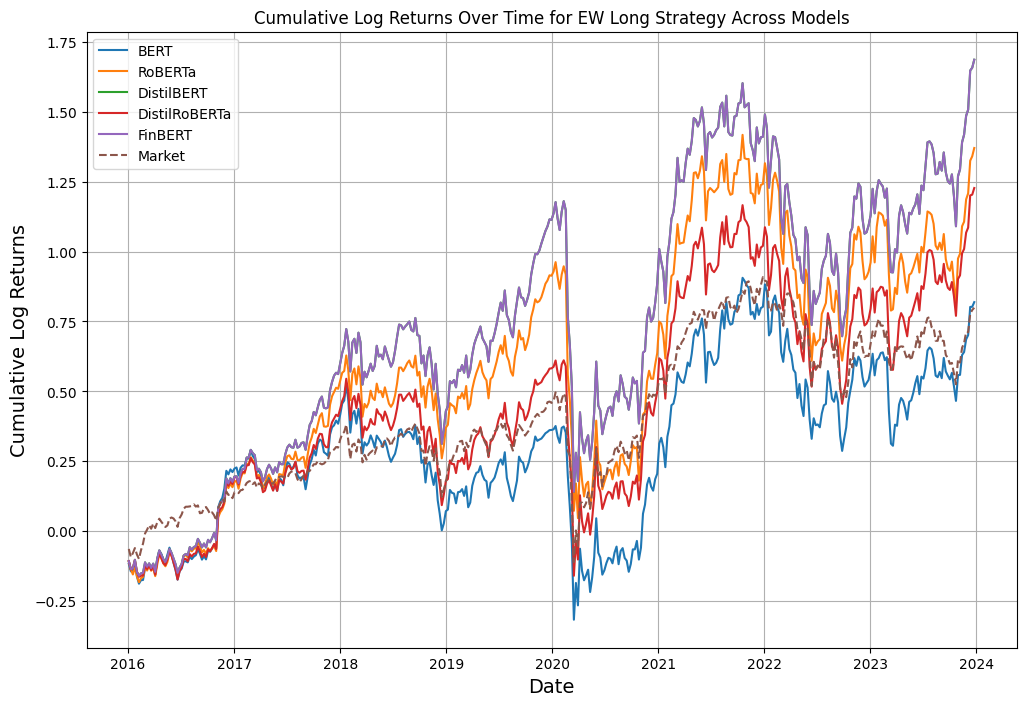

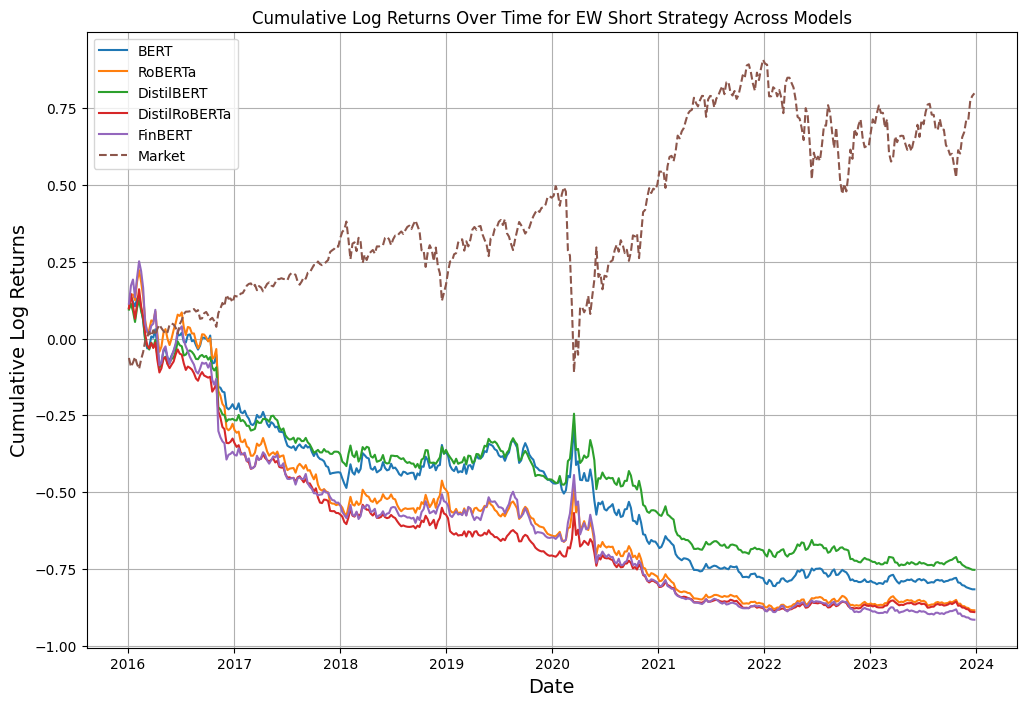

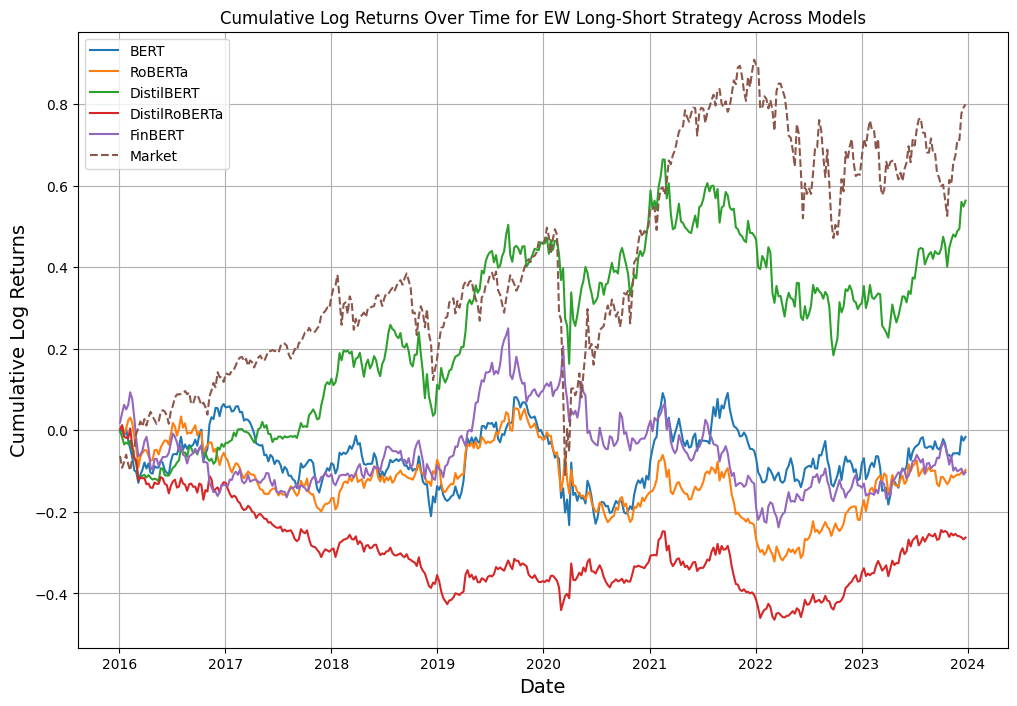

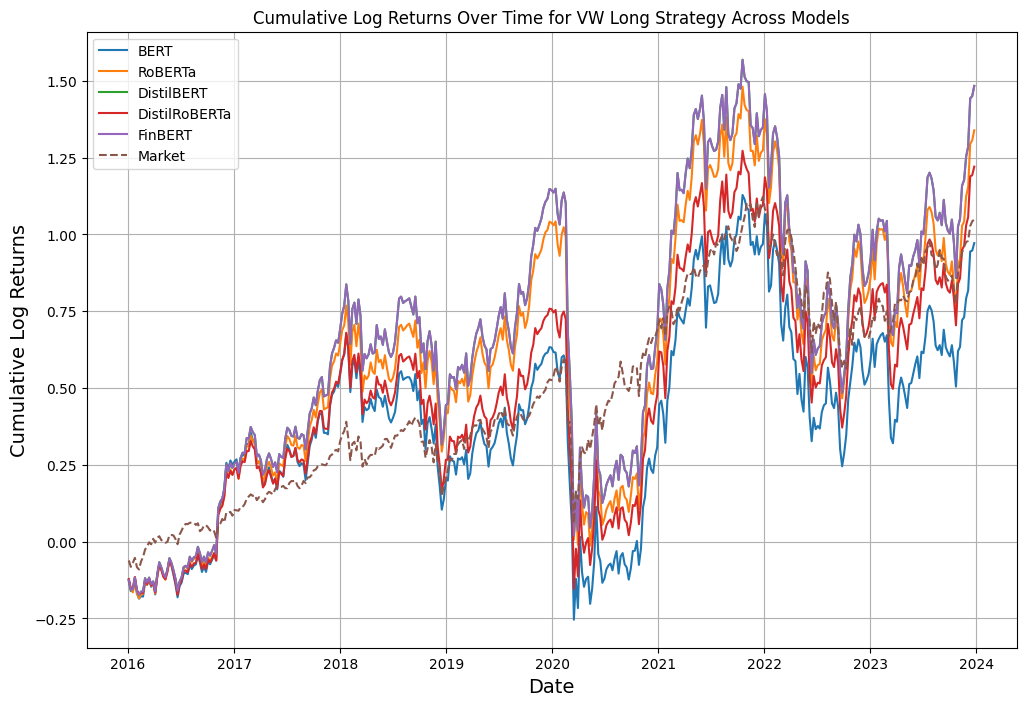

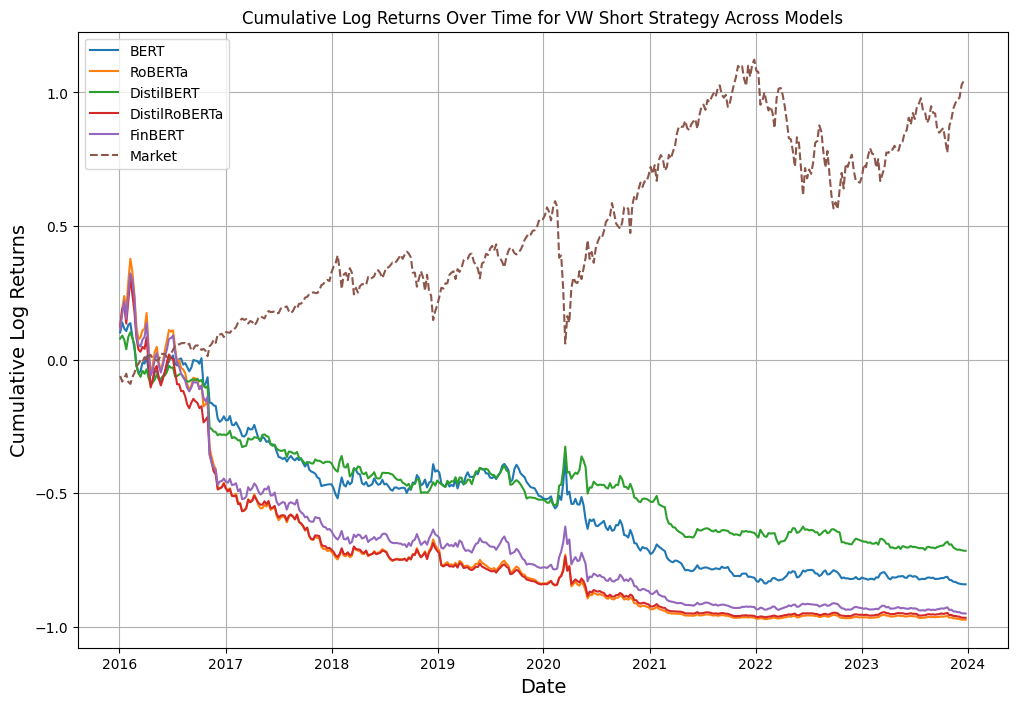

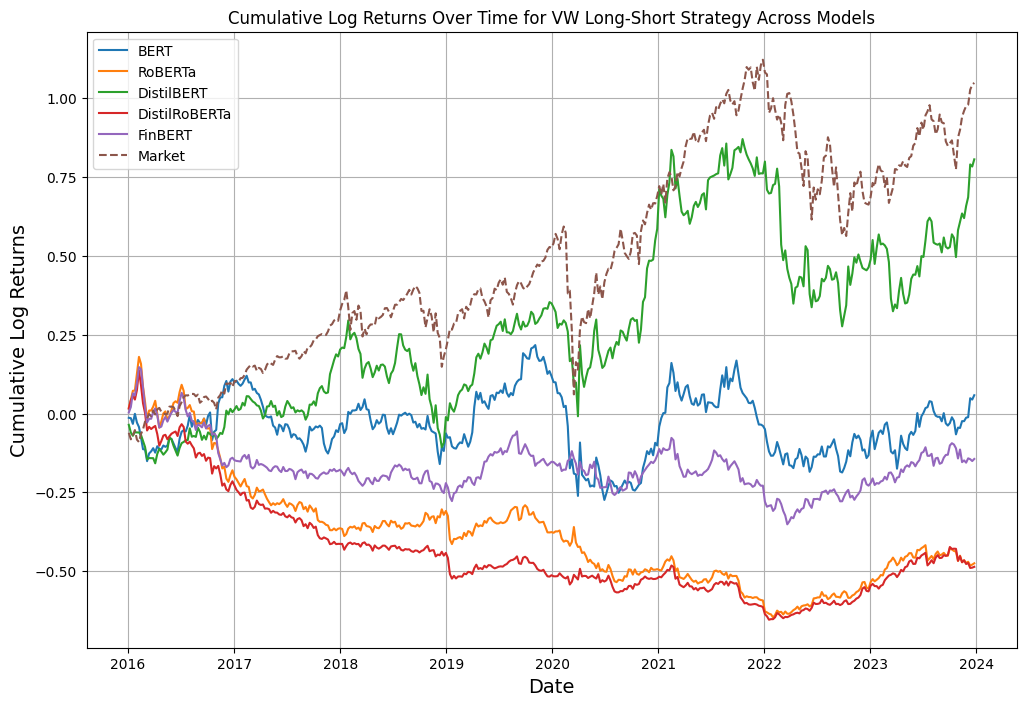

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_cumulative_log_returns(df, strategy_column, title, ylabel, market_data=None, market_column=None):
    plt.figure(figsize=(12, 8))
    # Define a mapping from the original model names to the desired legend names
    model_legend_map = {
        'bert-base-uncased': 'BERT',
        'roberta-base': 'RoBERTa',
        'distilbert-base-uncased': 'DistilBERT',
        'distilroberta-base': 'DistilRoBERTa',
        'yiyanghkust/finbert-tone': 'FinBERT'
    }

    models = df['Model'].unique()

    for model in models:
        model_data = df[df['Model'] == model]
        dates = model_data['Date']
        returns = model_data[strategy_column]

        # Compute log returns
        log_returns = np.log(1 + returns)

        # Compute cumulative log returns
        cumulative_log_returns = (1 + log_returns).cumprod() - 1

        # Plot the cumulative log returns with the mapped legend name
        plt.plot(dates, cumulative_log_returns, label=model_legend_map.get(model, model))

    if market_data is not None and market_column is not None:
        # Plot market line
        plt.plot(market_data['start_date'], market_data[market_column], label='Market', linestyle='--')

    plt.title(title)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Define strategy columns and titles
strategies = {
    'EW L': 'EW Long',
    'EW S': 'EW Short',
    'EW LS': 'EW Long-Short',
    'VW L': 'VW Long',
    'VW S': 'VW Short',
    'VW LS': 'VW Long-Short'
}

# Load market data
# weekly_market_data = pd.read_csv('market_data.csv') # Make sure to load your market data

# Plot each strategy
for strategy_column, strategy_name in strategies.items():
    # Set market column based on the strategy type
    market_column = 'cumulative_returnVW' if 'VW' in strategy_column else 'cumulative_return'

    plot_cumulative_log_returns(
        all_returns_df,
        strategy_column,
        f'Cumulative Log Returns Over Time for {strategy_name} Strategy Across Models',
        'Cumulative Log Returns',
        market_data=weekly_market_data,  # Provide the market data DataFrame
        market_column=market_column      # Provide the correct market column
    )


#Transaction Cost

In [ ]:
market_cap_data_tc = pd.read_csv(f'{base_path}/BM16_LLMs/Finance/data/crsp_2016-2023.csv', dtype={'PRC': 'str', 'SHROUT': 'str'},
                              on_bad_lines='skip')

In [ ]:
market_cap_data_tc

PERMNO        date  EXCHCD TICKER  PERMCO        PRC   SHROUT  \
0          10001  2016-01-04     2.0   EGAS    7953    7.52000    10505   
1          10001  2016-01-05     2.0   EGAS    7953    7.42000    10505   
2          10001  2016-01-06     2.0   EGAS    7953    7.53000    10505   
3          10001  2016-01-07     2.0   EGAS    7953    7.64000    10505   
4          10001  2016-01-08     2.0   EGAS    7953    7.79000    10505   
...          ...         ...     ...    ...     ...        ...      ...   
16319688   93436  2023-12-22     3.0   TSLA   53453  252.53999  3178921   
16319689   93436  2023-12-26     3.0   TSLA   53453  256.60999  3178921   
16319690   93436  2023-12-27     3.0   TSLA   53453  261.44000  3178921   
16319691   93436  2023-12-28     3.0   TSLA   53453  253.17999  3178921   
16319692   93436  2023-12-29     3.0   TSLA   53453  248.48000  3178921   

          CFACPR  CFACSHR  
0            1.0      1.0  
1            1.0      1.0  
2            1.0      1.0  
3            1.0      1.0  
4            1.0      1.0  
...          ...      ...  
16319688     1.0      1.0  
16319689     1.0      1.0  
16319690     1.0      1.0  
16319691     1.0      1.0  
16319692     1.0      1.0  

[16319693 rows x 9 columns]

In [ ]:
df2 = updated_out_sample_data

In [ ]:
df2

permco ticker  start_date    end_date announcedate  weekly_ret  \
0          90   AEXP  2016-01-04  2016-01-08          NaN   -8.099980   
1          90   AEXP  2016-01-11  2016-01-15   2016-01-05   -1.131492   
2          90   AEXP  2016-01-11  2016-01-15   2016-01-05   -1.131492   
3          90   AEXP  2016-01-11  2016-01-15   2016-01-07   -1.131492   
4          90   AEXP  2016-01-18  2016-01-22   2016-01-13  -12.478209   
...       ...    ...         ...         ...          ...         ...   
46779   55100    UBS  2023-12-25  2023-12-29   2023-12-17    0.032307   
46780   55100    UBS  2023-12-25  2023-12-29   2023-12-17    0.032307   
46781   55100    UBS  2023-12-25  2023-12-29   2023-12-18    0.032307   
46782   55100    UBS  2023-12-25  2023-12-29   2023-12-19    0.032307   
46783   55100    UBS  2023-12-25  2023-12-29   2023-12-20    0.032307   

       adj_prc                                           headline direction  \
0        63.63                                       No_Headlines        Up   
1        62.91  American Express Company, Q4 2015 Earnings Cal...      Down   
2        62.91  American Express Company to Report Q4, 2015 Re...      Down   
3        62.91  Keefe, Bruyette, & Woods, Inc., Keefe, Bruyett...      Down   
4        55.06  William Blair & Company, L.L.C., the William B...      Down   
...        ...                                                ...       ...   
46779    30.90  CRH plc (NYSE:CRH) agreed to acquire 57% stake...        Up   
46780    30.90  CRH plc (NYSE:CRH) agreed to acquire 57.3% sta...        Up   
46781    30.90  Ledman Optoelectronic Co., Ltd. announced that...        Up   
46782    30.90  UBS Reportedly Wants to Sell Loans That Credit...        Up   
46783    30.90  Changchun Engley Automobile Industry Co.,Ltd. ...        Up   

       label                       embeddings_bert-base-uncased  \
0          1  [-9.82060879e-02 -8.96423534e-02  3.14932615e-...   
1          0  [-2.73852646e-01 -3.17556679e-01  1.86395407e-...   
2          0  [-2.77936786e-01 -2.50797927e-01  5.10013461e-...   
3          0  [-2.88774788e-01 -1.06754221e-01  4.55723196e-...   
4          0  [-5.32218218e-01 -2.83114433e-01  2.27171972e-...   
...      ...                                                ...   
46779      1  [-2.98946388e-02 -4.40368056e-02  3.21662068e-...   
46780      1  [-2.59011723e-02 -3.39123532e-02  3.21588665e-...   
46781      1  [-1.14604816e-01 -1.67455941e-01  3.70845646e-...   
46782      1  [ 1.87299047e-02 -3.32486778e-01  1.82704762e-...   
46783      1  [-8.50117356e-02 -1.60883188e-01  3.73032689e-...   

       predicted_direction_bert-base-uncased  \
0                                        1.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
46779                                    0.0   
46780                                    0.0   
46781                                    1.0   
46782                                    1.0   
46783                                    1.0   

                                 embeddings_roberta-base  \
0      [-7.19479322e-02 -1.44707367e-01 -1.17597124e-...   
1      [ 1.80668876e-01  2.71915734e-01 -6.18177466e-...   
2      [-8.21089093e-03  9.77932364e-02 -2.36350158e-...   
3      [-7.84931611e-03  1.25758961e-01  6.06743768e-...   
4      [-7.67796487e-03  5.83324283e-02  9.09621362e-...   
...                                                  ...   
46779  [-8.67796317e-02  1.12189971e-01  5.30455895e-...   
46780  [-7.49015808e-02  1.24819517e-01  6.03962317e-...   
46781  [ 1.80509910e-02  1.37082011e-01  1.33610377e-...   
46782  [ 2.13510566e-03  7.49902129e-02 -8.63197260e-...   
46783  [ 1.22285797e-03  4.67122160e-03  9.80258435e-...   

       predicted_direction_roberta-base  \
0                                  

In [ ]:
# Convert PRC and SHROUT to numeric, forcing errors to NaN
market_cap_data_tc['PRC'] = pd.to_numeric(market_cap_data_tc['PRC'], errors='coerce')
market_cap_data_tc['SHROUT'] = pd.to_numeric(market_cap_data_tc['SHROUT'], errors='coerce')

# Drop rows where PRC or SHROUT couldn't be converted to numbers
market_cap_data_tc.dropna(subset=['PRC', 'SHROUT'], inplace=True)

# Filter for NYSE stocks (EXCHCD == 1)
market_cap_data_tc = market_cap_data_tc[market_cap_data_tc['EXCHCD'] == 1]

# Handle the date column and ensure consistency
market_cap_data_tc['date'] = pd.to_datetime(market_cap_data_tc['date'], errors='coerce')
market_cap_data_tc['date'] = market_cap_data_tc['date'].dt.tz_localize(None)
market_cap_data_tc.dropna(subset=['date'], inplace=True)

# Calculate Market Cap
market_cap_data_tc['Market_Cap'] = market_cap_data_tc['PRC'] * market_cap_data_tc['SHROUT']

# Create a list of permnos to filter
permno_list = [
    47896, 38703, 59408, 70519, 17778, 66800, 83443, 36469, 88239, 82654,
    15054, 86868, 92611, 59176, 92655, 83835, 66157, 52919, 89428, 69032,
    89199, 91233, 87842, 87212, 49656, 49680, 81284, 51043, 89179, 89258
]

# Filter market_cap_data based on permno list
filtered_market_cap_data = market_cap_data_tc[market_cap_data_tc['PERMNO'].isin(permno_list)]

# Classify Stocks Based on Market Cap
filtered_market_cap_data['Classification'] = filtered_market_cap_data.groupby('date')['Market_Cap'].transform(
    lambda x: np.where(x >= x.median(), 'Large', 'Small')
)

# Rename TICKER to Ticker
filtered_market_cap_data.rename(columns={'TICKER': 'Ticker'}, inplace=True)

<ipython-input-33-f62d6a73d6b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cap_data_tc['date'] = pd.to_datetime(market_cap_data_tc['date'], errors='coerce')
<ipython-input-33-f62d6a73d6b2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_cap_data_tc['date'] = market_cap_data_tc['date'].dt.tz_localize(None)
<ipython-input-33-f62d6a73d6b2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [ ]:
filtered_market_cap_data

PERMNO       date  EXCHCD Ticker  PERMCO        PRC     SHROUT  \
2981977    15054 2016-01-04     1.0    UBS   55100   19.13000  3758844.0   
2981978    15054 2016-01-05     1.0    UBS   55100   19.02000  3758844.0   
2981979    15054 2016-01-06     1.0    UBS   55100   18.78000  3758844.0   
2981980    15054 2016-01-07     1.0    UBS   55100   18.30000  3758844.0   
2981981    15054 2016-01-08     1.0    UBS   55100   17.37000  3758844.0   
...          ...        ...     ...    ...     ...        ...        ...   
15590600   92655 2023-12-22     1.0    UNH    7267  520.31000   924925.0   
15590601   92655 2023-12-26     1.0    UNH    7267  520.03003   924925.0   
15590602   92655 2023-12-27     1.0    UNH    7267  522.78998   924925.0   
15590603   92655 2023-12-28     1.0    UNH    7267  524.90002   924925.0   
15590604   92655 2023-12-29     1.0    UNH    7267  526.46997   924925.0   

          CFACPR  CFACSHR    Market_Cap Classification  
2981977      1.0      1.0  7.190669e+07          Small  
2981978      1.0      1.0  7.149321e+07          Small  
2981979      1.0      1.0  7.059109e+07          Small  
2981980      1.0      1.0  6.878685e+07          Small  
2981981      1.0      1.0  6.529112e+07          Small  
...          ...      ...           ...            ...  
15590600     1.0      1.0  4.812477e+08          Large  
15590601     1.0      1.0  4.809888e+08          Large  
15590602     1.0      1.0  4.835415e+08          Large  
15590603     1.0      1.0  4.854932e+08          Large  
15590604     1.0      1.0  4.869452e+08          Large  

[52312 rows x 11 columns]

In [ ]:
# Ensure 'start_date' and 'date' are in the same format for merging
df2['start_date'] = pd.to_datetime(df2['start_date'], errors='coerce').dt.tz_localize(None)
filtered_market_cap_data['date'] = pd.to_datetime(filtered_market_cap_data['date'], errors='coerce').dt.tz_localize(None)

<ipython-input-35-398f38f34f84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_market_cap_data['date'] = pd.to_datetime(filtered_market_cap_data['date'], errors='coerce').dt.tz_localize(None)


In [ ]:
# Merge `updated_out_sample` with the filtered market cap data on 'ticker' and 'start_date'/'date'
merged_df = pd.merge(df2, filtered_market_cap_data[['PERMCO', 'date', 'Ticker', 'Market_Cap', 'Classification']],
                     left_on=['permco', 'start_date'],
                     right_on=['PERMCO', 'date'],
                     how='left')

In [ ]:
unique_tickers = merged_df['ticker'].unique()
unique_tickers

array(['AEXP', 'AIG', 'BRK', 'USB', 'BAC', 'UNH', 'BK', 'CHL', 'C', 'DHR',
       'NOB', 'BMO', 'RY', 'TD', 'GS', 'MFC', 'MET', 'ANTM', 'DB', 'PRU',
       'BNS', 'MA', 'V', 'UBS'], dtype=object)

In [ ]:
import pandas as pd
import numpy as np

# Adjust Returns with Transaction Costs
def adjust_returns(row, large_cap_cost=11.21, small_cap_cost=21.27):
    if row['Classification'] == 'Large':
        cost = large_cap_cost
    elif row['Classification'] == 'Small':
        cost = small_cap_cost
    else:
        return np.nan  # If classification is missing, return NaN

    return row['weekly_ret'] - abs(row['weekly_ret'] * cost * 0.0001)

merged_df['return_with_txn_cost'] = merged_df.apply(adjust_returns, axis=1)

# Drop the Ticker and date columns from the merged DataFrame
merged_df.drop(columns=['Ticker', 'date', 'PERMCO', 'Market_Cap'], inplace=True)

In [ ]:
merged_df

permco ticker start_date    end_date announcedate  weekly_ret  adj_prc  \
0          90   AEXP 2016-01-04  2016-01-08          NaN   -8.099980    63.63   
1          90   AEXP 2016-01-11  2016-01-15   2016-01-05   -1.131492    62.91   
2          90   AEXP 2016-01-11  2016-01-15   2016-01-05   -1.131492    62.91   
3          90   AEXP 2016-01-11  2016-01-15   2016-01-07   -1.131492    62.91   
4          90   AEXP 2016-01-18  2016-01-22   2016-01-13  -12.478209    55.06   
...       ...    ...        ...         ...          ...         ...      ...   
47120   55100    UBS 2023-12-25  2023-12-29   2023-12-17    0.032307    30.90   
47121   55100    UBS 2023-12-25  2023-12-29   2023-12-17    0.032307    30.90   
47122   55100    UBS 2023-12-25  2023-12-29   2023-12-18    0.032307    30.90   
47123   55100    UBS 2023-12-25  2023-12-29   2023-12-19    0.032307    30.90   
47124   55100    UBS 2023-12-25  2023-12-29   2023-12-20    0.032307    30.90   

                                                headline direction  label  \
0                                           No_Headlines        Up      1   
1      American Express Company, Q4 2015 Earnings Cal...      Down      0   
2      American Express Company to Report Q4, 2015 Re...      Down      0   
3      Keefe, Bruyette, & Woods, Inc., Keefe, Bruyett...      Down      0   
4      William Blair & Company, L.L.C., the William B...      Down      0   
...                                                  ...       ...    ...   
47120  CRH plc (NYSE:CRH) agreed to acquire 57% stake...        Up      1   
47121  CRH plc (NYSE:CRH) agreed to acquire 57.3% sta...        Up      1   
47122  Ledman Optoelectronic Co., Ltd. announced that...        Up      1   
47123  UBS Reportedly Wants to Sell Loans That Credit...        Up      1   
47124  Changchun Engley Automobile Industry Co.,Ltd. ...        Up      1   

       ...                            embeddings_roberta-base  \
0      ...  [-7.19479322e-02 -1.44707367e-01 -1.17597124e-...   
1      ...  [ 1.80668876e-01  2.71915734e-01 -6.18177466e-...   
2      ...  [-8.21089093e-03  9.77932364e-02 -2.36350158e-...   
3      ...  [-7.84931611e-03  1.25758961e-01  6.06743768e-...   
4      ...  [-7.67796487e-03  5.83324283e-02  9.09621362e-...   
...    ...                                                ...   
47120  ...  [-8.67796317e-02  1.12189971e-01  5.30455895e-...   
47121  ...  [-7.49015808e-02  1.24819517e-01  6.03962317e-...   
47122  ...  [ 1.80509910e-02  1.37082011e-01  1.33610377e-...   
47123  ...  [ 2.13510566e-03  7.49902129e-02 -8.63197260e-...   
47124  ...  [ 1.22285797e-03  4.67122160e-03  9.80258435e-...   

       predicted_direction_roberta-base  \
0                                   1.0   
1                                   1.0   
2                                   1.0   
3                                   0.0   
4                                   1.0   
...                                 ...   
47120                               0.0   
47121                               0.0   
47122                               1.0   
47123                               1.0   
47124                               1.0   

                      embeddings_distilbert-base-uncased  \
0      [-1.25779986e-01 -6.91891760e-02  1.31961673e-...   
1      [-3.41024339e-01 -1.99908391e-02  3.49603534e-...   
2      [-3.04641306e-01 -5.23198321e-02  4.00941253e-...   
3      [-1.34224266e-01  1.64538234e-01  4.59518969e-...   
4      [-3.33897173e-01  5.85352667e-02  3.69941682e-...   
...                                                  ...   
47120  [-5.65928668e-02  4.55940217e-02  3.48505348e-...   
47121  [-9.34638903e-02  5.80877904e-03  3.51782501e-...   
47122  [ 2.89313402e-03  4.12882194e-02  3.13398421e-...   
47123  [ 4.29963507e-02 -1.16966859e-01  1.13572657e-...   
47124  [ 3.56904641e-02  4.31777909e-02  2.19404712e-...   

       predicted_direction_distilbert-base-uncased  \
0                                   

In [ ]:
merged_df = merged_df.dropna(subset=['Classification'])

In [ ]:
merged_df

permco ticker start_date    end_date announcedate  weekly_ret  adj_prc  \
0          90   AEXP 2016-01-04  2016-01-08          NaN   -8.099980    63.63   
1          90   AEXP 2016-01-11  2016-01-15   2016-01-05   -1.131492    62.91   
2          90   AEXP 2016-01-11  2016-01-15   2016-01-05   -1.131492    62.91   
3          90   AEXP 2016-01-11  2016-01-15   2016-01-07   -1.131492    62.91   
5          90   AEXP 2016-01-25  2016-01-29   2016-01-21   -2.833278    53.50   
...       ...    ...        ...         ...          ...         ...      ...   
47115   55100    UBS 2023-12-04  2023-12-08   2023-11-28   -0.592826    28.51   
47116   55100    UBS 2023-12-11  2023-12-15   2023-12-05    2.700904    29.28   
47117   55100    UBS 2023-12-18  2023-12-22   2023-12-11    5.498591    30.89   
47118   55100    UBS 2023-12-18  2023-12-22   2023-12-12    5.498591    30.89   
47119   55100    UBS 2023-12-18  2023-12-22   2023-12-13    5.498591    30.89   

                                                headline direction  label  \
0                                           No_Headlines        Up      1   
1      American Express Company, Q4 2015 Earnings Cal...      Down      0   
2      American Express Company to Report Q4, 2015 Re...      Down      0   
3      Keefe, Bruyette, & Woods, Inc., Keefe, Bruyett...      Down      0   
5      American Express Company Reports Consolidated ...      Down      0   
...                                                  ...       ...    ...   
47115  UBS Group AG has completed a Fixed-Income Offe...      Down      0   
47116  NFL Players Association Names UBS an Instituti...        Up      1   
47117  UBS Group AG Presents at 2023 HOPE Global Foru...        Up      1   
47118  Foshan Golden Milky Way Intelligent Equipment ...        Up      1   
47119  Dongrui Food Group Co., Ltd. announced that it...        Up      1   

       ...                            embeddings_roberta-base  \
0      ...  [-7.19479322e-02 -1.44707367e-01 -1.17597124e-...   
1      ...  [ 1.80668876e-01  2.71915734e-01 -6.18177466e-...   
2      ...  [-8.21089093e-03  9.77932364e-02 -2.36350158e-...   
3      ...  [-7.84931611e-03  1.25758961e-01  6.06743768e-...   
5      ...  [ 3.20383869e-02  1.41638845e-01  1.04480563e-...   
...    ...                                                ...   
47115  ...  [ 4.38444242e-02  1.40090376e-01 -1.39881130e-...   
47116  ...  [-1.78003032e-02  2.89423168e-01  1.92496199e-...   
47117  ...  [-9.01853964e-02  1.08933106e-01  1.59368038e-...   
47118  ...  [-1.76955611e-02  5.83984479e-02  5.95569983e-...   
47119  ...  [-3.50564234e-02 -8.67522508e-03  8.20828229e-...   

       predicted_direction_roberta-base  \
0                                   1.0   
1                                   1.0   
2                                   1.0   
3                                   0.0   
5                                   0.0   
...                                 ...   
47115                               0.0   
47116                               0.0   
47117                               1.0   
47118                               1.0   
47119                               0.0   

                      embeddings_distilbert-base-uncased  \
0      [-1.25779986e-01 -6.91891760e-02  1.31961673e-...   
1      [-3.41024339e-01 -1.99908391e-02  3.49603534e-...   
2      [-3.04641306e-01 -5.23198321e-02  4.00941253e-...   
3      [-1.34224266e-01  1.64538234e-01  4.59518969e-...   
5      [-3.21391702e-01  1.84965432e-02  3.82596731e-...   
...                                                  ...   
47115  [-1.53752968e-01 -3.76109928e-02  2.20180556e-...   
47116  [-1.91866487e-01  7.35997707e-02  1.95288226e-...   
47117  [-2.51658648e-01 -1.11053109e-01  6.57662511e-...   
47118  [ 2.76834629e-02  7.29751140e-02  2.84251451e-...   
47119  [ 4.75047454e-02  1.76736782e-03  1.98914722e-...   

       predicted_direction_distilbert-base-uncased  \
0                                   

#Portfolio - Transaction Cost

In [ ]:
import pandas as pd
import numpy as np

def calculate_returns(data, weights):
    """Calculate weighted returns for a portfolio."""
    weighted_returns = data.mul(weights, axis=1)
    portfolio_returns = weighted_returns.sum(axis=1)
    return portfolio_returns

def calculate_portfolio_returns(data, predictions, market_caps, N=5):
    """Calculate portfolio returns using equal and value weights."""
    # Sort predictions to get top and bottom N tickers
    sorted_indices = predictions.sort_values(ascending=False).index
    top_n_indices = sorted_indices[:N]
    bottom_n_indices = sorted_indices[-N:]

    # Equal weights for top and bottom N
    ew_weights = np.array([1/N] * N)

    # Value weights for top and bottom N using market cap
    top_market_caps = market_caps.loc[top_n_indices]
    bottom_market_caps = market_caps.loc[bottom_n_indices]

    vw_weights_top = top_market_caps / top_market_caps.sum()
    vw_weights_bottom = bottom_market_caps / bottom_market_caps.sum()

    # Calculate returns
    ew_l = calculate_returns(data.loc[:, top_n_indices], ew_weights)
    ew_s = calculate_returns(data.loc[:, bottom_n_indices], ew_weights)
    ew_ls = ew_l - ew_s

    vw_l = calculate_returns(data.loc[:, top_n_indices], vw_weights_top)
    vw_s = calculate_returns(data.loc[:, bottom_n_indices], vw_weights_bottom)
    vw_ls = vw_l - vw_s

    returns = {
        'EW L': ew_l,
        'EW S': ew_s,
        'EW LS': ew_ls,
        'VW L': vw_l,
        'VW S': vw_s,
        'VW LS': vw_ls
    }
    return returns

def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """Calculate Sharpe ratio given returns and risk-free rate."""
    excess_returns = returns - risk_free_rate
    mean_excess_returns = excess_returns.mean()
    std_excess_returns = excess_returns.std()
    sharpe_ratio = mean_excess_returns / std_excess_returns * np.sqrt(52)
    return sharpe_ratio, mean_excess_returns, std_excess_returns

def process_model(model_name, df, returns_data, market_cap_data, scaling_factor=0.01):
    """Process each model to calculate portfolio returns and Sharpe ratios."""
    model_data = df[['ticker', 'return_with_txn_cost', f'predicted_direction_{model_name}']]
    model_tickers = model_data['ticker'].unique()
    model_returns_data = returns_data.loc[:, returns_data.columns.isin(model_tickers)]

    if model_returns_data.empty:
        print(f"No data available for model: {model_name}")
        return None, None, None, None, None, None, None, None, None

    predicted_returns = model_data.groupby('ticker')[f'predicted_direction_{model_name}'].mean()
    market_caps = market_cap_data.set_index('ticker')['market_cap']

    # Ensure that market_caps only includes the tickers in model_returns_data
    market_caps = market_caps[market_caps.index.isin(model_tickers)]

    # Ensure there are no duplicate tickers in market_caps
    market_caps = market_caps[~market_caps.index.duplicated(keep='first')]

    portfolio_returns = calculate_portfolio_returns(model_returns_data, predicted_returns, market_caps)

    # Apply scaling factor
    ew_l_returns = portfolio_returns['EW L'] * scaling_factor
    ew_s_returns = portfolio_returns['EW S'] * scaling_factor
    ew_ls_returns = portfolio_returns['EW LS'] * scaling_factor

    vw_l_returns = portfolio_returns['VW L'] * scaling_factor
    vw_s_returns = portfolio_returns['VW S'] * scaling_factor
    vw_ls_returns = portfolio_returns['VW LS'] * scaling_factor

    # For short portfolios, returns are negative, so apply negative scaling factor
    ew_s_returns *= -1
    vw_s_returns *= -1

    # Calculate Sharpe ratios and excess returns stats
    ew_l_sharpe, ew_l_mean, ew_l_std = calculate_sharpe_ratio(ew_l_returns)
    ew_s_sharpe, ew_s_mean, ew_s_std = calculate_sharpe_ratio(ew_s_returns)
    ew_ls_sharpe, ew_ls_mean, ew_ls_std = calculate_sharpe_ratio(ew_ls_returns)

    vw_l_sharpe, vw_l_mean, vw_l_std = calculate_sharpe_ratio(vw_l_returns)
    vw_s_sharpe, vw_s_mean, vw_s_std = calculate_sharpe_ratio(vw_s_returns)
    vw_ls_sharpe, vw_ls_mean, vw_ls_std = calculate_sharpe_ratio(vw_ls_returns)

    return (ew_l_returns, ew_s_returns, ew_ls_returns, vw_l_returns, vw_s_returns, vw_ls_returns,
            ew_l_sharpe, ew_s_sharpe, ew_ls_sharpe, vw_l_sharpe, vw_s_sharpe, vw_ls_sharpe,
            ew_l_mean, ew_s_mean, ew_ls_mean, vw_l_mean, vw_s_mean, vw_ls_mean,
            ew_l_std, ew_s_std, ew_ls_std, vw_l_std, vw_s_std, vw_ls_std)

# Load your datasets
df = merged_df
market_cap_data = company_market_cap  # Ensure this DataFrame is loaded correctly

# Prepare weekly returns data
filtered_data = df.dropna(subset=['return_with_txn_cost'])
filtered_data['Week'] = pd.to_datetime(filtered_data['start_date']).dt.to_period('W')
aggregated_data = filtered_data.groupby(['Week', 'ticker']).agg({'return_with_txn_cost': 'mean'}).reset_index()
returns_data = aggregated_data.pivot(index='Week', columns='ticker', values='return_with_txn_cost')
returns_data.index = returns_data.index.to_timestamp()

# Ensure returns_data columns are unique
returns_data = returns_data.loc[:, ~returns_data.columns.duplicated()]

# List of models to process
models = ['bert-base-uncased', 'roberta-base', 'distilbert-base-uncased', 'distilroberta-base', 'yiyanghkust/finbert-tone']
all_returns_tc = []
all_sharpe_ratios_tc = []

for model_name in models:
    result = process_model(model_name, df, returns_data, market_cap_data)

    if result[0] is None:
        continue

    ew_l_returns, ew_s_returns, ew_ls_returns, vw_l_returns, vw_s_returns, vw_ls_returns = result[:6]
    ew_l_sharpe, ew_s_sharpe, ew_ls_sharpe, vw_l_sharpe, vw_s_sharpe, vw_ls_sharpe = result[6:12]
    ew_l_mean, ew_s_mean, ew_ls_mean, vw_l_mean, vw_s_mean, vw_ls_mean = result[12:18]
    ew_l_std, ew_s_std, ew_ls_std, vw_l_std, vw_s_std, vw_ls_std = result[18:]

    # Store returns and Sharpe ratios in dictionaries
    model_returns_tc = {
        'Model': model_name,
        'Date': ew_l_returns.index,
        'EW L': ew_l_returns.values,
        'EW S': ew_s_returns.values,
        'EW LS': ew_ls_returns.values,
        'VW L': vw_l_returns.values,
        'VW S': vw_s_returns.values,
        'VW LS': vw_ls_returns.values
    }

    model_sharpe_ratios_tc = {
        'Model': model_name,
        'EW L Sharpe': ew_l_sharpe,
        'EW S Sharpe': ew_s_sharpe,
        'EW LS Sharpe': ew_ls_sharpe,
        'VW L Sharpe': vw_l_sharpe,
        'VW S Sharpe': vw_s_sharpe,
        'VW LS Sharpe': vw_ls_sharpe,
        'EW L Mean Excess Return': ew_l_mean,
        'EW S Mean Excess Return': ew_s_mean,
        'EW LS Mean Excess Return': ew_ls_mean,
        'VW L Mean Excess Return': vw_l_mean,
        'VW S Mean Excess Return': vw_s_mean,
        'VW LS Mean Excess Return': vw_ls_mean,
        'EW L Std Excess Return': ew_l_std,
        'EW S Std Excess Return': ew_s_std,
        'EW LS Std Excess Return': ew_ls_std,
        'VW L Std Excess Return': vw_l_std,
        'VW S Std Excess Return': vw_s_std,
        'VW LS Std Excess Return': vw_ls_std
    }

    # Convert dictionaries to DataFrames
    model_returns_tc = pd.DataFrame(model_returns_tc)
    all_returns_tc.append(model_returns_tc)

    model_sharpe_ratios_tc = pd.DataFrame([model_sharpe_ratios_tc])
    all_sharpe_ratios_tc.append(model_sharpe_ratios_tc)

# Concatenate all individual model dataframes into one
all_returns_df_tc = pd.concat(all_returns_tc)
sharpe_ratios_df_tc = pd.concat(all_sharpe_ratios_tc)

# Print the combined dataframes
all_returns_df_tc
sharpe_ratios_df_tc

Model  EW L Sharpe  EW S Sharpe  EW LS Sharpe  \
0         bert-base-uncased     0.654196    -0.656524      0.210852   
0              roberta-base     0.756759    -0.736978     -0.001799   
0   distilbert-base-uncased     0.798029    -0.640543      0.517820   
0        distilroberta-base     0.731737    -0.821387     -0.020858   
0  yiyanghkust/finbert-tone     0.798029    -0.749490     -0.119560   

   VW L Sharpe  VW S Sharpe  VW LS Sharpe  EW L Mean Excess Return  \
0     0.699889    -0.667341      0.315016                 0.004101   
0     0.749694    -0.815892     -0.525648                 0.004270   
0     0.768869    -0.557387      0.624442                 0.004471   
0     0.730466    -0.854594     -0.522157                 0.004272   
0     0.768869    -0.777203     -0.201290                 0.004471   

   EW S Mean Excess Return  EW LS Mean Excess Return  VW L Mean Excess Return  \
0                -0.003336                  0.000766                 0.004943   
0                -0.004275                 -0.000005                 0.004935   
0                -0.002811                  0.001661                 0.005128   
0                -0.004330                 -0.000059                 0.004841   
0                -0.004825                 -0.000353                 0.005128   

   VW S Mean Excess Return  VW LS Mean Excess Return  EW L Std Excess Return  \
0                -0.003536                  0.001407                0.045210   
0                -0.006660                 -0.001725                0.040686   
0                -0.002420                  0.002708                0.040405   
0                -0.006333                 -0.001492                0.042097   
0                -0.005697                 -0.000569                0.040405   

   EW S Std Excess Return  EW LS Std Excess Return  VW L Std Excess Return  \
0                0.036640                 0.026184                0.050926   
0                0.041827                 0.020027                0.047473   
0                0.031644                 0.023126                0.048093   
0                0.038016                 0.020235                0.047793   
0                0.046420                 0.021307                0.048093   

   VW S Std Excess Return  VW LS Std Excess Return  
0                0.038208                 0.032204  
0                0.058865                 0.023661  
0                0.031307                 0.031271  
0                0.053437                 0.020599  
0                0.052858                 0.020391

In [ ]:
all_returns_df

Model       Date      EW L      EW S     EW LS  \
0           bert-base-uncased 2016-01-04 -0.109405  0.105514 -0.003891   
1           bert-base-uncased 2016-01-11 -0.030442  0.035815  0.005373   
2           bert-base-uncased 2016-01-18  0.001867 -0.016824 -0.014957   
3           bert-base-uncased 2016-01-25  0.030303 -0.012835  0.017468   
4           bert-base-uncased 2016-02-01 -0.050340  0.022413 -0.027927   
..                        ...        ...       ...       ...       ...   
412  yiyanghkust/finbert-tone 2023-11-27  0.028201 -0.038244 -0.010042   
413  yiyanghkust/finbert-tone 2023-12-04  0.008867 -0.005732  0.003135   
414  yiyanghkust/finbert-tone 2023-12-11  0.057375 -0.053024  0.004351   
415  yiyanghkust/finbert-tone 2023-12-18  0.003821 -0.020153 -0.016332   
416  yiyanghkust/finbert-tone 2023-12-25  0.010843 -0.004392  0.006450   

         VW L      VW S     VW LS  
0   -0.121029  0.107549 -0.013480  
1   -0.035951  0.034625 -0.001326  
2    0.001843 -0.019977 -0.018134  
3    0.042251 -0.008677  0.033574  
4   -0.048719  0.021199 -0.027520  
..        ...       ...       ...  
412  0.035926 -0.044271 -0.008346  
413  0.014635  0.001811  0.016446  
414  0.070969 -0.074099 -0.003131  
415  0.002997 -0.009955 -0.006959  
416  0.013711 -0.005870  0.007840  

[2085 rows x 8 columns]

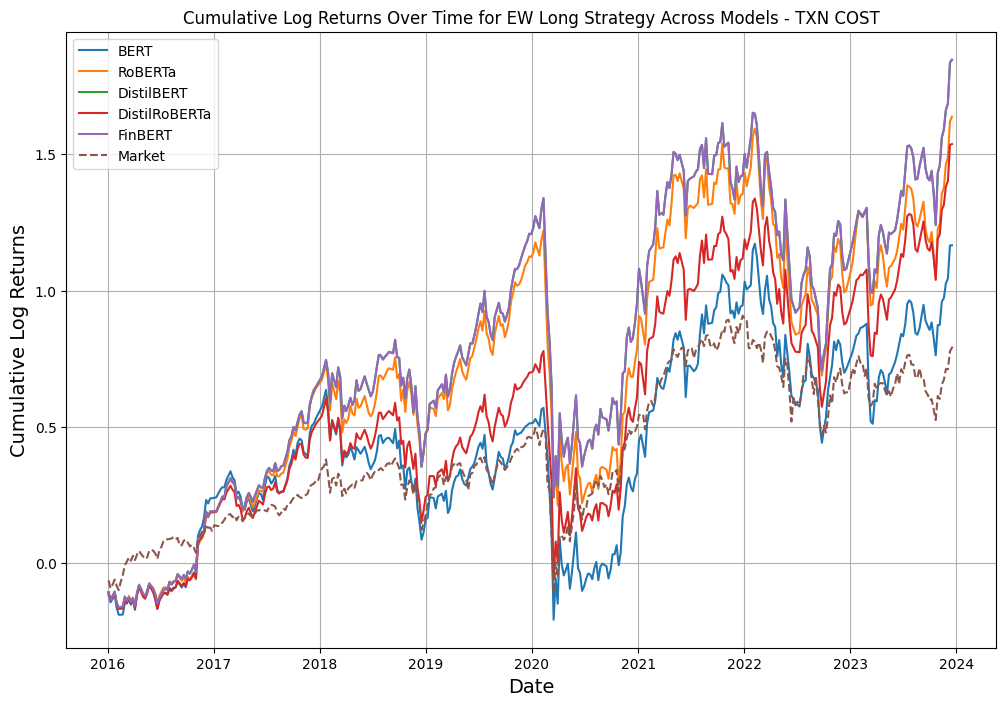

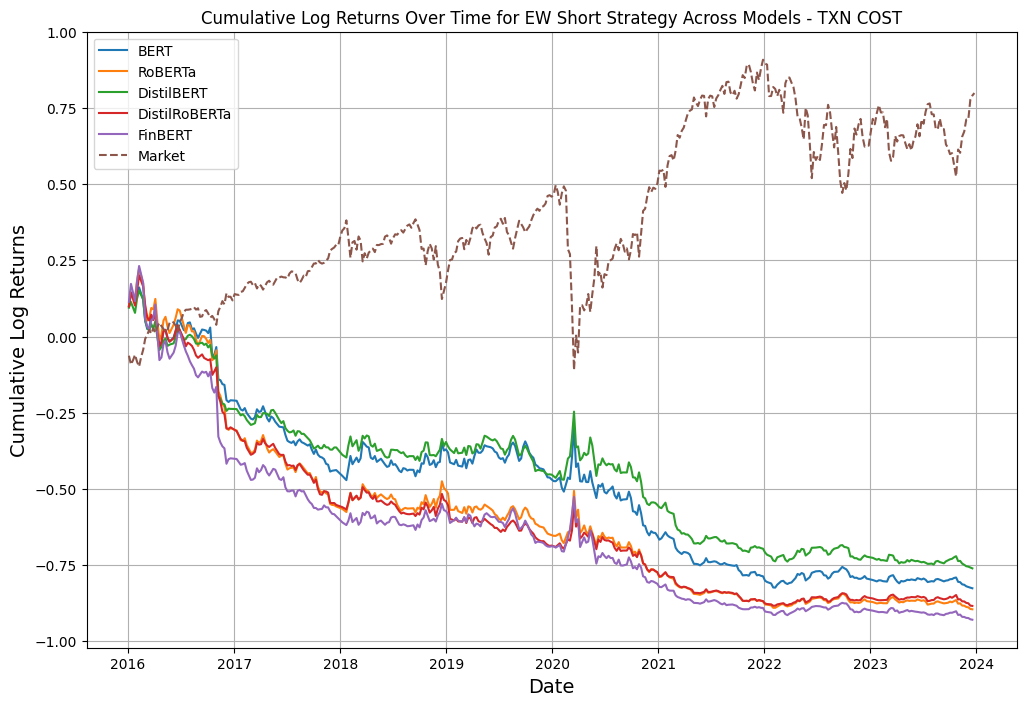

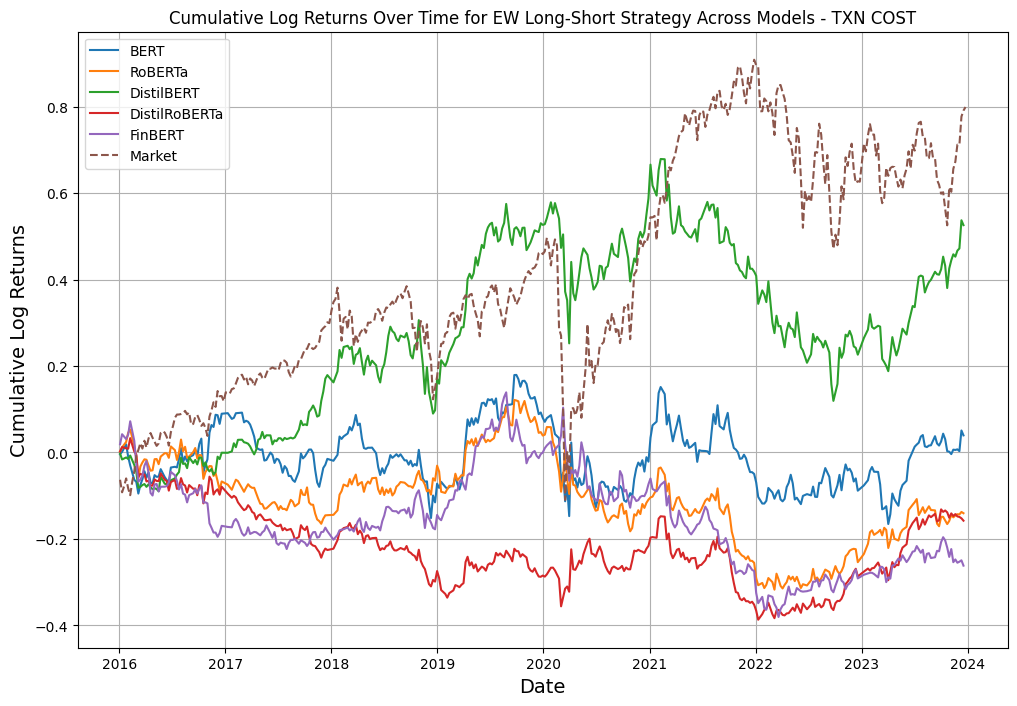

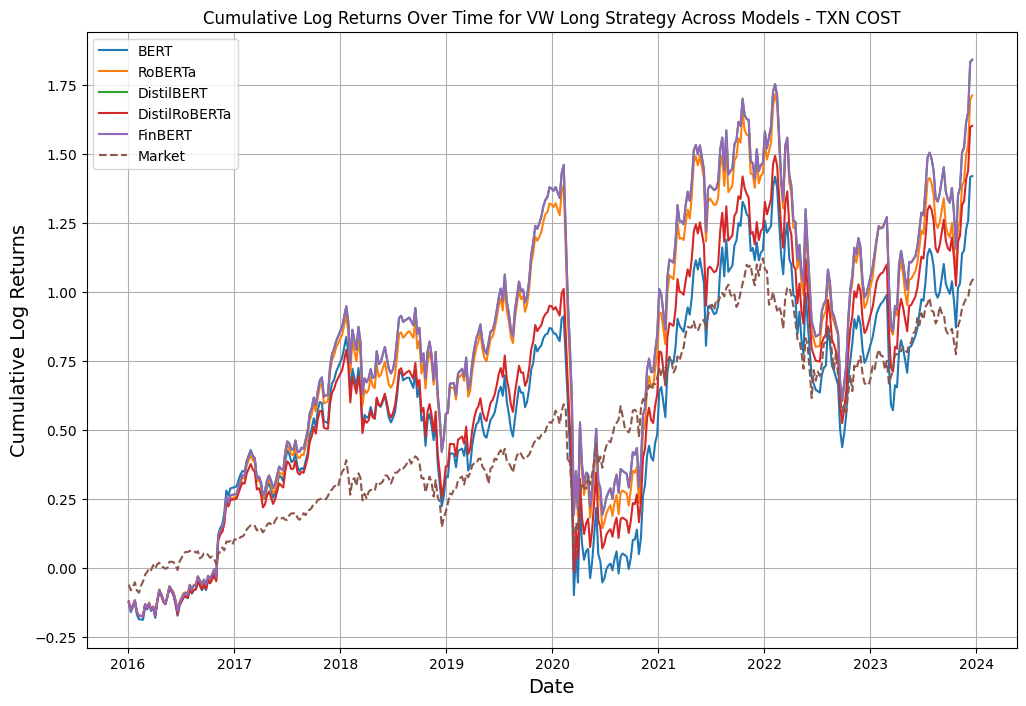

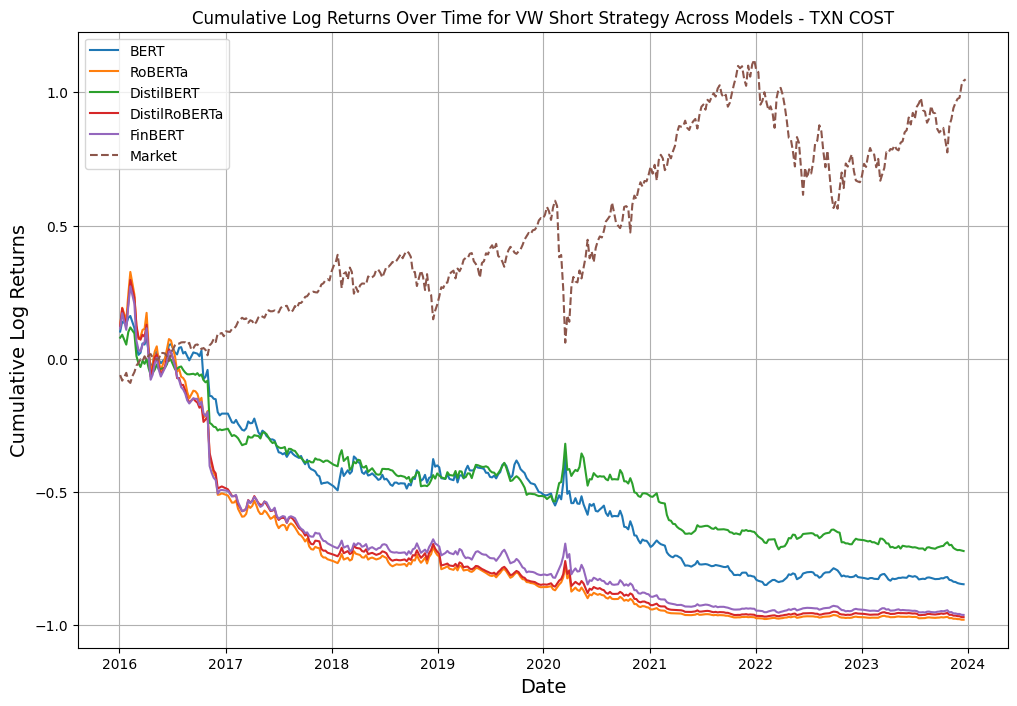

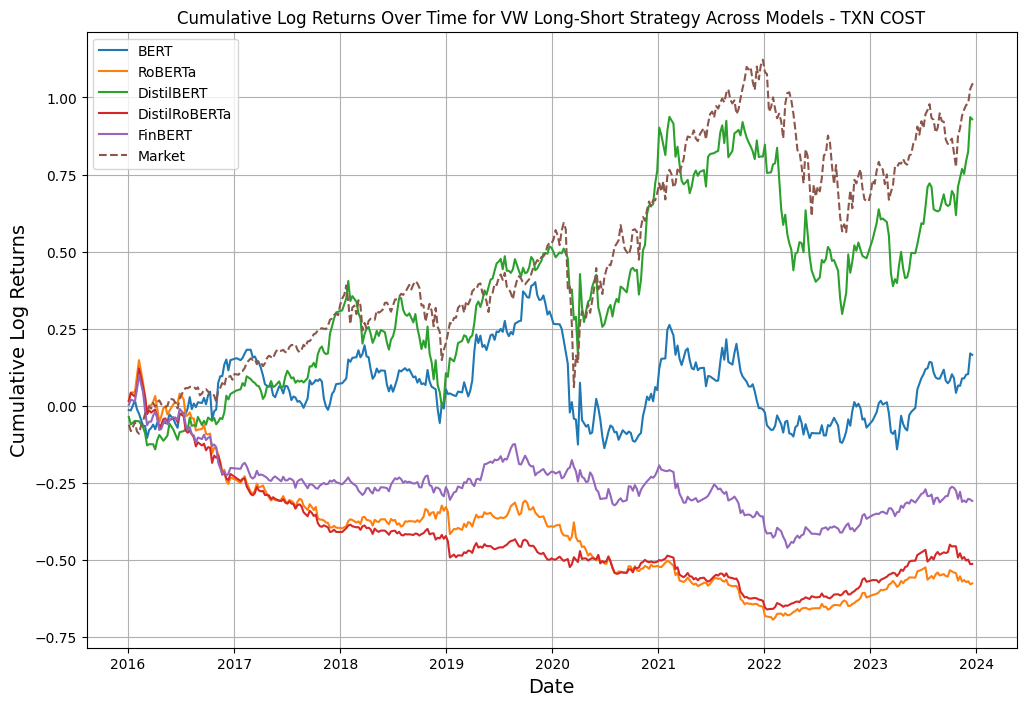

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_cumulative_log_returns(df, strategy_column, title, ylabel, market_data=None, market_column=None):
    plt.figure(figsize=(12, 8))
    models = df['Model'].unique()
    model_legend_map = {
        'bert-base-uncased': 'BERT',
        'roberta-base': 'RoBERTa',
        'distilbert-base-uncased': 'DistilBERT',
        'distilroberta-base': 'DistilRoBERTa',
        'yiyanghkust/finbert-tone': 'FinBERT'
    }

    for model in models:
        model_data = df[df['Model'] == model]
        dates = model_data['Date']
        returns = model_data[strategy_column]

        # Compute log returns
        log_returns = np.log(1 +returns)

        # Compute cumulative log returns
        cumulative_log_returns = (1 +log_returns).cumprod() - 1


        # Compute cumulative returns from cumulative log returns
        #cumulative_returns = np.expm1(cumulative_log_returns)

        plt.plot(dates, cumulative_log_returns, label=model_legend_map.get(model, model))

    if market_data is not None and market_column is not None:
        # Plot market line
        plt.plot(market_data['start_date'], market_data[market_column], label='Market', linestyle='--')

    plt.title(title)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Define strategy columns and titles
strategies = {
    'EW L': 'EW Long',
    'EW S': 'EW Short',
    'EW LS': 'EW Long-Short',
    'VW L': 'VW Long',
    'VW S': 'VW Short',
    'VW LS': 'VW Long-Short'
}

# Load market data
# weekly_market_data = pd.read_csv('market_data.csv') # Make sure to load your market data

# Plot each strategy
for strategy_column, strategy_name in strategies.items():
    # Set market column based on the strategy type
    market_column = 'cumulative_returnVW' if 'VW' in strategy_column else 'cumulative_return'

    plot_cumulative_log_returns(
        all_returns_df_tc,
        strategy_column,
        f'Cumulative Log Returns Over Time for {strategy_name} Strategy Across Models - TXN COST',
        'Cumulative Log Returns',
        market_data=weekly_market_data,  # Provide the market data DataFrame
        market_column=market_column      # Provide the correct market column
    )
